In [1]:
using VQE, LinearAlgebra
using Printf
using HDF5 
using DataFrames

import Random, Distributions

using PyPlot

In [2]:
function energies_and_bitstrings_qaoa(annealing_problem)
    L = annealing_problem.num_qubits
    h = annealing_problem.local_fields
    J = annealing_problem.couplings
    
    bit_string_df = DataFrame( bit_string = [], energy = Float64[]);
    
    bitstrings = [string(i, base=2, pad=L) |> reverse for i in 0:(2^L - 1)]
    bitvals = [parse.(Int, [bitstring[j] for j in 1:L]) for bitstring in bitstrings]
    spins = [1 .- 2s for s in bitvals]
    
    for spin in spins
        energy = sum([-h[l] * spin[l] for l in 1:L]) + sum([-J[i, j] * spin[i] * spin[j] for i in 1:L for j in (i+1):L])
        push!(bit_string_df,[ spin, energy])
    end
    
    return bit_string_df
end

energies_and_bitstrings_qaoa (generic function with 1 method)

In [3]:
# load the SK hard instance data

# number of spins
N = 12

PATH = raw"/home/ubuntu/aqc_QAOA/SpinFluctuations.jl"
PATH_t = raw"/home/ubuntu/aqc_QAOA/transformation_hard_SK_instances"

#subdir = "small_gaps"
# subdir = "large_gaps"
folder_name = PATH * @sprintf("/data/N_%i/", N);
#folder_name_t = PATH_t * @sprintf("/data/N_%i/", N);
folder_name_t = PATH_t * @sprintf("/permutation_data/N_%i/", N);


In [54]:
seed = 100273
#100589
#100377
#101836
#124810
#124536
#100273
#125826
#12481
#124709
#100142
#10010
#100130
#101892

#spin_idx = 2
file_name = folder_name * @sprintf("hard_random_SK_instance_N_%i_seed_%i.h5", N , seed)
file_name_t = folder_name_t * @sprintf("transformed_hard_SK_instance_N_%i_seed_%i.h5", N , seed)

gs_energy = h5read(file_name, "ground_state_energy") 
J_mat = h5read(file_name, "couplings"); 
local_fields = h5read(file_name, "local_fields")
mf_problem = Problem(0, local_fields, J_mat);
println(gs_energy)

gs_energy_t = h5read(file_name_t, "ground_state_energy")
J_mat_t = h5read(file_name_t, "couplings"); 
local_fields_t = h5read(file_name_t, "local_fields")
mf_problem_t = Problem(0, local_fields_t, J_mat_t);
mf_problem_t
println(gs_energy_t)
#println(J_mat_t)
#println(local_fields_t)
println(mf_problem_t)

-6.122638688515002
-6.1226386885150275
Problem
  num_qubits: Int64 12
  num_layers: Int64 0
  local_fields: Array{Real}((12,)) Real[-0.04137221954706198, 0.279894893757598, 0.2582792155981886, 0.16042625180057912, 0.13482261500890125, -0.1698409392827392, -0.40583320861314326, -0.18415599206130098, 0.2910953263899687, 0.053702257920353165, -0.29027950492952703, 0.30264387154308614]
  couplings: Array{Real}((12, 12)) Real[0.0 0.08803920777731647 … -0.10809003781558456 -0.02613229101685796; 0.08803920777731647 0.0 … 0.2232400494742267 0.15705524355025788; … ; -0.10809003781558456 0.2232400494742267 … 0.0 -0.3627037600396136; -0.02613229101685796 0.15705524355025788 … -0.3627037600396136 0.0]
  edges: Array{CartesianIndex{2}}((132,))
  driver: YaoBlocks.ConstGate.XGate X



In [5]:
N = 4
σ2 = 1.0

Random.seed!(1)
J = rand(Distributions.Normal(0, σ2), N, N) ./ sqrt(N) 
J[diagind(J)] .= 0.0
J = UpperTriangular(J)
J = J + transpose(J)
     
N = N-1
p = 2
SK_problem = Problem(p, J)
mf_problem = Problem(2, J);

SK_problem
mf_problem

Problem
  num_qubits: Int64 3
  num_layers: Int64 2
  local_fields: Array{Real}((3,)) Real[0.13375702345533, 0.0036930338557504432, 0.5303622417454488]
  couplings: Array{Real}((3, 3)) Real[0.0 0.5428970107716381 -1.3951405027746535; 0.5428970107716381 0.0 -0.9460077791129564; -1.3951405027746535 -0.9460077791129564 0.0]
  edges: Array{CartesianIndex{2}}((6,))
  driver: YaoBlocks.ConstGate.XGate X


In [75]:
p = 5

SK_problem = Problem(p, local_fields_t, J_mat_t)
#SK_problem = Problem(p, local_fields, J_mat)

Problem
  num_qubits: Int64 12
  num_layers: Int64 5
  local_fields: Array{Real}((12,)) Real[-0.04137221954706198, 0.279894893757598, 0.2582792155981886, 0.16042625180057912, 0.13482261500890125, -0.1698409392827392, -0.40583320861314326, -0.18415599206130098, 0.2910953263899687, 0.053702257920353165, -0.29027950492952703, 0.30264387154308614]
  couplings: Array{Real}((12, 12)) Real[0.0 0.08803920777731647 … -0.10809003781558456 -0.02613229101685796; 0.08803920777731647 0.0 … 0.2232400494742267 0.15705524355025788; … ; -0.10809003781558456 0.2232400494742267 … 0.0 -0.3627037600396136; -0.02613229101685796 0.15705524355025788 … -0.3627037600396136 0.0]
  edges: Array{CartesianIndex{2}}((132,))
  driver: YaoBlocks.ConstGate.XGate X


In [82]:
circ = VQE.circuit(SK_problem)
num_params = VQE.nparameters(circ)
initial_params = vcat([0.01 for _ in 1:num_params])                                             
#initial_params = vcat([0.5 for _ in 1:2p])

learning_rate = 0.2

niter = 100#200                                      

#initial_params = [0.14700491860327103, 0.1422225957238841, 0.13602554432176878, 0.13784471176617888, 0.16651622038986863, 0.14641360484449864, 0.14329936315284456, 0.18014807443504668, 0.16959015293142035, 0.16515771276679314, 0.17978359389670365, 0.21295085923665724, 0.0673636932772645, 0.051415346744467454, 0.03221525179348679, 0.055473023966160565, 0.04619653160807422, 0.04726961684667594, 0.04014789106539071, 0.04795385824909095, 0.05398471536299978, 0.04595669770975421, 0.030389345189650117, 0.03860463165057747, 0.037038535696488746, 0.03383418721480673, 0.03652040221591204, 0.039553181327766224, 0.03472704964202871, 0.035868186791677206, 0.038787866175287976, 0.03704003714582314, 0.03937776302757907, 0.030464839618608543, 0.031733595708781, 0.043086573187139696, 0.036085223175347056, 0.036833922306824494, 0.03653622029506691, 0.03833177814348216, 0.03994080067649065, 0.03651291394899702, 0.0309294659684621, 0.03876975674716359, 0.03427795583902706, 0.02935597712504675, 0.027951880169610085, 0.03213180760406195, 0.03721907115376679, 0.022899722707762128, 0.038441861039667145, 0.04817404307036224, 0.03684372104570211, 0.027467641998321354, 0.04332228347367475, 0.02921206501158939, 0.04184525617658801, 0.04938813538983961, 0.029533986052861463, 0.02233024356555009, 0.03160201117725252, 0.023208405690420344, 0.030612902720286363, 0.04227719503677186, 0.042141963331448415, 0.03828289649798027, 0.0369328102373557, 0.034234208143413616, 0.03653410577035376, 0.03931448162701733, 0.043070028457609426, 0.05404691624343336, 0.03323359041669691, 0.031553635188948055, 0.03997462376653284, 0.03363164806191298, 0.03747849919393939, 0.03755464533332211, 0.036751256921540326, 0.027354496505365623, 0.032192530306990826, 0.0376064870196149, 0.037877392086230414, 0.05074355984932011, 0.04245241904680842, 0.04803220755984212, 0.03967064749981461, 0.03862575522532969, 0.04638964632924126, 0.04142543358657317, 0.1662701433305669, 0.16409963971259012, 0.15568219933474609, 0.15846874031910174, 0.18079005644132373, 0.1681591678254328, 0.16354402854309713, 0.1908221841592807, 0.18708597162173193, 0.18085649995954364, 0.1877784628618557, 0.2145516945033588, 0.03578476165186187, 0.03488220602813276, 0.031090010336099164, 0.040779467109484276, 0.02837963168103962, 0.030853510667013705, 0.0318961304799511, 0.027028981575334784, 0.031482741851404046, 0.025345480646565197, 0.025413320145270413, 0.01899301625576769, 0.027508849494759038, 0.020100098822826342, 0.03149343946367575, 0.028947006379628448, 0.02222287971828242, 0.02460461829016849, 0.031616659997626986, 0.026000060943950378, 0.021825531681903952, 0.026470525103226658, 0.020374690479015575, 0.029308774347931686, 0.02649069248317409, 0.02413120894668953, 0.022831117485274, 0.030561983668030066, 0.020301095277763418, 0.021682279138680316, 0.023867693547801737, 0.024935113951884805, 0.023048936461960358, 0.02289005245779853, 0.017233816773651208, 0.018615312109794873, 0.020917726401191404, 0.01886019596594726, 0.02854040035810307, 0.029809358105017947, 0.020113404424439565, 0.020767446954060707, 0.02823468035457641, 0.02220890991461469, 0.02505042408313888, 0.03657034334257794, 0.024232079771260528, 0.015085599218532298, 0.020964165842854442, 0.021721442636245047, 0.018767844919328366, 0.026951354261909685, 0.026200860831289606, 0.02502678678020148, 0.021868950795915044, 0.020232234675838116, 0.025397915882671387, 0.02062757328520398, 0.02122258942280037, 0.04159337903821681, 0.022066515295328028, 0.01882958003450077, 0.0310174439318892, 0.024966765574099492, 0.019594893212545993, 0.022958768740019512, 0.029794917558991527, 0.018448589418288367, 0.024297106130552883, 0.023307908099609895, 0.026780665588387386, 0.02671141895410172, 0.026950927529136557, 0.029168804129397485, 0.026669657608567897, 0.019996349018837636, 0.02698067157578199, 0.02106766494509634, 0.16343589500815034, 0.16346230270523002, 0.15429394655682901, 0.1599408775334913, 0.17100570450225225, 0.1668156183233197, 0.16237080789763642, 0.17676895710010881, 0.1808441614970479, 0.17316187986518464, 0.17378405504033625, 0.18866729606821578, 0.023510239726403034, 0.02732329047879267, 0.0317521236655545, 0.033782185337725805, 0.02147376245267177, 0.023191891240198992, 0.02876171127243339, 0.022828997703587386, 0.02279900696952306, 0.02054808714761316, 0.025097563132845255, 0.01827284308948647, 0.025408815105230312, 0.021133621342467303, 0.03068421793004394, 0.025631618134789213, 0.0229225584066179, 0.022911710570107772, 0.0291611852295963, 0.023523116037078462, 0.018494792342683492, 0.027996807751058415, 0.017200595336239768, 0.025156201428111126, 0.023085143394007676, 0.019560415790650272, 0.021322851056638416, 0.027683874441032794, 0.012560544092937392, 0.018973991936169853, 0.023366111072392812, 0.021087349926014822, 0.022093086096194627, 0.022550703901949357, 0.016414164339632633, 0.016728309231267995, 0.019165231155658012, 0.020262836889282165, 0.024737671860849964, 0.02783116125257502, 0.018465596939716142, 0.022903627405305518, 0.022405767343638878, 0.021785907330247604, 0.02412191997425075, 0.02892257169447767, 0.02380698087064983, 0.017425487486668147, 0.021884441537485734, 0.02615337530391593, 0.016091537207439006, 0.02445303037380072, 0.025554056164390337, 0.02490312357897895, 0.02049634448610683, 0.01672506719277087, 0.021032420348313933, 0.016110238212914997, 0.01577703358206607, 0.034940384894899, 0.018499502902934176, 0.02296077520718527, 0.029063453804593662, 0.026546562927162645, 0.01749978764224718, 0.023266802869595312, 0.030476879604360282, 0.019604173783744797, 0.02540959025274473, 0.019802429848949286, 0.0298315635707769, 0.02035837380856276, 0.028053312944132366, 0.023801625940404334, 0.024012025564370997, 0.018635424304935658, 0.02138633443412389, 0.016563476544857365, 0.15006463789607166, 0.15166587279065483, 0.14413221029995515, 0.15120131295231518, 0.1513343259418363, 0.15397438090812843, 0.14997862955104393, 0.15293012214684784, 0.16235628221761148, 0.15506036373886634, 0.15074638344304447, 0.15377825332241468, 0.018961256747478616, 0.025426335793188162, 0.033615780573652075, 0.030381749120484566, 0.02079552102850564, 0.02251674273738256, 0.028611430529659688, 0.023308667452356747, 0.021440596074439006, 0.022195109330264858, 0.027383955242536954, 0.022788886792191796, 0.02607945752227246, 0.021820039168325554, 0.032652272811091974, 0.025294057436514028, 0.021853604240986462, 0.02552613788350694, 0.02943785646561511, 0.023266065645745973, 0.020648735063140286, 0.03240912608798166, 0.01849673008239773, 0.025091453826452094, 0.02450883966724178, 0.019953700769158818, 0.022707100733658586, 0.028503065734497013, 0.012162201752031804, 0.019659943952578075, 0.02545295371188105, 0.020740950566013345, 0.023413442291808008, 0.024581708862321226, 0.019463484476597445, 0.01784691990894457, 0.02174907449619163, 0.02333262969382327, 0.02346188803723078, 0.028140250593160002, 0.020434186726983935, 0.0274555945816927, 0.02174068646546803, 0.024408671271747916, 0.023713100574985976, 0.02689483689525722, 0.02617514677398107, 0.0231348545209094, 0.02452071962429854, 0.03026221973022102, 0.01842465276528409, 0.02499215718666533, 0.0274732895574829, 0.025832618610352475, 0.02212317174471804, 0.017073285270260804, 0.022044799976347465, 0.017936678533660686, 0.016158142515747934, 0.032733667766887665, 0.01925736443710476, 0.027020723076701877, 0.029614862330226453, 0.027889186198419902, 0.019902737210931654, 0.02555829301586269, 0.03141911749698281, 0.024868447103643818, 0.02935065997320417, 0.02043769005590398, 0.03327735819266175, 0.0213476157420562, 0.027972353899214663, 0.02619820584000673, 0.02482585625552478, 0.019760841775513124, 0.02049983019115242, 0.01774997665650295, 0.13374436780741214, 0.13628142111683939, 0.13255746005861807, 0.1377066195885874, 0.13094377492811482, 0.1371603126309791, 0.13283359395241412, 0.12759723193983544, 0.14069673017541204, 0.13457914206088112, 0.1268546703104314, 0.1197634890739109, 0.019098991045375994, 0.026976585872779017, 0.03582063688821261, 0.029867608425249416, 0.02328079941836315, 0.02562708204949742, 0.03047142132339198, 0.02669159270541913, 0.02393191726577275, 0.026597408778747243, 0.030693711312730076, 0.031992965208694726, 0.02848295603902591, 0.023368961170494574, 0.03552183781278034, 0.026916372579349215, 0.021470181906391734, 0.029983071173319744, 0.030979939677299697, 0.0251222842555052, 0.024870035718788753, 0.03694481261187848, 0.022584021947083276, 0.02756037006361174, 0.02823108674109662, 0.02296606054062555, 0.02564310664935274, 0.03124744358650144, 0.016838710334550908, 0.023184234290097652, 0.028613221650737278, 0.022852420177204902, 0.025780977478459356, 0.028037110991245062, 0.02500587182165681, 0.021735487876213246, 0.02566168673337784, 0.026367359545003386, 0.025777436484001805, 0.028937261504426163, 0.02396287827064696, 0.03234291776834661, 0.024402273479644777, 0.028618827257980498, 0.024059457562724575, 0.02837232853693046, 0.0294410527437805, 0.030163739036509218, 0.028553347284691773, 0.033387293268200884, 0.023856760465146468, 0.02740774040669426, 0.030129028373717615, 0.02665864587960056, 0.025261842979826223, 0.02103913391359438, 0.02546525642062897, 0.023209689264676755, 0.020047896596850655, 0.03268941377525799, 0.022596691164873717, 0.02945660511067283, 0.03141136344322937, 0.029595365032088674, 0.025152690372009567, 0.027358668292918654, 0.03255677478657172, 0.030522743980731917, 0.03321355329772236, 0.024263396178831154, 0.03520902897518279, 0.026570052999781657, 0.027981893747575093, 0.03011591334616359, 0.028547349853301384, 0.02203596522596997, 0.02269454906396499, 0.02191373775190428, 0.11853192768236544, 0.12099084482573988, 0.12121949970532286, 0.12305343944042595, 0.1142821807659177, 0.11910501418329295, 0.11549018798472938, 0.11087146657504444, 0.11909457536535753, 0.11536217407064196, 0.10864905125960611, 0.09593934109651386, 0.022423770775367547, 0.03039561158087698, 0.037587734417122085, 0.031670948218002974, 0.02701498969837115, 0.03061996996568208, 0.033493052556122366, 0.0299712153804805, 0.028742877613837262, 0.03177897731246566, 0.03392419891313166, 0.03944531526339459, 0.03146526726108467, 0.025552187512466372, 0.03817816105596847, 0.03018921414774889, 0.023537405323453223, 0.03461664811755676, 0.033101508257964304, 0.028599422492273482, 0.029285119392826686, 0.03990539558570023, 0.02808714774849752, 0.03151543853321018, 0.03240577076011944, 0.027416361134727795, 0.029277518171003304, 0.034285104583429614, 0.02394164220111962, 0.027925241110292764, 0.03205974015264818, 0.02612639783998003, 0.02898850204240488, 0.03185974965043963, 0.029105841266656596, 0.026280008021714187, 0.029195282450852834, 0.029403663659711407, 0.03012880969091173, 0.03034279940993604, 0.028892021712022268, 0.03632877616876013, 0.028616967072986735, 0.033404482958329165, 0.02652349323824354, 0.03157472250036641, 0.0327196028425031, 0.034239019955835934, 0.03277927983185811, 0.03621914990904298, 0.029885417098745523, 0.03075154660706768, 0.03278518204745462, 0.0284323836773703, 0.029432750600961552, 0.02619274180959758, 0.029515878382551965, 0.028771846806936504, 0.02500620710246845, 0.03336145065571213, 0.027576976607366924, 0.030997544316034995, 0.033615694563541014, 0.03206939446942063, 0.030175805177082415, 0.02903100458285035, 0.03434255540578045, 0.033009395451589964, 0.03611672772387949, 0.02832942978792888, 0.03580637375348932, 0.031164092022660548, 0.029297351035515475, 0.033118634503444606, 0.031963162517202964, 0.025809773807028088, 0.02613502767104825, 0.02764806252974605, 0.10326996083329867, 0.10508480555556146, 0.10818280334319348, 0.10823848953834347, 0.09970947025111561, 0.1017550407398545, 0.10033863333118732, 0.09497479595893421, 0.09854083055068226, 0.09806068968175233, 0.09335333860829041, 0.08444006134194616, 0.027531593337766325, 0.0343608317133275, 0.03869807497479752, 0.034893593142274824, 0.031173900015233288, 0.03559655359025925, 0.03639232410799574, 0.03272205124090354, 0.03470573356379189, 0.03648524671619036, 0.03675754743401383, 0.042099660939885424, 0.03493302076623481, 0.028974720147216713, 0.04023377974523964, 0.03452666689613993, 0.028138640024576087, 0.038244994534965014, 0.03585932762691656, 0.03275932188779164, 0.03338914002387954, 0.041342749583157576, 0.03365256466952505, 0.03568682197191709, 0.03626102943980757, 0.03242164755194842, 0.0325318350856387, 0.03696601674508566, 0.03091356416163503, 0.03225387036101248, 0.035311099448834385, 0.02998938113177763, 0.032485383158524846, 0.035661770127172074, 0.03261188049826507, 0.031012596765378934, 0.032464409312967776, 0.03347561528167586, 0.03418782986221997, 0.03191994508002151, 0.03395489688430334, 0.03943876232315853, 0.033505373072280326, 0.03786674573969498, 0.030864769424954287, 0.03508474363283551, 0.03600784046871402, 0.03651651596141004, 0.03593584040397435, 0.038996355381499516, 0.03497164885464172, 0.03351882495353639, 0.035474530346699694, 0.031778968367003974, 0.03302935852169439, 0.03065448906923798, 0.03324048564085758, 0.03347126907061266, 0.029880978050267924, 0.034837909274252676, 0.033162622091403623, 0.03206082208067229, 0.035929711432435736, 0.034708519351784047, 0.03387608113322124, 0.030794778981287785, 0.03671475212461536, 0.034321337478083885, 0.03846289127621851, 0.030193365515042744, 0.035379683772683815, 0.03344850275374609, 0.030471248040354858, 0.03520371843992592, 0.03385405543082096, 0.029425771416747556, 0.029427154027542927, 0.031853833928236, 0.0868255974295385, 0.08681307560666231, 0.09352238483628077, 0.09274582624963919, 0.08350522141307261, 0.08571868534767563, 0.08633039286763812, 0.07544358197336107, 0.0795662116805033, 0.08052227787343545, 0.0773580864149018, 0.07184973736164074, 0.03343445475543482, 0.037988451781467716, 0.039421791245369125, 0.038342313945708265, 0.035467210837758806, 0.039073513849719806, 0.03872859575207741, 0.03768067799106401, 0.04015771722979633, 0.04002038923473575, 0.039454716682936056, 0.04313658622962595, 0.03898858607653247, 0.03443748469957111, 0.04148774970472461, 0.03914386336118006, 0.035165597411432006, 0.04058888946314043, 0.03900080929974715, 0.037417707243149474, 0.037212638129435975, 0.04198944466458331, 0.03819205321445473, 0.039333451396780135, 0.03952366080209091, 0.03732378025582811, 0.03539109707857502, 0.03917000018270001, 0.036735386215808866, 0.036160195453314746, 0.03830676513529379, 0.03456690375123926, 0.035821811734614045, 0.039815940237651504, 0.03861807130327183, 0.03638878564480754, 0.03711326824005285, 0.03779239655083914, 0.03714209462219077, 0.03457257293385251, 0.038171017353856265, 0.04176581402803752, 0.03825483662399936, 0.04136044782998667, 0.03612899364166326, 0.038105302435250725, 0.03945045043261142, 0.0408938443578628, 0.0390003856992348, 0.04134669035371192, 0.03951346854001637, 0.03630500662006807, 0.038808172323955566, 0.03623852414735635, 0.03636848341628399, 0.03559613500086268, 0.03670920208768663, 0.03759950624264386, 0.03625779431552047, 0.037347723666923766, 0.03786733644467267, 0.03464095917782043, 0.038936757192428305, 0.038252976630462926, 0.03909655950856769, 0.03404648901073575, 0.03934602709743302, 0.0376882113495638, 0.04100989370876081, 0.03303391980353128, 0.036015074874878816, 0.03558599535105033, 0.033093413534047475, 0.03722934329734534, 0.03636485299170147, 0.034134797963516185, 0.03348150176084343, 0.036042699280793795, 0.0723616609739147, 0.07236943938301087, 0.08056519971650698, 0.07836841112248939, 0.06794045960100695, 0.07148830120568926, 0.07382523740965992, 0.06415439866069737, 0.06627697576091353, 0.0670833826400778, 0.06355462661220097, 0.052818999723397146, 0.03861251169536577, 0.0405723657226413, 0.04018545792274847, 0.04091569425856075, 0.039104142910276925, 0.04107311781055851, 0.0407010648113254, 0.04106335042953468, 0.043366611215946864, 0.04176899783404238, 0.04146260933512183, 0.04363960450713434, 0.04229124950412232, 0.03995358435761138, 0.042046316733323166, 0.04253530016534745, 0.042287019054907546, 0.04209862095313269, 0.04164035806784054, 0.041444984818778, 0.04021278999278665, 0.04230903125289886, 0.04125510360889814, 0.042046346515269714, 0.04174495328834013, 0.04107070852023956, 0.03883967901526925, 0.0409078068049514, 0.0411020049816741, 0.03980880327416514, 0.040893484087357226, 0.03892773947238134, 0.039119742203007374, 0.04259764005859884, 0.04348368060093444, 0.04052649969354617, 0.04114806113131256, 0.04124900408911674, 0.03963594421432016, 0.03849850942430925, 0.0413674009357553, 0.042912915641781395, 0.041533109565408705, 0.04328054012886211, 0.041237337667982224, 0.04047530016795955, 0.04234584165988848, 0.04394605218215191, 0.04201192139250698, 0.04274633579138252, 0.043086070175503206, 0.0400295493248932, 0.04224666982632112, 0.04023400022350774, 0.04039025150331855, 0.04082599807653532, 0.039718292063326575, 0.0407341215168276, 0.04204179674159542, 0.04008525243824293, 0.04075527433233599, 0.03904845240382147, 0.04198182335124758, 0.04184079351090441, 0.042569757426249376, 0.0389996731071611, 0.041897093959411456, 0.041285888167290404, 0.04358446033325224, 0.03867489590378245, 0.03911059791599284, 0.03982279937287722, 0.039417612163940546, 0.04000459373203398, 0.04021499843442941, 0.0407732423034101, 0.0386041532487248, 0.04164132887681875, 0.06605911215838708, 0.07020560025782657, 0.07424960096797563, 0.06946993123689361, 0.060678929322912856, 0.06531649390277784, 0.06766673712247749, 0.057859520738332296, 0.06338668630680877, 0.06372165130710354, 0.058625605346961644, 0.04880029287147567, 0.04172706599909375, 0.04204289155181908, 0.04129559295202868, 0.04220015867772279, 0.04144774146380325, 0.04209112460361993, 0.04199888794487863, 0.041808097982803494, 0.04386800911557998, 0.04212049512625286, 0.042490903129783215, 0.04365519878237435, 0.043433777757158176, 0.04290420010971658, 0.04234622555508085, 0.04364643824404382, 0.04482318425855085, 0.04293268780038372, 0.042821824779225685, 0.04306479546950112, 0.041882047345155625, 0.04249552520208625, 0.042709799631893586, 0.043163119862541274, 0.04274194194997943, 0.04262291834182808, 0.04171941376793142, 0.04211533952606188, 0.04305537361547415, 0.042178281758941276, 0.04236865139070889, 0.041624517271013343, 0.04177051585701646, 0.04320667327913064, 0.04383775892221422, 0.04245558893544908, 0.042840218126136025, 0.04306391149305789, 0.041787207472866544, 0.041671592618000415, 0.043078618217737494, 0.043054460454760544, 0.04289039119048417, 0.043554224439867985, 0.04339649504904526, 0.04204055164329592, 0.04328002157720521, 0.04305649598924772, 0.04341889816993482, 0.043076705033362785, 0.043820242431157744, 0.04242100094572459, 0.04356224882251194, 0.04223813555660816, 0.042735778325551595, 0.043145476780745255, 0.04169855962823197, 0.04265304149796985, 0.04392514642014071, 0.041954564248403395, 0.04216316565604504, 0.04237554218782387, 0.04334577127406601, 0.04333314712357015, 0.042702302820119886, 0.04269484033380571, 0.04325419765933454, 0.04338230390752476, 0.04423005893977386, 0.04272876206606891, 0.042350928933219074, 0.043058225292658084, 0.0438292327343728, 0.0420899507543298, 0.04281993963581412, 0.04444710951165277, 0.04218497599014338, 0.04453781839158956]
#initial_params = [0.18433545618633232, 0.2795637364863861, 0.16553123925672944, 0.25252502585037667, 0.3392724882048305, 0.14915495552155006, 0.15340706192123532, 0.32957211571344186, 0.4074742195794387, 0.2877604562778196, 0.32508741625703663, 0.5640216836886902, 0.021468056390700208, 0.07827245409132143, 0.11637368814228906, 0.08472272236390521, 0.0494914361514699, 0.13054923998462237, 0.060916460288167606, 0.13199804102956048, 0.12455169962172585, -0.09291191075614333, 0.09319468515124481, 0.068330321708453, 0.029470316800167838, 0.0090176922523196, 0.0116048708575071, 0.025727046661275198, -0.004222240363480741, -0.040060463160264424, 0.0028809473572961562, -0.00030711145318309185, 0.05896041636109276, -0.03388619073890856, 0.036336008516020396, 0.01719786832768024, 0.008585729531825953, 0.013632412959611397, 0.019752694913282416, -0.00517987261838125, 0.02332111142140663, 0.02832504667994968, 0.018983762626174468, 0.028224377732977094, 0.007153305392900264, 0.008547642225417009, 0.007667070674079834, 0.005833524698632747, 0.02793287602020619, 0.027965224179062262, 0.008587439515774594, 0.02457655397637679, 0.01660129600287869, 0.017823655348544853, -0.0009041785393447388, 0.015016163363334686, 0.024182581118143177, 0.002986139414295142, 0.01098217278862694, 0.008895213404578987, 0.016475514105081225, -0.020866365431829053, 0.02369365081711304, 0.03867582403749058, 0.040907006914584605, 0.01279189742082582, 0.032975974636523006, -0.026471959967495143, -0.004798340212812373, 0.038173982052156476, 0.027882325219097188, 0.0748718678976374, 0.03663983716771644, -0.051019419883939564, 0.02175807652896142, -0.006400237263660121, 0.03467387282199454, 0.0008907759200767409, 0.028224938307899104, 0.0015778005298149444, 0.010647407667685686, -0.0007356727050868176, 0.005471356815008314, -0.016429666119467105, -0.0002517817249243241, -0.0022058855934240975, 0.0037930806853913195, 0.002907129543439932, 0.003605104774675597, -0.007443175520637314, 0.2341253879083984, 0.30788895065899835, 0.22459241127359028, 0.28637684046479966, 0.2668674631538565, 0.20736492532804515, 0.22451521048881215, 0.3302758053472961, 0.3890338059429199, 0.3011284641803459, 0.31773636839111846, 0.33572350342750623, 0.014820663174260196, 0.04092477376984892, 0.0684455367941307, 0.03756417066443442, 0.019641437949826417, 0.05496341961310789, 0.025844857521868634, 0.02958091077330169, 0.016512608003745634, -0.0437253955579488, 0.05002388649196125, -0.02299206382678764, 0.001325945606956785, 0.0029314337327068134, -0.0030625361657275023, -0.012754289477269077, 0.004320084948684502, -0.030282079434901455, 0.015794607990916535, 0.009028424942998752, 0.021381132154387302, -0.006002798017306095, 0.006310522850654056, 0.012517423300323129, 0.006833858032607197, 0.0050850110560812034, 0.0019359240994426498, 0.001085521022346916, -0.01374651204207055, 0.01938539993732381, 0.0023181565071234713, -0.0033746129696270244, -0.0014177756373468502, -0.00027426980305648313, -0.01049201154246111, 0.007857496203338393, -0.017874055862624128, 0.0075254953447858935, 0.007068666927528101, 0.01306712298802355, -0.006751837496947196, 0.009976578879265785, -0.004389223822741206, 0.004468870440870976, 0.0014392916428866065, -0.006673900899584379, 0.002474466760162428, -0.005593550668142017, -0.002449106537818673, -0.0038550116134999516, 0.006830591191616582, -0.001986759064724012, -0.003112029808324911, 0.009652275302101219, 0.02578064479334247, -0.008213346798960944, 0.009082609147921387, -0.005336796463343183, -0.02125117263085626, 0.06339590661717823, -0.010190257089339544, -0.025959187474171554, 0.006572036917991045, -0.000539938488739551, 0.009883759129661059, 0.0021841788204732923, 0.01339598893233423, 0.015410411976282255, 0.004096823772008907, -0.0020851377158282603, 0.03264001333940318, -0.012130586982021699, 0.008376328907862583, 0.04037299234952642, 0.004385446208538932, 0.0035527779511084594, -0.0014596618020692662, -0.0005667742470966984, 0.25992111055174155, 0.30155982637010537, 0.2561865530258653, 0.2934008406761617, 0.21392857782589386, 0.23125758902343088, 0.27407011067523407, 0.27910428933924175, 0.31590050432339767, 0.28918008968105946, 0.26989033298416465, 0.19512380129426346, 0.009731033739523925, 0.009789628035863326, 0.023535520994434657, 0.006448893311499331, 0.017767446286843104, 0.002333585995440535, -0.003991591357319262, 0.004553083234325558, 0.00886916382383933, -0.004383609069431364, 0.012332992875211632, -0.00839690806865666, -0.0031771174294074655, 0.0010163146133323252, 0.002924038247883605, -0.010697519781768583, 0.0019455392693907981, -0.01593806739478197, 0.007530758485453223, 0.0064104137804755525, 0.006388022198400612, 0.02156342458746343, -0.006212478866800543, 0.010255723023211333, 0.007382057722535765, 0.00090345314670267, 0.0011349697145826216, 0.00895875463441527, -0.003029992923499782, 0.011303272044716676, 0.008011494697062003, -0.011149069982494986, -0.0002949859810428946, 0.002205367987721024, 0.005483349021262663, 0.011088182407141014, -0.005755832422303434, 0.005845043595334589, 0.004979883240515427, 0.008169859902678841, 6.207220482518192e-5, 0.01726693634109306, 0.0006600001437822697, 0.0025329641201117274, -0.011011272195290677, 0.0020516427878059127, -0.0039050286303030203, 0.0034741856570608244, 0.0035459592522287856, 0.010034878323386042, 0.016043864196332355, 0.007471430835975863, 0.007892370812235962, 0.006800124760042767, 0.01649135282750035, 0.01316499756937025, 0.010806292501201773, -0.001598904583928801, -0.004059304010745578, 0.04629828750122358, -0.006696834510820072, -0.008443127029629224, 0.002694455751571279, 0.005377242397723799, 0.014175988292325366, 0.006239225105979667, 0.015620024950065037, 0.03056268354328835, 0.01622697943746733, 0.012000411259721686, 0.03954229466963745, 0.01965372402813333, 0.01847184433208727, 0.0620148439335396, 0.00705292514534073, 0.0022907628254754727, 0.0020679397858613105, 0.006343953879738546, 0.2711555022587515, 0.2861991027797908, 0.280067215756009, 0.29354185279669787, 0.20695784913014462, 0.24424617621666533, 0.29911222657608644, 0.23595670443609063, 0.24388944536635782, 0.2577526993165723, 0.2172303166951096, 0.15801348812157914, 0.008047486791529895, -0.008434413814237068, -0.005994718823471715, -0.003612011754963928, 0.020644157975989102, -0.01872155590000818, -0.013491555168199965, -0.0051726025468664975, 0.005784610218219971, 0.01616210023538956, -0.0080743210971675, 0.06943707037250034, 0.012548744547018962, 0.0050486070419021815, 0.009587527978432799, 0.021190028636307104, -0.00222724705006818, -0.0014812087317476962, 0.003329198022373945, 0.0096564312378012, 0.006337732554173292, 0.030594166193959372, -0.0032802842145103644, 0.00989325346547873, 0.01020201629734868, 0.002112261087374719, 0.009916299610201965, 0.009858430558880762, 0.013561116737328318, 0.006978424350152871, 0.01557807874610745, 0.010072097866124858, 0.006831541267417734, 0.009559841342654042, 0.026943523219738644, 0.007469148422828692, 0.010535643084813986, 0.00662304162734026, 0.004588681842571512, 0.007350102920209982, 0.01154567616364367, 0.016591834995513435, 0.007717202009739519, 0.011467910481747116, 0.009169556329111421, 0.013502200968542969, -0.0017213205986220622, 0.027652274650121447, 0.02001813888426948, 0.018553083781188282, 0.023202223284864754, 0.02298112366129992, 0.025888231677586897, 0.005617506140021651, 0.009506271260260128, 0.027430324569725245, 0.012769829225512445, 0.023846381683106474, 0.022798581584673096, 0.028364647893120695, 0.02151631994919942, 0.003434516448159226, 0.005218799465846204, 0.010074327511664526, 0.02436779284224766, 0.011775579423357323, 0.028341947933184782, 0.015650255264671308, 0.013921318142424557, 0.014090132900267758, 0.019580756110254057, 0.025683210237389807, 0.019561891065717752, 0.023910332768009506, 0.009459859569808868, 0.015442960483204631, 0.01529865858035684, 0.01006664755282948, 0.2701678009716113, 0.2713616963820916, 0.30348969588853564, 0.2939068714926788, 0.23258785644686106, 0.25200742327727466, 0.3067219821827874, 0.2239805967986214, 0.22118674252857692, 0.20628862516893773, 0.2293639962665917, 0.15507819065858575, 0.009813317897367526, -0.005233412136362032, -0.01474116626068289, 0.005309087124767271, 0.0199594040175931, -0.01445793284963602, -0.006928758555847518, 0.0007440686607905504, 0.03250613847811879, 0.00793986443011961, -0.001523944456495154, 0.055940650569738494, 0.03290739919627319, 0.010258762627321285, 0.009545919754580929, 0.05810617811674472, 0.0052799396800509305, 0.008222153316716104, 0.030762799690328885, 0.011874138368522136, 0.011257360483949139, 0.024957641565902883, 0.004263149583909517, 0.009966552864552405, 0.012557118304923237, 0.010610831069190514, 0.01746058283597947, 0.007609405408962665, 0.023216871889079196, 0.006475190074913524, 0.020034674153401235, 0.022251888896467547, 0.012511541624825668, 0.016750060659021907, 0.027047480508735254, 0.004422312937112863, 0.02745348550124669, 0.0071919137830483175, 0.007084827429476901, 0.00865126096310177, 0.013457255682185853, 0.03499075643179543, 0.011484669769015507, 0.036337109634552674, 0.06179610460478556, 0.011508093359874601, 0.011921488544653355, 0.046933440334937536, 0.03578480261957326, 0.02044593437361895, 0.04899077859290267, 0.029282379982387412, 0.05739920280094179, 0.010475420412331838, 0.007840188527752569, 0.0173148300740388, 0.027408459487727257, 0.042666435945796055, 0.02160923951491193, 0.014393783554660596, 0.042803162110508663, 0.007287861327982007, 0.010319773386784786, 0.013474473004923982, 0.04250954083346256, 0.015667773615703016, 0.05373851499307447, 0.01825463637718329, 0.003252342784533966, 0.01623071334209459, 0.021488274095758236, -0.016402537111088335, 0.01826103055428727, 0.017725780868301996, 0.010091856460561849, 0.04538649547038795, 0.009045332382980262, 0.01084623136426577]
#initial_params = [0.4478382627555591, 0.0942831968039879, 0.3274270843480295, 0.5871382738560421, 0.6918853792697454, 0.10468738555844084, 0.31239805328779496, 0.17157234609723215, 0.3094574720788024, 0.1389626002045854, 0.19053572396526214, 0.2908960160192402, 0.1449058163111645, 0.48073081352960556, 0.07104165580773458, 0.04769791535604016, 0.7938127428450832, 0.15600822154796926, 0.6114331524750863, 0.054317597633610805, 0.0658780305713517, 0.05926709384622986, 0.6339727542289622, -0.1589469389617132, -0.005427168926432192, 0.05279530472312426, 0.01151800448105079, 0.2314498985949827, 0.006706937494388758, 0.12088864013729228, 0.015365177350648795, -0.06375797152350825, 0.009513149643076682, 0.0030487995537365237, 0.0061696591054802635, 0.005335503992318369, 0.016723741320219167, 0.0013080037237087473, -0.036858791319791966, 0.009968672288130549, 0.0022169117067914208, 0.007150045597916694, -0.0021588338851910136, -0.005129763205036205, -0.0045504066210357635, -0.05412937875087579, 0.011449697428194303, 0.09182066546119616, 0.11699981202509674, -0.016200434484587713, 0.005857757205178672, -0.0023377235720105573, -0.07400610102974167, 0.0034461010835560107, 0.029652208616581945, -0.14669326193008994, -0.004677677264442563, 0.04782167157240212, 0.04911025486833563, 0.027753262474489546, -0.0019082108669932652, 0.006871967332292386, 0.021532830257359678, -0.010537517088447673, 0.034133696947150086, 0.01717197411207398, 0.0023054084763895442, 0.030170560576976608, 0.1299487965987236, 0.003437752631146418, 0.02101452796353966, 0.01780548550537219, -0.001605405863943756, 0.02907567818223189, 0.0012452022510024403, 0.10390065490902384, 0.021524962244793444, 0.04384455857477465, 0.07044990755139907, 0.835694650807262, 0.0379343396145789, -0.3407049310674236, 0.800420355014823, -0.007895791216075934, -0.015611510450543107, -0.038566277013822536, 0.05999032605286756, 0.11391954012283417, 0.07329143040804581, -0.02359914749867803, 0.6668344140802704, 0.20898270766678143, 0.43689891535414505, 0.6905061358650786, 0.7684148983208176, 0.2078037463393939, 0.47839753236531707, 0.28134233277373155, 0.45437115400135225, 0.2204653918511431, 0.2915705549224819, 0.010649465036326631, 0.12069329263641443, 0.45028515878849584, 0.0020651863712743772, -0.016403394190096475, 0.30208186646140744, 0.14705112713561025, 0.49619705870969527, 0.041884516632079316, 0.06880610624137337, 0.042188687851180455, 0.5856374777242532, -0.08465126754387904, 3.667940889054617e-5, -0.03311317541872038, 0.010519038405952311, -0.03595734641507949, -0.0028152992535574756, -0.08638533846538313, -0.027782566991271865, 0.03571356519669076, 0.0073790630940387325, -0.0011321188117879189, -0.0035712570982596313, 0.001831352396101834, 0.00045455223341131566, -0.003632795899123954, 0.007507084210809388, -0.002847565540049676, 0.01065356872495615, 0.0018067240097540908, -0.0021039945423295416, 0.0031569437889777357, 0.0070404148549472285, -0.04852264257964359, 0.011361962121107481, -0.0021944613399975986, 0.10556782392969398, 0.014487341107314193, 0.0014586519728505326, -0.002138526706730783, -0.019416800725869196, -0.002201682696938764, 0.008814702235252598, -0.1026402272982101, 0.004898949108944687, -0.013511585845673742, -0.03372246080702351, -0.0030355333380164516, -0.09411594187568464, 0.0007429697545868583, 0.016967212037767333, -0.06121689857396565, -0.041200618824306146, 0.008216312707029282, 0.002388585128792262, 0.024945548745243188, -0.013727461310934714, -0.003448614709265672, 0.017816351880565, 0.000593562647164041, 0.0025837146916969805, -0.02191605205089639, -0.005996851154579208, -0.08859491889617319, -0.0028312331599975485, -0.01793743855870373, -0.0013225761250552405, 0.6321457866993265, 0.0324618676768, -0.34603963444292507, 0.6403039407707648, -0.0003367251743850442, -0.00717311227032166, 0.008715476030633818, 0.2400199975605242, 0.32858028510553217, 0.07600144092121891, -0.007081493380206733, 0.5105139366533571, 0.3612159978557479, 0.5094623087735599, 0.4133406087775888, 0.24519470772829147, 0.37750740536452676, 0.5092695704801493, 0.4004767726621791, 0.5458332362060235, 0.3560364780683341, 0.39795239685490497, 0.010111458881158022, 0.09342242501914666, 0.3920002719552423, -0.039305015052802456, -0.002563912334529868, 0.03683322371351107, 0.12798924269382714, 0.318284997819374, 0.02818423393514051, 0.06650380191253166, 0.015027511828521495, 0.4851685341140304, -0.02263645000048134, 0.021881862738225868, 0.046115295052948174, 0.014757787136158003, 0.1393001721956496, 0.026636393006017278, 0.18978423752948492, 0.04028989720292791, 0.315674533622726, 0.005965134859513528, 0.0016179842834209337, -0.00020916597979157728, -0.0021193467326193673, -0.006040044841577316, 0.010163670980804135, 0.4112532315033044, -0.013961510299227757, -0.007333811817736732, -0.00957423604511174, -0.005086044220240371, 0.027697070216878717, -0.0005046536828998979, -0.03649103836065164, 0.011696681243904944, -0.05669431203955584, 0.08724998482322023, 0.058398118579454365, -0.001456540768158352, 0.0013493921944402144, -0.03261479237813668, -0.0004938219277911327, 0.004456514917859318, -0.04750845372420827, 0.012584000948692999, -0.03315228628135265, -0.0192264484753003, -0.014333650964867157, 0.300672134330796, 0.0011499881622836186, 0.020281910544617643, -0.24185152424992737, -0.012780172429695265, -0.0006580804375976234, -0.014847835939791458, 0.03097451345466814, -0.10046965890926733, 0.012259181796187936, 0.009847157838523184, -0.012242549123150946, -0.0008356382435560975, -0.0912495713956987, -0.004182558444422504, -0.07471061886275064, -0.022348698180229255, -0.026865567647447148, -0.054943831634341106, 0.33610128418003865, 0.029000687917257434, -0.2576516177664633, 0.4568695466875769, 0.029838998798121217, 0.004000507257338024, 0.060957880927936955, 0.4907298782819243, 0.4666269771709794, 0.07218856685602819, 0.008624512204940659, -0.08420356743956751, 0.517970934583256, 0.6219088880489999, -0.013621175128241438, -0.1311971616305356, 0.607820043564028, 0.33705140889888463, 0.546759813196051, 0.46783503578479585, 0.5818758053345342, 0.47650100549200614, 0.008467373549658819, 0.08255387904544018, 0.29858209554145776, -0.03077368567171943, 0.03170927217129607, 0.0719377136777561, 0.09659111634728747, 0.16743787944959426, 0.01824415813266722, 0.05816465073559223, -0.01327071262919811, 0.3405677577122015, -3.957010905188456e-5, 0.049800240268777274, 0.15806806213667005, 0.020491596394069764, 0.26643968070282426, 0.049970117392895884, 0.5323625527816837, 0.15490878678680417, 0.3704961318155731, 0.008270951192221772, 0.008582627595792263, 0.021276242279993144, -0.006657968077833691, 0.006978481281903883, 0.0406153928160633, 0.597540925173832, 0.054606776602055956, -0.027108245806648296, 0.004880600741397136, 0.05167521698972993, 0.052969509179085404, -0.012031032372371183, -0.02320237868233671, 0.013193592105936583, 0.024105445435507526, 0.06783119318257659, 0.06083118530312817, 0.0014492771629229797, 0.005044856556354946, -0.04606035009699147, 0.021927878010114844, 0.030730068567594075, -0.019015368497642203, 0.058458312091662835, 0.021295876909461112, 0.07207332636268023, 0.02542927186661919, 0.8920747465353023, 0.02657694452230384, 0.041310161305038264, -0.3175588710837713, 0.055787638069177393, 0.00047661477467500474, -0.039953799356905705, 0.06933133205469591, 0.06921145196364281, 0.04428129220444638, 0.0009663261290772921, 0.0009779382911394964, -0.02823455786067959, -0.07047227407561793, 0.011525870494844862, 0.1574942230431826, 0.0009557347157256498, 0.025373027760137078, -0.01904832619382674, 0.2641634124115934, 0.023879907558814657, -0.15258549595435783, 0.3672226457134846, 0.08158851987195376, 0.025263479903856502, 0.08721125408295673, 0.5740028192559408, 0.3847079225998425, 0.06486229087561071, 0.018315133865083662, 0.027747551410057542, 0.6367943485851608, 0.7773118945110128, 0.08574116101747528, 0.042716454507788985, 0.8206803550643279, 0.18403894193230216, 0.7026427495966048, 0.4105456077821828, 1.0598766676746456, 0.5382380860502936, 0.0038150931303253285, 0.05496847270159644, 0.16844097596774904, 0.007415151941084777, 0.02178069612255306, 0.08114958635282674, 0.05501181999994366, 0.08945283480301934, 0.013175256258534265, 0.04200801467094319, -0.01764967414772966, 0.18442313534630447, 0.005720819605279997, 0.04695718941372923, 0.20899232357000253, 0.022906627806456952, 0.24353394934853176, 0.034451817275941855, 0.44288451284307817, 0.17789819840765883, 0.25053789807309407, 0.01054119294944675, 0.009362759716884808, 0.028621394333424758, -0.015978547769873938, 0.03236891335707631, 0.047426495989912595, 0.43819155987392006, 0.11725712694250166, -0.02503271569987815, 0.04293086282878162, 0.0511426733093544, 0.06582785016229654, -0.01728192623512761, -0.010038854050474217, 0.013550049152327609, 0.1527595654832397, 0.04308355358310188, 0.04293781091262461, 0.0072088758118929825, 0.0074022668194053155, -0.030421684310355558, 0.039355675824006564, 0.04293416343902837, -0.004916341087013985, 0.11927154586699396, 0.08106042662300564, 0.13830710091147885, 0.060662001905729505, 0.8660711819371377, 0.054116070733346476, 0.07907528653272937, -0.21922062298888448, 0.08795689149497392, 0.019262924370469732, -0.03224611202846679, 0.10528552539426421, 0.3130189839964989, 0.04807283937256296, -0.0005375593207764638, 0.044717549407702346, 0.019717550423843426, -0.02222622676341034, 0.05143016160196214, 0.299645312344615, 0.05345290787993993, 0.09661916509761857, 0.13810276348512598, 0.26846510869879725, 0.017704925898324526, -0.07011254792066604, 0.2926261084759078, 0.07275157561957263, 0.03297430890472555, 0.06809669097763854, 0.43240442112803634, 0.30128642861792876, 0.0466647132087112, 0.019574094113232215]
initial_params = [0.10803567693342388, 0.17935565576981988, 0.2710553441187966, 0.43088319751525356, 0.16238447268215836, 0.10252353341726143, 0.10181515076852453, 0.3115215522947805, 0.3178731052027421, 0.29815475074765496, 0.5216819152374119, 0.6855615460091337, 0.15057393646686013, 0.5991983587621085, 0.07272426995616844, 0.17302674229242254, 0.07087206024780192, 0.1424461020710369, 0.4526686034860608, 0.1466223674369767, -0.14624631364542448, 0.5832913696095768, 0.0947316168623749, 0.771703129885295, -0.028089474067608255, 0.0481735331931806, 0.049955178017033045, 0.013110993057845332, 0.010449776301800273, -0.10284472144347029, 0.015240818979365673, 0.015384601438989336, 0.05112988132537255, -0.044454272173305893, 0.050908646209066453, 0.015866507722225365, -0.0072413729032194864, 0.022731185957271808, 0.04146663321584702, 0.020407940474839154, 0.02282136444398575, 0.008095784577546481, 0.005162417392448621, 0.012689240774484039, 0.0335677073987144, 0.014050735853575849, 0.014061679842083704, 0.03896644655585634, 0.11323499927146571, 0.07043126021636019, 0.026531094512576774, 0.017936692963673496, -0.0313523920863567, -0.02459694206415706, 0.15363194976045086, 0.6595807387637402, 0.10620987329448703, 0.060652880336290904, 0.039236681978603735, -0.32546334738255617, 0.01644125295320268, 0.052448455094483086, 0.054619739645911256, 0.026513507272981376, -0.003530758278752867, -0.014423330058373734, 0.02402883846696174, 0.015334060485177646, -0.03828116582297891, -0.0038606083306655867, 0.014771157248516154, -0.1393018208026089, 0.2560597115458063, 0.11716889248063211, -0.08096264896093093, 0.03711601095526861, 0.12841793854015426, 0.7466277793640551, -0.0006908066933296979, -0.05949350693541274, 0.03720309478684599, 0.0125899630568441, -0.01326103061298524, -0.00971541127709713, -0.026814755390489386, -0.07819478087348879, 0.010004781984767643, -0.001618254542432313, -0.012698909198803869, 0.004075201082401089, 0.20916783942988296, 0.29317341898980676, 0.39739549477824765, 0.5926414363228393, 0.26851134157425566, 0.19161190955191235, 0.20644985596561585, 0.4193791987501334, 0.11228014392816858, 0.4683928933009517, 0.6269141972715944, 0.7626949754620796, 0.14162242003003417, 0.5499588813119571, 0.07321853492123923, 0.15229072542502126, 0.05640957786175877, 0.12493357798433932, 0.423535353166945, 0.08190571401848719, -0.08195841324261655, 0.4702281393301997, 0.0322356019836871, 0.31654161982954765, -0.016576656819013325, -0.013340120332318578, -0.019193481983333295, -0.004026455587203243, 0.009695418602287512, -0.07211621917830544, 0.012508330988851785, -0.0032627784832539833, 0.03666507712210551, -0.041506023945733016, 0.046819078484667424, -0.012142167570921937, -0.012813604909220917, -0.032107980537045624, 0.041510814114514155, 0.014861837994585892, 0.020075867074193864, 0.012187747611547296, 0.011106498268803177, 0.01272181457596192, 0.0339454221461208, 0.009920152441828246, -0.0007707827973481961, 0.035506835607366984, -0.007845976742927868, -0.007214948817249973, 0.02860382148194356, 0.02123432053179935, -0.01320372394439249, -0.01148902825753486, 0.29119692997622804, 0.4537367836529393, 0.2380094345433269, 0.06180199840568198, 0.035642419619132136, -0.325825485683263, 0.006773580353705856, -0.07594944541868574, -0.034554908110895954, -0.01565000188783976, -0.0036608077003458367, -0.013706123401100936, 0.008552034907140856, -0.0036108765123464667, 0.005515447151108353, -0.006456524257190797, -0.013864215095299117, -0.11253983725899339, 0.05807288234253815, 0.10987714366189907, -0.12546450464804634, 0.03500634199323496, -0.09260336860162598, 0.6043081065548817, -0.008495748369340183, 0.02604956136607681, -0.038729411879132904, -0.015580696531460542, 0.009892246006239787, 0.016238644700821633, -0.016677094899129406, 0.064203002636259, 0.009639902530142392, 0.025956537404746155, 0.013560451841704175, 0.0021969258211359203, 0.37244030675076034, 0.3965531166700428, 0.46324963908306405, 0.5149582809950636, 0.38549371063074955, 0.36153079663831156, 0.3464233554853147, 0.48422667858919144, -0.0007314051646352987, 0.4968293951434764, 0.4287592440594378, 0.2698533708265836, 0.12292111783585771, 0.4518223432687809, 0.06685910007366529, 0.11333836664577579, 0.03826759631165405, 0.09358075381536198, 0.3682353115614969, 0.028298799428947485, -0.021877425597597467, 0.30202143863246766, 0.017702342334059033, 0.05360258032888464, 0.013372665083098903, -0.0365679979295132, -0.03808164282816685, -0.005600317512195001, 0.029182384080492684, -0.053860296988792244, 0.010353323062563785, -0.016320588201574664, 0.03153680548656583, -0.03359059395455059, 0.041477487132758034, -0.023704600819081764, 0.041664831812741054, 0.18509939380906693, 0.049420007010174606, 0.005913847631238284, 0.012776720930279368, 0.020846197856260733, 0.025719234390400452, 0.012764069276968038, 0.03759063749710376, 0.017253005206704936, -0.006907225472465941, 0.03702204544809128, 0.013425004132079475, -0.041554128717315175, 0.034167432239290516, 0.02841442687341489, 0.004106941104807983, 0.002928679852428015, 0.42777856896013283, 0.2541090631209434, 0.4775676296662408, 0.057221939940681116, 0.03258392180417196, -0.24184639830634996, -0.021915060483148462, -0.029168022873946674, -0.029201493714928035, 0.0012511234906238083, -0.00043126230537715896, -0.008201111060414379, -0.0312587377794544, -0.015815469555212843, 0.05345101940145818, 0.011673043787350955, -0.0047627297072974735, -0.05434149466389289, 0.12353108340141768, 0.08850763939751291, -0.2061578181128014, 0.04909962925092257, 0.14617865560054752, 0.43486675059355695, -0.005587669745567585, 0.4042072046910987, -0.07679616155901274, 0.0037357209807695, 0.11635790302059912, 0.049045859345965684, 0.16092284281639038, 0.30960638258231266, 0.008790376927735651, 0.03823928802511179, 0.027092466145518582, 0.0036896586139748538, 0.6015951833052183, 0.47146058192778373, 0.4361388913470397, 0.15172743163704447, 0.5328880763359539, 0.5874244707244796, 0.5010615808712267, 0.5671123161361236, 0.020101146182741867, 0.34554070627766986, 0.028223517956301306, -0.1349636300911753, 0.09264583664821295, 0.3169935523437743, 0.055427404726173524, 0.07982377439183351, 0.02180656326603991, 0.05086876216394221, 0.27975659940842734, 0.009378590632576629, -0.0002520960015610639, 0.1647469298824488, 0.03075989633451834, 0.05733226780888047, 0.050355026650083665, 0.015548668752358006, 0.02024229857844998, 0.020793898120688766, 0.05176815481350932, -0.04039415442469925, 0.00894869029611838, 0.002850100427541551, 0.050221642955645684, -0.02153245092681802, 0.039332913113760165, 0.030643033828483154, 0.17763998616331614, 0.5415931289073025, 0.07260378409992238, -0.006914566067315461, 0.004136845938452469, 0.03332693159985996, 0.04068590909259626, 0.013318077048139945, 0.04912856371921785, 0.0336953260399971, 0.009305925002589378, 0.04626654884012728, 0.15370695764021924, 0.048363001663633935, 0.0462104567491965, 0.03232134966963502, 0.02707113824967344, 0.012548529176898308, 0.37592279714522087, 0.23508385149406497, 0.5573989871363588, 0.04947393820816513, 0.027294411470286342, -0.14571910649886852, -0.03423363656679784, 0.17647837061061147, 0.06348144641833095, 0.06247662577836495, 0.005042503045479179, -0.007923705785988517, -0.04895196668863974, 0.005864000752937562, 0.07723228147608846, 0.045368251139079545, 0.014265152644290255, -0.017540046920405918, 0.24161474461780094, 0.06466044997766747, -0.21798922086160352, 0.055845729263109295, 0.4953345822730391, 0.34658376912128697, 0.04304371188911264, 0.581864953682026, -0.046625316152873165, 0.0777627235279339, 0.15449447109224457, 0.05672278694680369, 0.24124817546879357, 0.3533110149004842, 0.009828295420157155, 0.07357351137239099, 0.046002667228271926, 0.008301763888194938, 0.8042301076985273, 0.5567004733388694, 0.4916935063952447, 0.08089018428935779, 0.6859122721078571, 0.9030436160830836, 0.6138579551072822, 0.7235922786813387, 0.02039743299430971, 0.2246445638284578, 0.07732585932221966, 0.0341900233967511, 0.05253560948659437, 0.17138095112447663, 0.038810877307790904, 0.052651048123653545, 0.011881962199527982, 0.014300167749298189, 0.15717704063393229, 0.015547077056267258, 0.005609782085372886, 0.08849707680553075, 0.02122674764727566, 0.08067631652952287, 0.06755449308355681, 0.08076124411812552, 0.09604936900543523, 0.0282765389898449, 0.05188335179285761, -0.023335242294461364, 0.0067698455160921465, 0.04300920254659567, 0.06142143241374141, -0.008526633081827164, 0.03776492276498306, 0.14308575279258393, 0.25553720526373835, 0.5737027529914737, 0.08206295045360648, -0.015703648958357432, 0.001692026667865725, 0.03607363495545831, 0.03997938268445802, 0.013188738151933499, 0.05324495031176831, 0.040859510486843505, 0.04160376074193321, 0.043157662318616466, 0.21142225306667423, 0.16098946621710933, 0.05794212979176037, 0.02704850600754654, 0.035066859681355915, 0.015766565193765764, 0.2839980909396947, 0.24346152379121253, 0.4088518850617908, 0.03471193275888733, 0.019814207098165584, -0.06897430138751547, -0.021976228303861284, 0.28680412020662843, 0.1274192154601004, 0.11645827363026204, 0.008863711553439164, -0.006072815282032816, -0.029289892003142665, 0.041049911625528145, 0.062006318038180394, 0.05159768142063597, 0.04708075164024756, -0.0029959257490144017, 0.22086071147818986, 0.04078677135547986, -0.13959565202067198, 0.03791901434197274, 0.43095568999076994, 0.27602388964867147, 0.04609539566293303, 0.4187610583174877, -0.013683879875176911, 0.13485286274879255, 0.16330576335227134, 0.042675268058963406, 0.16425251843514224, 0.2338358740040856, 0.01093035278942689, 0.07259561428272664, 0.06594708974194674, 0.009450292673068515]

cost, params, probs, cost_history = optimize_parameters(SK_problem, initial_params; niter, learning_rate=learning_rate)
#println(length(i_params))
#new_params = i_params
#niter = 200
#cost, i_params, probs, cost_history = optimize_parameters(SK_problem, new_params; niter, learning_rate=learning_rate)
#println(c)


(5.828345785318575, [0.07459623562101031, 0.19912770043816272, 0.1799304236540252, 0.420553454695642, 0.1360256811964075, 0.11007593854502874, 0.1795517493055241, 0.3238108527717226, 0.23466435658737353, 0.2791746370113771  …  -0.0035458759946472955, 0.05170811879570831, 0.39248194041133533, 0.02650376167798955, 0.5596907552241148, 0.1385395802720254, -0.04117574751512659, 0.18740348467054369, 0.055108192226399344, 0.07184771908810257], [1.3534718454791097e-11, 1.4968244456256236e-10, 1.419021941691117e-12, 1.8211673403532463e-11, 5.655827945006239e-14, 5.9566803105219985e-12, 1.3305842542531442e-14, 8.246501242212454e-13, 3.900816902560978e-9, 6.909526004110796e-9  …  7.280002591658983e-10, 8.19277906977937e-11, 6.528489353933406e-8, 1.8575785549770174e-11, 6.656756006215645e-10, 1.9732499206762665e-10, 2.7146453082493324e-10, 2.9599475428708558e-12, 1.0586326334689245e-12, 3.4181819254430057e-13], Any[2.726729383711876, 3.1824010134330556, 3.5312330100607223, 3.78197249963881, 3.9620

In [83]:
println(params)

[0.07459623562101031, 0.19912770043816272, 0.1799304236540252, 0.420553454695642, 0.1360256811964075, 0.11007593854502874, 0.1795517493055241, 0.3238108527717226, 0.23466435658737353, 0.2791746370113771, 0.960628323746928, 0.6812662308878319, 0.04135642019044211, 0.663625186745721, 0.6909400333283973, 0.03711113514904227, 0.03494496132310421, 0.004960184437100354, 0.6136016982675658, 0.035772527005062164, -0.010173916592907891, 0.21355959494914104, 0.015544642595880596, 0.13751425402692533, -0.060251910208695206, 0.04852383544088163, 0.05115938464458549, 0.06527339085726702, 0.008444860077542717, -0.026653372430668208, 0.027511547736100258, 0.01392568125788122, 0.03294706791638256, -0.044780731753883654, 0.04953957930321904, 0.04351116769989715, 0.0733305532000687, 0.06860861487246321, 0.0922198621980324, 0.005550811133681576, 0.0031397081699933316, 0.08867219063010452, 0.007882507777085808, 0.004557240236552102, 0.017759597926310704, 0.01789168720532532, 0.019115690689844946, 0.031571

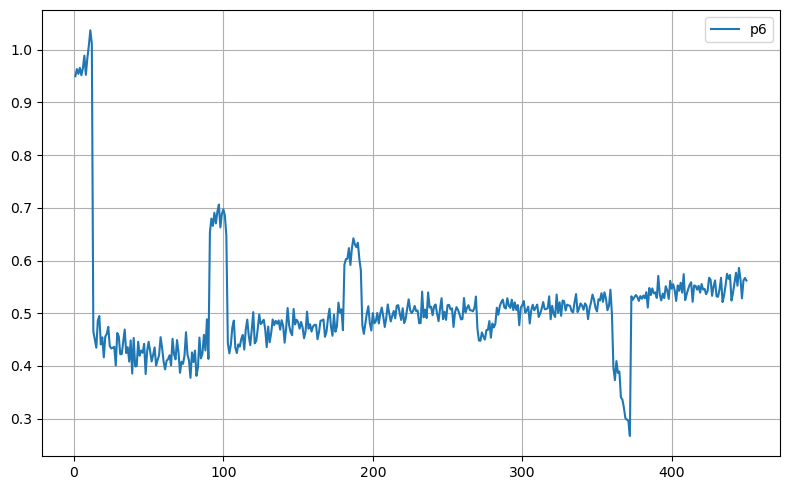

In [2]:
# p=5
#p1 = [0.46502071986432086, 0.6044442599486659, 0.4678392519777472, 0.48756836145332233, 0.48330712370048523, 0.5941632709866699, 0.7126649680766857, 0.48475754867624354, 0.8459178727597129, 0.7676633677313386, 0.6758959022067369, 0.8618139933427091, 0.10763199372904397, 0.30717362842339896, 0.07462683202811383, 0.1534274154725327, -0.07262092214577925, 0.05918226355245255, 0.017222311461068333, 0.05899567551547331, 0.12846410514624956, -0.014141539488930197, 0.022351925566126255, 0.061276409603182834, 0.03151789294524646, 0.018816773519284027, 0.08694422431213238, 0.039662928496061164, 0.09159292889534222, 0.1084660547643773, 0.1337348170902424, 0.030469694725955315, 0.1566195292922408, 0.03752003876012186, 0.10666627692342234, 0.057168194193711115, 0.08294756922346369, 0.0892370714226902, 0.04029903312833589, 0.1125784371606278, 0.05708107784080212, 0.11799916799246599, 0.051219757631268056, 0.015587123192880843, 0.0859288051505862, 0.08887214081962748, 0.08412476327118479, 0.15117154991140577, 0.1203688410843929, 0.05666145190961828, 0.09174817577961901, -0.016005199609462846, 0.10246986731049261, -0.001513440372847355, 0.08301668507244538, 0.08174006476968489, -0.05358351145063799, 0.12742507151970767, -0.04071865850418909, -0.03220173681895969, 0.07821071129470995, 0.04042467195197451, 0.07278256336947038, 0.10979573367922008, 0.09933252263377895, 0.17217398660431427, 0.2227391946350058, 0.216393644836169, 0.1341191258811508, -0.07329659705649909, 0.009926768320524297, 0.24350639831054435, 0.260301454856947, 0.28034450888920526, 0.13558771077594572, 0.061647216723649714, 0.05308985673803559, 0.20498065607048932, 0.5867571275007092, 0.0411083448984101, 0.013549160520151867, 0.10460176526041999, 0.09646272090497338, 0.18980246474729806, 0.19816889648199956, 0.06206863200672955, 0.10243485548482044, 0.05989820992557104, 0.2413505731832266, 0.3414821024590499, 0.5644772209187164, 0.5663393767986786, 0.5338037257384477, 0.5534583052672288, 0.5163790485518645, 0.6384526282089105, 0.6745720465445753, 0.6299273799414278, 0.7360582423204992, 0.7784985251206957, 0.28069981662896487, 0.8153873697874804, 0.018197306016343548, 0.07550875797450887, 0.04558515871427082, 0.14147238204342033, -0.0015444359666698549, -0.047272897225166276, 0.028283723698127185, -0.015248485566917012, 0.14161981588926922, 0.019496687701016088, 0.0898184781999239, -0.008055685620111323, -0.027199478046268703, -0.016706680670227812, 0.09124266694168152, -0.013210558492365004, 0.050346985917629226, -0.021603566745239517, 0.11783244030599536, -0.01263676832794232, 0.1405413653691426, -0.02806806456437395, 0.035643446587222016, -0.024000620904656406, 0.01336673033126621, 0.09926998606090921, -0.0020777846289376954, 0.05326181731312738, 0.04654882208900784, -0.012110596730500219, -0.012521706742671761, -0.0059435107131316734, 0.025936521073600647, 0.011307980397790105, 0.05923363041053965, 0.15112104414269178, 0.07094854471391937, 8.000201455053853e-5, 0.0012875618801550235, 0.011866082074931346, 0.02155899158647283, 0.010320346534831208, 0.04763686952730054, 0.029479106808051127, 0.02072171790544052, 0.05385599702183968, 0.0329865353022687, 0.03863020254752995, 0.00876140120516538, -0.012582122427906134, 0.03330913755683852, 0.011262795850643097, 0.004985926115492796, 0.0838630739248391, 0.0816763320126338, 0.1704922340706595, 0.028509913944889505, -0.1399362162064188, -0.005218560326307487, 0.2234869224264285, 0.24629000174849175, 0.33129493227150886, 0.21082144753967177, 0.0950481385867447, 0.1315501753701781, 0.1925307769244398, 0.6128322796172144, 0.09836098933096095, -0.0021944129541779447, 0.04173823219027908, 0.03766891893182124, 0.1633327318347038, 0.09856507836379189, 0.009984282544357329, 0.014637471826725265, 0.00549782754198672, 0.09246435945591276, 0.4249837822811334, 0.5737713156299329, 0.3503839521711972, 0.5074262966428269, 0.5148043700494338, 0.5428585358356074, 0.5285767247423467, 0.6039984428278288, 0.6598270228072225, 0.5571098974251004, 0.548648636293854, 0.26923303595102654, 0.5904971455049334, -0.025364678471065185, 0.09071413347456578, 0.05821504558333928, 0.13607861943676364, 0.08854128607294412, 0.0367349735029878, 0.08228734272941612, -0.05846831218844891, 0.15598012739096928, 0.0680017444154313, 0.13221002115059077, 0.025373087368657607, -0.027442338116686622, -0.008263370028479818, 0.1502888202254536, 0.0012469734188091945, 0.07144270648972074, 0.056496587324237194, 0.128037659549574, 0.02532508032957775, 0.13220135755319484, -0.0062990361247936815, 0.07208656845663886, 0.07829884691936534, 0.06887537640519151, 0.1388142633454409, 0.01546065759586124, 0.08777503030659728, 0.12896483578858023, 0.04741153595643651, 0.04550906962724995, 0.04053233005056713, 0.06027122394588076, 0.03420918733066652, 0.08940883197882248, 0.1552544632169812, 0.08608330989575334, 0.017066710787335113, 0.027672301101946104, -0.02552813897715301, 0.10400498804256342, 0.0032928185270637996, 0.159519927609228, 0.1196617267252708, 0.007038334745184604, 0.14145708126985976, 0.024471245467845654, 0.12768295073147723, 0.16959569587172058, 0.08815069615969205, 0.18390963043887157, 0.2001258061269467, 0.2088201125928429, 0.22672614121016266, 0.17278366483947377, 0.13814165554225324, 0.15581027272648604, -0.10899574489510855, 0.048988555134732006, 0.19216942321344627, 0.21341559699164953, 0.2862519027965804, 0.2623134564427151, 0.15610745150936683, 0.25206991183612887, 0.2161162751009874, 0.33464171151253114, 0.16058925288173753, 0.04825447514216237, 0.17747106408496013, 0.16500700329509152, 0.14971221266018542, 0.16221430550607455, 0.07405630248407317, 0.11944955978127758, 0.05307600365429183, 0.2897050032956267, 0.31215658673379165, 0.5306823954573718, 0.18947369703380132, 0.5583430108229523, 0.4994155581054559, 0.5688804797309032, 0.46160757267715546, 0.4446558760199958, 0.5737203424698846, 0.3269414549570936, 0.3115647335663811, 0.2545971234954868, 0.3860486325778328, 0.005944851739904428, 0.17550834130878207, 0.09918766062082145, 0.1391248543712967, 0.15540500473058735, 0.14722843395920618, 0.12761814002845706, -0.016476939626563127, 0.1589951764363825, 0.11872036144752819, 0.15852602073577982, 0.046319989334786926, 0.03245436758622241, 0.046478163841159326, 0.17083023187235413, 0.07438737398244175, 0.11459274382852162, 0.06682389307942475, 0.15081765716890566, 0.04744124899618503, 0.14014838154719692, 0.03861085970316819, 0.1334878240819796, 0.1206870458633408, 0.06786186153537462, 0.14566578937375216, 0.03305586060662506, 0.16096629607217655, 0.16365312373186358, 0.14226225732004832, 0.04159273763817918, -0.00869307025364905, 0.12738298865709116, 0.11242826046970927, 0.12777215521734914, 0.15734175097326483, 0.13510928293038613, 0.05633601653490964, 0.10378623612983237, -0.0036733686244901672, 0.18000229408032342, 0.007955826878230404, 0.21105353570604338, 0.16357892241503622, 0.012509443327688639, 0.19417233670034595, 0.11251990811876898, 0.1501467233606963, 0.16034975331176643, 0.13442575515896435, 0.20271163016803842, 0.19413168912971865, 0.2021913866747962, 0.21291662099871744, 0.1626073215454269, 0.14713921289947207, 0.12223275521552607, -0.05359168121564473, 0.06617259129759233, 0.1721148033670102, 0.16594713970076033, 0.21003363665975697, 0.1819607087462201, 0.09435153823540506, 0.20576780614904916, 0.17502908942403395, 0.18411701756925683, 0.14463494432029228, 0.04845776626648604, 0.21801512640174825, 0.17584225074139276, 0.15773844949850171, 0.1788984429776222, 0.08298201760342303, 0.1600947222026202, 0.04836581227292997, 0.1755964887758614, 0.19514525086766482, 0.4827060291052734, 0.18555363997642393, 0.6028368194202879, 0.4964789987993399, 0.5655480066630089, 0.4197585633188408, 0.2987721268154941, 0.46520860966116045, 0.17619103077487622, 0.21791002660008835, 0.22113079944878022, 0.1974523461499225, 0.080843150851194, 0.19757541370641535, 0.132161931428156, 0.1447585879434771, 0.17387317680632267, 0.18351590198304737, 0.15166493370505596, 0.08298247471435223, 0.15344646463739822, 0.14745271262059062, 0.16208755089946505, 0.11256002696199392, 0.10043789293854881, 0.13198314928961102, 0.16288863880435397, 0.15277020774314673, 0.13801394278636853, 0.11398254883766726, 0.15573623439985784, 0.08763290170226415, 0.1484156709759627, 0.1251265114019288, 0.14988090636339466, 0.14710049413232654, 0.11224938329564706, 0.14975362905197492, 0.13965899492336897, 0.17179811665850503, 0.1524021238537428, 0.1631597738590782, 0.11302089583714843, 0.0670181191933877, 0.1472012814293389, 0.165248547749813, 0.14634699372872825, 0.15307384157400988, 0.15253699637599355, 0.12169722330224088, 0.14561195108448538, 0.11225132831440192, 0.1870312013034282, 0.0932176965796023, 0.19643060221600142, 0.18041350676120058, 0.11196006920627641, 0.1753354389846051, 0.15474872756502012, 0.15364954029296066, 0.24301771164715022, 0.14394666903487457, 0.1754137288803029, 0.19754633711649652, 0.25566183745657944, 0.17441282883451603, 0.1621609998128025, 0.15001392455411555, 0.25599057312950063, 0.04731080674159081, 0.10319987179095882, 0.15698600512201202, 0.1524542679905798, 0.1653071779102934, 0.15912930405645528, 0.17392007317954838, 0.21340646288350495, 0.22488233388159454, 0.18049205814302774, 0.1414801599486806, 0.1183714440889798, 0.19606845458825423, 0.17068056810778434, 0.15330067058730765, 0.15423319342931885, 0.16232721426444424, 0.16469354062240765, 0.23246233403526326, 0.19031264798854106, 0.18303976989541085]

p6= [0.817676412982887, 0.5981210384784716, 0.5692828686716443, 0.6745649837152466, 0.6137261589921239, 0.7634399276237671, 0.810495604493267, 0.7608606400321877, 0.8563646992490452, 0.9836549028119296, 1.2436142183137198, 1.329360262889137, 0.19713183597773712, 0.1879794312818481, 0.21017149094776386, 0.18930284998028574, 0.10084592877331874, 0.11533272174724546, 0.1519685890955113, 0.024265882656865523, 0.18570924059019392, 0.22070831166025998, -0.2369016682233298, -0.10450248106506987, 0.02417823823869129, -0.053068924717602405, 0.007255843890101263, -0.012348248641544306, -0.013873728812138903, 0.000567624456687785, -0.014239939494101794, 0.006737520189138582, -0.0011484278406074951, 0.018525311130796238, 0.0023967783784094483, -0.003932472982644621, 0.019269814529356912, -0.008958088678727815, -0.003884461079248979, -0.03404021069169097, 8.9904211965893e-5, 0.01569588468704516, -0.00010279759354752879, -0.002405420262217275, -0.013444818423768407, -0.0019919054477006972, 0.007864396855811766, 0.004880696457392363, -0.0018266318135516752, 0.007085656104994656, 0.010427389940227875, -0.0002839837874725698, -0.03161034280315156, -0.002184156610604193, 0.005183717870688608, -0.00259648365953386, 0.0005581729785730285, -0.007394648775811751, -0.0026027220247053485, -0.0021036536392130527, 0.009754532983398725, 0.002267751473720765, -0.005506219589982441, 0.0036041864238560042, 0.0036739098802799253, -0.0004601250494886749, 0.002979991343718929, 0.015927899918700694, 0.008372338091713878, 5.225934367673651e-5, -0.0006054292805743231, -0.010844673080945177, -0.019841451983368192, 0.003759396926737936, 0.0001771931471540297, -0.0025810858013550855, 0.00272509256774218, -0.0027707253755313386, -0.00024930867457368386, 0.0035883235147944285, -0.0005006275887007035, 0.0005558097308738781, -0.004694159364820471, -0.0024718057755968633, 0.0009324635647908908, 0.0013088308906218417, -0.0009998089758734914, -7.843148016863793e-5, -0.0006528733625157483, 0.186723400896797, 0.7688174643425415, 0.710712001043557, 0.5401838646053704, 0.6618413655960614, 0.7220644664812963, 0.8791047800388696, 0.7965563281951236, 0.6775160555566838, 0.8081939327176106, 0.7956613406677897, 0.6343885538087383, 0.021848687559070285, -0.17625116685119613, -0.010869278268760722, 0.2924218067926699, 0.018478949194744285, -0.005703533927491093, -0.0303676718030364, 0.00918993462299301, -0.08235777778598635, 0.06652490946987678, 0.06830146824688826, 0.0038674933309207583, 0.013001655165051152, -0.00738584208409412, -0.027111565750644943, -0.01501784265466739, 0.03286732927655771, 0.004243412483497661, 0.016338868445186866, 0.04264845211482682, -0.0057362538358101695, 0.01781758500289815, -0.01084873720098765, -0.006052513576889436, -0.007838177696615555, -0.027842393289393183, 0.01310355141749031, -0.002152230233855408, 0.06781590171335787, -0.005923030869763317, -0.02523068226248011, 0.008744947499161963, -0.007261970967676433, 0.0018568070639819953, 0.016414807929643182, -0.004894554113758771, -0.019707558024733087, -0.008487312038031521, 0.01229596455742009, -0.025777170350267067, 0.0016856326527978451, 0.0027518004204876933, 0.006442790409587732, 0.0005907200250780762, 0.06966712678609112, -0.0048614942765286846, 0.00290264211639875, -0.005089786778684774, 0.006597093609643653, 0.05177366391285907, 0.005567285100447688, 0.017472926815540808, -0.007906548763579907, 0.006156588236889309, -0.0013197328686109077, -0.008061564684600984, 0.0008864512849406127, 0.025231447662134598, 0.006499637730570801, -0.006664361862164243, 0.0069029246839773266, 0.06407339381782415, 0.002182422437881553, -0.005303059365836742, 0.004189731856578982, 0.00898093594041919, 0.12351941016633314, -0.008601070882147139, 0.21758120705783926, 0.09803955187279394, 0.08429791617639018, 0.11056111087389794, 0.10025658115315922, 0.11733314697427018, 0.024756086513950528, 0.20981879244781898, -0.047056223542510454, 0.4911063245153565, 0.26504159281611184, 0.5077535192356483, 0.7148324550761973, 0.6467021732655139, 0.5959760962255272, 0.7413851857068114, 0.48068613603633276, 0.6507121765042485, 0.6535941846885113, 0.7225362699087811, 0.5685916431659613, 0.253041657207765, 0.018234411981328084, 0.011932591889465704, 0.010827721228638587, 0.20512087384821379, 0.11786187823978694, 0.08154557898865569, 0.08217910679516614, 0.17950921170409856, 0.03392450295616849, 0.029442741802950166, -0.020294121511081117, -0.03501557349613769, 0.11731366039032283, 0.07711671123840326, 0.1395094409713207, -0.018828548814580775, 0.01878841721681032, 0.03557525706507611, 0.025787659523274796, -0.0003330184303768389, 0.013456142228471739, 0.014191211160881017, 0.06783341972418776, 0.006680747849979384, 0.017958411477030745, 0.013262268318732513, -0.008890690096317615, -0.013766145104224059, 0.009204475579100136, 0.004480738846477883, 0.04420462309642238, -0.003270266961731938, 0.07958506682255467, 0.06969368660076046, -0.016759901913037303, 0.017561771937283283, 0.08130245646588866, 0.010063480558506662, 0.13115257808241493, 0.016322604665524328, 0.01142689026607179, 9.719217741167605e-5, -0.0022987980974533166, -0.0009228544492582823, 0.11552098646998608, 0.003211693166391877, 0.049121550455995956, 0.004681954240839106, 0.02064824457202121, -0.003072169334021946, -0.018029867932298525, 0.004987283194083958, 0.0175393814830861, -0.03827953953124275, 0.04340977167090944, 0.021528334466371094, -0.026312874498538967, 0.004271449595976366, 0.0055472008629877285, 0.03736317311843176, 0.004071034727832379, 0.10927276565113807, 0.05915881954747081, 0.022156446793915912, 0.1261372277164901, 0.018861472563509694, 0.021286625042000268, 0.007413377914072896, 0.10964770136444682, 0.03580899857746152, -0.04809851055105529, -0.002180786482758679, -0.0009844920821966401, 0.15355237710578046, 0.03859289939538735, 0.548761013838546, 0.06789057863375125, 0.6564953332815705, 0.3161060281419775, 0.3851942227842922, 0.5553453091224746, 0.8051478523459836, 0.4597188111247861, 0.6931904596861432, 0.5269330697135595, 0.5510043588046926, 0.7265301430574508, 0.4542738525302239, 0.37969143536376454, 0.16653413928266114, 0.025728346182116498, 0.18947509097858078, 0.12266248184599647, 0.10022520167973659, 0.07867541983542613, 0.11275518241768424, 0.160506068410465, 0.2033687429366705, -0.005092808704034169, 0.0911566797522335, -0.015572440761446187, 0.0935918247054818, 0.03515315310632092, 0.07458157687093801, 0.17120945405224183, 0.031022178432214595, 0.07447077507635685, 0.08288611293218699, 0.09934160061030757, 0.006299872980351848, 0.018834941569196878, 0.04139951317424869, 0.035153605965645554, 0.007942157554596749, 0.05080153506177844, 0.01820261418681756, 0.03032088390059079, 0.08722909143993053, 0.013914178974883338, 0.05068671428643849, 0.003767297408731363, -0.003009977593444977, 0.00620578106394379, 0.04840672958807747, 0.04297867486209298, 0.0259564190907236, -0.019776445683148066, -0.030807272196571863, 0.06782483257984936, 0.0416490373389708, -0.007647944350411866, 0.04210246361065096, 0.010455645414602146, 0.02102716733475933, 0.11339854545517832, 0.005570553261379927, 0.05951102611906449, 0.003406074914346748, 0.02701282817861768, 0.08028900108147825, 0.10284181042852453, -0.005139995776318103, 0.013143429225669022, 0.003555895734446119, 0.21486850558879486, -0.004158184084941421, 0.001771391524083773, 0.06458563500270592, -0.0019955475551203176, 0.026167450401107312, -0.018679410629895345, 0.05961374876183746, 0.04415935273240697, 0.26287144889918707, 0.14448637526913533, 0.06201551537798848, 0.0757117371104173, 0.21129555462050179, 0.13872359460433364, -0.0023215432792475323, -0.06309633667302265, 0.04144085487810716, 0.018022319725866025, 0.34858712599615704, 0.04357669908632083, 0.1983635971880734, 0.07070528056957859, 0.2296681755758076, 0.22560268503768294, 0.4281941382085233, 0.4074298123954007, 0.6941919849969249, 0.3037575599807007, 0.41321270006000027, 0.40417956667948096, 0.2676587912904759, 0.37335904026727346, 0.2258685802709211, 0.10555259634718901, 0.09938044850047188, 0.030893588608359772, 0.23426583287452782, 0.15407420017247186, 0.1255656794416448, 0.168126727454472, 0.21127744611477114, 0.2042462134429799, 0.1545261764641115, 0.08738413461267816, 0.09575362016494826, 0.19306847006316338, 0.08109489771590862, 0.14103633771667023, 0.038432003108871786, 0.15393468558898812, 0.06141798121570353, 0.04864205389234005, 0.08590089760842053, 0.06473046799597644, 0.0032855449595697705, 0.026129941458566418, 0.07067138056529386, 0.024207701316687393, 0.025116063110606587, 0.09890668272191487, 0.042588016388631716, -0.006237644356722954, 0.04462181706102074, 0.10267189512454838, 0.1062433390212005, 0.07227936035636565, 0.18039685835897443, 0.11017684156601995, 0.11454033147290156, 0.08161569090159976, 0.0073053219568196956, 0.07121094021657065, 0.01566369620781826, 0.04658720062269996, 0.06815920868842672, 0.03100201901612697, 0.0815142019404847, 0.06988067646566107, 0.021652225835203567, 0.12789794236496435, 0.018606180112007084, 0.11303207651217069, 0.11157993601899732, 0.08563338030653787, 0.1339971804886723, 0.19250194184523703, 0.03503074315688507, 0.10329550660576786, 0.12408404534109077, 0.19559774695938606, 0.022658576335815733, 0.08620768375487935, 0.08856398483187154, 0.07523867297978978, 0.21390004076126132, 0.029544584718763235, 0.08851203967731353, 0.08037445094480618, 0.12289267074150528, 0.09008173024750356, 0.05267354284836772, 0.1962381229632508, 0.19199477485184607, 0.12034636754926994, 0.14098484063924183, 0.03320494640250417, 0.14862201515828155, 0.14927899447752452, 0.2507176095757524, 0.059165951132789996, 0.036480739423500906, 0.11779045525277733, 0.21376631371298596, 0.21003858301302203]

p5 = [0.20965809359539558, 0.34122513927491044, 0.20823342761882918, 0.3108193416803433, 0.37176929440444795, 0.20934963185528063, 0.18777242135191494, 0.36480069367310064, 0.44734872852207136, 0.36921366381558296, 0.37764180366167405, 0.6872762741746268, 0.04515357506202022, 0.10074835760577551, 0.09178034834049893, 0.10051145623977818, 0.06107355616143484, 0.08295609631557019, 0.021262710479443312, 0.06848269197341682, 0.12885748961636664, 0.026963818888421098, 0.1241487955501013, 0.14500446137677522, 0.03927864462263563, 0.0678182552528863, 0.02850690078870822, 0.05009562397080372, 0.024121443513475737, 0.01100447798102456, 0.05900590153094023, 0.03600707324552955, 0.03485178741038258, 0.06392177430970968, 0.040605008252119094, 0.03299302797046569, 0.021791444958134874, 0.01926412438840888, 0.056777568897848144, 0.04507348388050726, 0.012764791660198276, 0.03938794215109889, 0.06363514380440183, 0.023449044030491802, 0.05520644983348256, 0.020396211408347013, 0.059031800844433414, 0.06186176559750413, 0.06523667419034228, 0.08193174432258804, 0.018891080302937242, 0.045697319647584875, 0.031588133720404796, 0.0010266915910349377, -0.0081967947953717, 0.02532360118445906, 0.00613723897569145, 0.03939446827529092, 0.009430450660979096, 0.027199248541232186, 0.04871841831375604, 0.004909287355087515, 0.0202695258901393, 0.02817059785713245, 0.06957480205689485, 0.047313632059521826, 0.008282472581732545, 0.01859839335231733, 0.05047875279264058, 0.03321037892392322, 0.0254251869823092, 0.07825648190993179, 0.049667608267030594, 0.03189184591216258, 0.014874641376177116, 0.029073979552103973, 0.07122640381001498, -0.0020194615889772586, 0.06931252922362177, 0.04920491495415524, 0.01689221126186891, 0.017884282582916185, 0.006378888038333302, 0.017824282137721383, 0.03845920411452556, 0.04991170407472995, 0.012806739942935907, 0.034200820300177175, 0.08135691213092393, 0.0500993634380249, 0.24344243240885133, 0.3539851564655308, 0.24716836248975288, 0.3412907255390572, 0.33562211152106836, 0.25002695221084065, 0.2194793526877627, 0.369032880048373, 0.41683374051741795, 0.373863549080557, 0.38727306179924376, 0.48739054936759724, 0.009389475449724802, 0.01394286021393388, 0.06875139450120188, 0.037135927318790306, 0.024657856764107863, 0.017637741542503825, 0.013020810234468109, -0.006232953404012926, 0.05179641412271832, -0.0005280499871287202, 0.0829633196932968, 0.06022555369057777, -0.007369371889099782, 0.0027101633503819507, -0.007546245787859896, 0.01206951967458244, 0.008529976259861556, -0.004813066132687414, 0.04146914552546358, 0.028222981231949905, -0.007453957471201737, 0.0034403824369777063, 0.026254411796071537, 0.015090040333979548, 0.005923906658920961, -0.00016383663751560757, 0.04701427424159816, 0.046678294044068, -0.007132764046963212, 0.014925948330698269, 0.0482201324443051, -0.008089016331630798, 0.05032392888876288, 0.004251286028594164, 0.04681302502902411, 0.02098373441895063, 0.002130293120931774, 0.03768060458880921, -0.012198232203952967, -0.00800973589036071, 0.0055632979733052585, -0.003509327740090427, 0.004027283273165626, 0.01726828265314251, 0.002094019238255968, -0.006216070494205914, -0.003249131845851441, 0.010976047879403653, 0.03023170782529567, -0.0003156956188458165, -0.006137415021871494, -0.0211128716580925, 0.019147649730798653, 0.013352561181043115, -0.011696162624933669, 0.03496983649063567, 0.0008952678064864443, -0.0011779288933817759, -0.024189114249262917, 0.041415678549001224, 0.006096659529693714, 0.003491072173789937, -0.005006332393066823, -0.00628793757169917, 0.025207073535154195, -0.0038214840630251988, 0.05196895686547375, 0.03808812125075201, 0.014443909928363793, -0.0018981180129406545, -0.005852951921810699, 0.021229761362556623, 0.0289973618812369, 0.02879441877489211, -0.0011391196427419919, 0.01581694932375284, 0.053791030794703924, 0.053381009255419665, 0.25664582213191317, 0.3176481891868543, 0.2553310986158552, 0.33548242705294706, 0.2880392418641883, 0.2505770792960156, 0.25305241442728393, 0.30764084199711617, 0.3339162441613228, 0.3280771522775799, 0.34535022640221424, 0.2948925723936885, -0.004762596650327836, -0.0022744248284096743, 0.048171234187052915, 0.0045989892243532915, 0.020427229501798184, 0.0021955463767980845, 0.007584715546320702, 0.0019576064898954044, 0.04635194968569034, -0.0001687164936285287, 0.05378548031215663, 0.05078104412605955, -0.00437828812291583, -0.006456222373589282, -0.01074948592156131, 0.016452771257120958, 0.008599383111004142, 0.0036944717069960263, 0.05090572489174144, 0.022916447818867307, -0.0017827704010671772, 0.007329206292092582, 0.020756689167695082, 0.011076507759125397, 0.0063402611444458535, 0.0017928437859788338, 0.04567351317203581, 0.049842404918875094, 0.004848215466861467, -9.689474088827107e-5, 0.04283767919828659, -0.00850904795387206, 0.04683221347510479, 0.00932103068572611, 0.04377325017991629, 0.02094622587579903, 0.02396836985120434, 0.036557628675770074, -0.0019484919534527025, 0.010509745691141468, 0.0122638368077042, 0.013492543959152921, 0.03464308449869643, 0.04440216898757543, 0.05500654299181688, 0.01559511090535023, 0.001573694744872491, 0.02370831298815731, 0.033440959713047134, -0.004743778499374413, 0.01744536184113406, 0.009565620375776565, 0.03385518432129294, 0.008785246888213461, 0.010354887941455709, 0.04644248646777856, 0.014063855824212221, 0.009846128274645729, 0.004254114725076112, 0.03248415217975804, 0.0014670477274975789, 0.005902277506275022, 2.7638443857068066e-5, 0.004217256453006207, 0.038675014394342205, 0.007376151610652147, 0.05884738819676576, 0.05194828360021224, 0.0510218209460957, 0.025849357011403166, 0.02082451265736029, 0.054430082940499995, 0.053776933869403354, 0.0686961618483849, 0.01121736909984555, 0.030072844315180102, 0.03145373369050758, 0.05590399181897333, 0.2613615167040272, 0.2691392349658992, 0.254178542431798, 0.31149621312787273, 0.25921022357715273, 0.21980519896819156, 0.2881069861564576, 0.22986281613915244, 0.26389864733879165, 0.2549361553222565, 0.2816758095376917, 0.18549479613428643, 0.0029126029995815254, 0.00562662241539613, 0.03349242639681566, 0.0032808109649459147, 0.02756890824324998, 0.038940509471016765, 0.010745379772604676, 0.03292369774120202, 0.05643604230302219, 0.02820967962538527, 0.04103299363936561, 0.08654441757519553, 0.019914349718612848, 0.02202613822221373, -0.0026164133135321063, 0.04195730341595281, 0.025131524370064776, 0.023704377364172746, 0.05659930187850739, 0.024063433497373582, 0.013794691705238194, 0.03236167592215608, 0.02369787473544636, 0.022981149016755114, 0.016322336388077563, 0.009375291446059197, 0.04983165035520998, 0.052457319753110555, 0.021840855402888205, -0.0033547899322105444, 0.03666323546950066, 0.00625011502435203, 0.04677984479251675, 0.024983522835907258, 0.044939902187712176, 0.042907393741218054, 0.04636932144292794, 0.05667293910048978, 0.030138246419653094, 0.04865443848565688, 0.024517005769062544, 0.008569905013253437, 0.060895826492666894, 0.0628980253490263, 0.07484686355138961, 0.06444724318283596, 0.007477389025197416, 0.04320507046348304, 0.04390601894553442, 0.012444002665183581, 0.044609777244292645, 0.05409939561976349, 0.061738154165703274, 0.03721501606462846, 0.05294626809396663, 0.054239977685614026, 0.030603061590947535, 0.03707515079811903, 0.034091608233726936, 0.048367801260843606, 0.013155872372549024, 0.024483528578121666, 0.016603496224909968, 0.021239002311345737, 0.07368865030419312, 0.00352184457345709, 0.06287052927002167, 0.06921479595374266, 0.07440625873262875, 0.03438291847614703, 0.036222572987692124, 0.0770387611232123, 0.07356386653936421, 0.09602202926755782, 0.013920424807244041, 0.04097991780184471, 0.04438073864646495, 0.05728348148129979, 0.2566816937076422, 0.22038316457840706, 0.25729320121421806, 0.28171529887974356, 0.23621285559780392, 0.18003386578591998, 0.2961238878552382, 0.19415026408569458, 0.20311592329754014, 0.20165482108640373, 0.2297287967003712, 0.13709773950534937, 0.02907997833282166, 0.025917913123505096, 0.025180990189715317, 0.021421008255656092, 0.036122823135782446, 0.107595672759028, 0.023526235172117906, 0.043845209621298814, 0.06490316376508534, 0.05479694525437583, 0.04092921432715311, 0.10126864188436474, 0.04838304460305502, 0.055782886567499274, 0.008426063148118638, 0.06225315382765685, 0.04251326020124643, 0.03838200364008542, 0.0567295632249157, 0.03890429809062773, 0.019829950999276244, 0.0488495181631626, 0.027921681070057505, 0.044290042280996936, 0.01992248339716463, 0.008292680148645083, 0.05533052438234939, 0.05215019501314441, 0.03660360851698023, 0.004867409585977743, 0.03486202849901493, 0.024933224357324757, 0.04831165500055269, 0.03350123928431925, 0.05051199974232741, 0.04098778670541384, 0.031226446736145677, 0.055326225316411064, 0.045297439966296704, 0.033942887950215675, 0.037740735789433974, 0.05420480172706463, 0.07043238396000491, 0.07174140397783008, 0.07705449621166988, 0.10114335579444984, 0.0190822526079834, 0.041954319217251936, 0.04930960110433928, 0.04586567415479974, 0.051018213412083804, 0.06746603940775166, 0.07351169114821217, 0.07319835658072933, 0.0719223061121498, 0.05468300828980271, 0.05682821734747901, 0.0541878384776943, 0.05359598992061659, 0.06367498980815177, 0.020176623080332266, 0.023394764129447722, 0.03121385465154709, 0.01184160194391738, 0.07409182065698589, 0.023482458311964733, 0.0724789677882138, 0.05691306913822904, 0.0761287107920899, 0.02935564502846292, 0.045609625073755884, 0.05147166373755281, 0.07874991187129474, 0.0672868066089863, 0.026857290712800363, 0.03432021170531316, 0.05271900103354767, 0.05798417381897909, 0.24940115267299706, 0.1850159649910196, 0.26503432769808655, 0.25533550847438313, 0.21329875172152937, 0.21347933971622698, 0.2852084588727096, 0.1634377051937812, 0.1910411620233913, 0.1780305756552346, 0.18588958832933974, 0.12390524842158572, 0.056422448364049145, 0.046634549722174005, 0.020362842775226313, 0.043691906360976134, 0.04201851845378444, 0.12859586308611545, 0.037613163268660786, 0.04432047015259614, 0.05958265865996208, 0.05570540350611809, 0.04698540605254616, 0.09849613261051013, 0.06947494537250619, 0.07010460391981087, 0.011350305446799751, 0.06692190150631827, 0.047923944850899125, 0.04213893620622452, 0.055910522595725896, 0.054257531431958876, 0.01778703836438111, 0.05294734666751963, 0.029462419358194988, 0.0575122517292484, 0.016746645183901072, -2.765003427271945e-5, 0.058500092266732244, 0.05000609151446059, 0.044973008804739735, 0.02002997536999725, 0.040002168892084515, 0.057667353085179486, 0.05016695532443107, 0.04114919014665957, 0.060874246887057025, 0.037495101150547355, 0.025441764558890603, 0.046955164224755014, 0.04328326148964251, 0.022135737618938812, 0.04873858054871686, 0.07486011523654168, 0.06452311093657062, 0.07048361917426899, 0.07081100037241654, 0.109353591180656, 0.03824608546038314, 0.03607533587530175, 0.05250116223827952, 0.05960982901506854, 0.05903366709822735, 0.06363722643617753, 0.06817212545832994, 0.07508784294893167, 0.06485154505956309, 0.05200326080647728, 0.08426117355436953, 0.05773577712676289, 0.06706404555741913, 0.06558733858291088, 0.029008153097621534, 0.01927649747509814, 0.05193252943163459, 0.001337979672163075, 0.08156318787949511, 0.049572644898971466, 0.07393536388317698, 0.04631003772465495, 0.07272722386009355, 0.02721586584003068, 0.0494681645048827, 0.03690522074134696, 0.07145749437436877, 0.05625381329707132, 0.04848107972565496, 0.05685764660157365, 0.05641563904745013, 0.05905849916476907, 0.24131310178800652, 0.16393832115633958, 0.2687668074018088, 0.23319135759468562, 0.19477145283072744, 0.25604080388888406, 0.2685037655529089, 0.1512556970649653, 0.18525831468356432, 0.15662058986246052, 0.16754348003411912, 0.11161773523773422, 0.07282164426927583, 0.059420498982015804, 0.018027417131151614, 0.06414453989775049, 0.046173814829551595, 0.08410771808622163, 0.04760502495288213, 0.04906438882849104, 0.052021319510841185, 0.049914791191585726, 0.05228040895871591, 0.0908408911173283, 0.07862945914500072, 0.06951552564177818, 0.007740812401063375, 0.06506085763932945, 0.04854694363107062, 0.04492675660576274, 0.05864623472547865, 0.062254856728912775, 0.020576280449690686, 0.054336443385240164, 0.03439785697569941, 0.05843496105803989, 0.024902433829935986, 0.007601638109066397, 0.05841243932697602, 0.048751169752888894, 0.044860787405596556, 0.03967311256841399, 0.046195467669728436, 0.08942673621478298, 0.05270057412667681, 0.0504517144691786, 0.07210304973289254, 0.045723279349182, 0.03675588532645777, 0.04605664780334332, 0.03935872990817706, 0.03980241735294348, 0.06769516950741608, 0.060648770570186424, 0.06750483277377359, 0.0696900512831053, 0.0625900372511637, 0.07549891365639887, 0.058300741870833984, 0.03994719852750185, 0.05649346124501692, 0.0568294733142011, 0.06781167148114137, 0.05433739921633623, 0.06607898835871846, 0.048645678186383205, 0.053599688351600554, 0.04902980754460611, 0.08670863744294162, 0.054059915228487666, 0.06777489242985693, 0.06422846702336445, 0.041081034933281, 0.027504420011526472, 0.06725349064633708, 0.021042776357265935, 0.09317600299124675, 0.06362277831208087, 0.06899855724914092, 0.048496549568428804, 0.07342779884469103, 0.027307692117587126, 0.03693220602774701, 0.0401615779076049, 0.04844814815801642, 0.06190253607225833, 0.06179067472962428, 0.06352852794453832, 0.05056749638888959, 0.06005102284633082, 0.22854783494212114, 0.15559277499048862, 0.25841525782661223, 0.2114327570410494, 0.1867783821245539, 0.26485423010432635, 0.25687891295318915, 0.15332266697554467, 0.16754200952584106, 0.13219646449791092, 0.16887508880169808, 0.09792754431860581, 0.08254005818713912, 0.06725455523619882, 0.021348812574000075, 0.07998934205664092, 0.05002887684947071, 0.041006336457951896, 0.047742673975328644, 0.06182480123738233, 0.05311477828877252, 0.04770322359884801, 0.05589431048773298, 0.08264614140240899, 0.08014277243444655, 0.07384604620418575, 0.01404253602494654, 0.06555161570428505, 0.05270147135551022, 0.05009499452149485, 0.06369546047337238, 0.062156927327620744, 0.03412440477932417, 0.05532450268543832, 0.041781524311299154, 0.056551944103296566, 0.042510154106527004, 0.029540499647503077, 0.05605183792691207, 0.050608679833233985, 0.04458341175632027, 0.05879802872485885, 0.050657227620651855, 0.07889109131953377, 0.056302542583707295, 0.06013963668595646, 0.07853617044777313, 0.05906911732619239, 0.05445841961028769, 0.04735983741546707, 0.04102428207148301, 0.059134782524063643, 0.0774778104628281, 0.06341757463585708, 0.06279018596913466, 0.07378185815590384, 0.05346437016148145, 0.01191384859051867, 0.07084032393869888, 0.05475451987946446, 0.06310535766236834, 0.05681757438293588, 0.07168924449845904, 0.05833917085263151, 0.0756915230516199, 0.03581128693142507, 0.04919355730610315, 0.04692983763998835, 0.07122394065671052, 0.057867357462547654, 0.06718859310584517, 0.06855858555537732, 0.0573750201181245, 0.03522062682574218, 0.06912723792478061, 0.048659832681347014, 0.07982857764076319, 0.07235424831577339, 0.07180597931096042, 0.06076851135832012, 0.080936273119566, 0.03390758492256023, 0.048714809421815795, 0.0489018819739781, 0.0376366590899035, 0.06636885138840613, 0.06973008744757152, 0.061131414421184305, 0.06197756094086376, 0.06041865586128311, 0.21918885889758352, 0.15510158229288143, 0.23865489150984798, 0.19427595066853273, 0.17778953843944512, 0.25786469995278666, 0.2378509220696681, 0.1476475721763994, 0.17266209812453528, 0.11805134662560889, 0.171561054954925, 0.10164215436749587, 0.08820631006987656, 0.07292013243785249, 0.032877290688534226, 0.08803669274491657, 0.05439346384642421, 0.026662093161086954, 0.041171804050462446, 0.07428178428104135, 0.06229732540625661, 0.047432800667154065, 0.059207699594130817, 0.07518702510887292, 0.07949363680924929, 0.08184496249017144, 0.04528524110600256, 0.07141628785797098, 0.061203253089144774, 0.05817612987293022, 0.06677816907737198, 0.0584891415099751, 0.06278330752491308, 0.060827471866984555, 0.048402976732512384, 0.05671436091484177, 0.062141353511049754, 0.05072844738238388, 0.054475736385067, 0.055283141961616204, 0.054034702999995736, 0.07354910076631796, 0.057248679655069495, 0.04446091619012257, 0.06016555030536113, 0.06608036064098478, 0.07668056180450651, 0.07377849352922822, 0.07573564858105003, 0.05113905016790156, 0.05710908308587414, 0.08246889577944531, 0.07942466138376715, 0.07420790197549346, 0.05627545766868953, 0.08782232226772184, 0.057415054174520745, -0.009620402690686411, 0.07270793267824324, 0.07524403621982975, 0.06937788208328562, 0.05599305510014807, 0.07883970739135841, 0.07413047744595418, 0.0810127424171283, 0.035194319359503054, 0.045985897089015466, 0.047021538855100235, 0.07391913959528301, 0.07307004792797987, 0.07155613097652408, 0.07494815872911603, 0.06599699738538882, 0.03782561386937862, 0.06900308177525373, 0.0647859053249753, 0.0631558465326092, 0.07618082817657473, 0.08087219159108636, 0.07270879925990036, 0.0821703247082487, 0.04604300352953227, 0.06593012216237827, 0.05746258775463257, 0.036034167329221385, 0.06215315834646918, 0.062311564145267465, 0.06555888632391685, 0.06296562596287199, 0.060504597309257134, 0.2240738440590028, 0.1683026964905629, 0.24688084621099776, 0.19930615272756275, 0.17189456327258806, 0.24027698881698353, 0.2396411257624878, 0.1304746775364922, 0.1247520487402616, 0.10642192018831055, 0.12473010654820509, 0.07462423243513613, 0.08147177135367495, 0.07624765450622051, 0.04817721057961201, 0.081510862757633, 0.057622296703124576, 0.034366398209503636, 0.04434554199948483, 0.07508665653795178, 0.06707052816602962, 0.05669473816481617, 0.060773239046569116, 0.06735371053305483, 0.0744838124279436, 0.0741217709378459, 0.07414375262309672, 0.07454807330650831, 0.06612790625857955, 0.06177195635826712, 0.06476927043753582, 0.057114403884314865, 0.08087801277385523, 0.06575062009210053, 0.05428003156239857, 0.05849729183571599, 0.06936641838342719, 0.06289168330785568, 0.05572510184731265, 0.05937480491689087, 0.06352514640096721, 0.07823003506043305, 0.06400252313998822, 0.043461210120387825, 0.06218041168097843, 0.06517872467888637, 0.0690556773570757, 0.08404691576048452, 0.08491614533070192, 0.062151770840283026, 0.06375876993299205, 0.11949684089921243, 0.0678791093861855, 0.04669271943620569, 0.05624030083553912, 0.08225451374819093, 0.05829758470122394, 0.007816823254542526, 0.05604957157173599, 0.07668740404716064, 0.06841556899855097, 0.07408143801106253, 0.07460284164933251, 0.07790436605373101, 0.07605614116883465, 0.04542013011666596, 0.058263236244047646, 0.05179653365192983, 0.08287885124995951, 0.07926391665649982, 0.0711646371883037, 0.07509124523806252, 0.06356898613436282, 0.06298634326122425, 0.06544522380781245, 0.10960019647501792, 0.09030941364683977, 0.06854602842465389, 0.07973665437211114, 0.07386152643979922, 0.07389945546695013, 0.05886300350615955, 0.06828582611762456, 0.060362571912960704, 0.04589122375201169, 0.05559569759049949, 0.06025253840838564, 0.07421352648329833, 0.07433770831053088, 0.06009820159634263]

p4 = [0.01019391320593, 0.17222105333825, -0.0471834969830, 0.117187177926, 0.2254366893908605, 0.059230827285620784, -0.09155670122654878, 0.07611988191590997, 0.40925934786882395, 0.22522151920631223, 0.30621627408297747, 0.6137541635958923, -0.1209566650182657, -0.10801880469949972, -0.0176230636719637, 0.07767092504566749, -0.008109903753212896, 0.14361822713635258, 0.014288594149464939, 0.07246479782191206, 0.03991815338653533, -0.019101671917197943, 0.02766909547147547, 0.04653482763606677, 0.014495866524099416, -0.013960855920193603, -0.011730082739412808, 0.00929671177984946, -0.000749503050323025, -0.21143848864653308, -0.03288234592239987, -0.02254362286439113, -0.05806595250453539, -0.0630609225512887, -0.01216510631641869, -0.004541770194043616, -0.00230950533056057, 0.00958528111311287, -0.04283895740254961, -0.05531670660973276, 0.01464726084227443, -0.0051520091725132606, -0.03557899636569605, -0.022075676414560645, -0.04449333849293463, 0.000196444057022769, -0.03950687774954507, -0.017134806779788528, 0.0207589252618871, -0.05374450731240204, 0.007511636242443093, -0.15110726506911965, 0.006522357042896111, 4.679800325694172e-6, 0.01802334045522648, 0.01199622559879144, 0.02291282837280684, 0.009016797611074132, 0.0034668997411306055, 0.004518794532098437, -0.02163695452271224, -0.31749994431661915, 0.007022952090627634, 0.032684601711249185, 0.0022516509723468137, 0.008471525138185977, 0.005455697638772776, -0.07749452687970251, -0.0901390497622871, 0.005376894739147893, 0.02275241493493323, -0.06380707132041148, -0.016874977756882497, -0.34173937280222333, 0.003378476982959611, -0.0683214942773383, -0.07503473240371407, 0.0031496265888513097, -0.030306874475370636, -0.036032319524863875, -0.00048803194431524985, -0.011686322844840976, -0.002867309976931431, -0.001991396947338958, -0.011757038304213902, -0.028001398621521248, -0.010500352713168098, -0.19934490175172284, -0.14880432083549905, -0.045817082874211865, 0.016579525524777643, 0.2882165900164127, -0.0026448829848310282, 0.12402642893018745, 0.2689064888292325, 0.09663027464493465, 0.06476766369990365, 0.26046366731164133, 0.38355243153452695, 0.30024612466506295, 0.3651737721178308, 0.4344999955403365, -0.13803613319708846, -0.05119796240628627, -0.02849908098142735, -0.002063180271798595, -0.02224071074336643, 0.09258829934157377, -0.00044270023148280696, -0.020249456345804186, -0.039401645356264406, 0.007402534600372846, -0.01284697513842846, -0.03936195461618656, -0.0112257811889449, -0.030162838393416973, 0.00033848218675518703, -0.030233111956830868, -0.004068798341265466, -0.23493993717716385, -0.052370865583211704, -0.010676346392642063, -0.01339557016903519, -0.028050790019477245, -0.02071847274360343, -0.008167924887466543, -0.004435407934459247, -0.005084825047616408, -0.05310206495348312, -0.053666887701949335, 0.0019588327805884842, -0.00879603860767496, -0.04361152777685605, 0.014342323810183726, -0.04925694673465131, -0.011567995770573127, -0.05115604349422049, -0.034490695325961135, -0.06411217969215643, -0.035626906360101226, -0.0060387508116181475, -0.20129125259295802, -0.013316897000698342, -0.0014468290856864204, 0.0005180057389610409, -0.014220599778008125, -0.01568086013756166, 0.01018000537265467, -0.005741955025782369, -0.012654512948131316, -0.03116455732510457, -0.05823107072398127, -0.015422013708100908, -0.022082979433547645, -0.05044884524787037, -0.010892894617187563, 0.0029496880963916046, -0.06246562655196186, 0.016691106297687747, -0.01610903894840165, -0.013990780654408017, -0.037329568437832576, -0.03860767248948183, -0.028353861291155028, 0.004362529931504926, 0.0394673694323326, -0.06417211274001833, 0.0054134869790510255, -0.048112426733193596, -0.03725287381692021, -0.007737325549203271, 0.012021727175279927, 0.008370480241415816, -0.007226491491136595, 0.0045309345900944, -0.030801143446636228, 0.0011847749461184128, -0.026923915326180436, -0.024187589213158184, -0.04498793948635168, 0.08710242390893588, 0.2800636404573354, 0.09032299049206272, 0.18555502927111597, 0.23376848636706818, 0.0848608709959742, 0.19183735250076833, 0.2786983619578773, 0.27362818283958723, 0.24818753152663486, 0.24440109698452658, 0.2434687710048256, -0.13640320730425437, 0.005978644920256097, -0.041883656871754674, -0.04437608371103808, -0.018994525460940225, 0.026595312524769314, -0.018079994683252644, -0.029164812821341132, -0.05161558333424061, -0.007039091352845518, -0.04256907524385987, -0.04935991119475886, -0.007184242041148865, -0.02856892529188949, -0.005063925611521629, -0.0330867603161515, -0.014368139976799858, -0.1954212689098114, -0.045666797246990576, -0.0160007868295543, 0.009339892317728218, 0.014121851136435751, -0.026255392080017093, -0.013037220799878946, -0.007330315651668355, -0.012173403918416339, -0.05545795315020235, -0.05049420139992147, -0.0007180490332070859, -0.0069903169034808855, -0.03848733303424254, 0.02526632182306177, -0.05260836688521784, -0.01044232240107093, -0.05394426199814635, -0.002322392542221859, -0.024309937899019272, 0.002891981352058008, 0.010948406998136078, -0.02281164855742072, -0.02633002634102455, 0.0005954587879384409, -0.028050117120200824, -0.031548129979595614, -0.03313120240195246, -0.04274051482743108, -0.008321107980640868, -0.015371055107471873, -0.03193662053616349, 0.021710850657017694, -0.025378621237025716, -0.03681190916641969, -0.04582453671364069, -0.039061566599255616, -0.011124226527733008, -0.05365644143393848, 0.003406529389860931, -0.016928778531728816, -0.010977173255833911, -0.031414382105022225, -0.05786104165745484, -0.02954548009475007, -0.010157339780205808, -0.03451165407446471, -0.03370725024360317, -0.016277914666644067, -0.04154173039207704, -0.031045332757526075, -0.01638263486808772, -0.005013628252663472, -0.0024310125520534617, -0.023476644735346813, -0.030754917960826376, -0.0009038549815698565, 0.01629455235172446, -0.0030953298462032598, -0.01963079895368252, -0.043344270496868634, 0.15438279770845537, 0.2293728295210902, 0.1479474825708615, 0.21532029500182198, 0.19792468300317412, 0.033391045368613675, 0.22646395469537026, 0.20666465819858246, 0.15352285798231627, 0.16779489780028317, 0.14493757831775894, 0.11269846626012606, -0.09725767510133983, 0.021044588488782056, -0.04987621327972111, -0.04390207657740303, -0.01595866579203591, -0.042238252892463676, -0.03513736474030143, -0.033183354641344504, -0.045792752980824795, -0.033837566281606724, -0.056486623376027265, -0.013646195126069545, -0.006380695185952626, 0.00436645539853293, -0.008413753768614933, -0.017732114605671673, -0.01932111345216724, -0.09492111605543056, -0.04257353710907304, -0.028696761285874436, 0.007641762070353251, 0.022884440408018902, -0.02776571695997445, -0.023710623612828156, -0.0072450995563084234, -0.015407409510989848, -0.05187249747339512, -0.04761735549968988, -0.014709675582913575, -0.0030451470921641576, -0.038393049201678776, 0.005416502085669967, -0.05263215692286037, -0.013137665396562206, -0.05381346875468175, -0.0024521067459179467, 0.0014533553689898295, 0.007183384035889546, -0.002610744386016402, 0.06378814648993662, -0.030313893151592324, -0.008006103399326414, -0.052399746582071666, -0.035234069617564014, -0.042397649826491975, -0.11170000308082347, -0.005070114304413963, -0.02536955656593745, -0.03335666189733227, 0.010681213419431677, -0.029260792912288395, -0.029273052626209405, -0.02889824553138636, -0.07010379675062758, -0.032014576265982836, -0.046970278970769205, -0.008747303696151601, -0.01177217828754358, -0.012692381432622852, -0.03448454869598509, -0.05128352851012776, -0.06388657649878489, -0.016909843452594966, -0.10035767046452553, -0.10039133741956656, -0.01957331235207935, -0.037456911596822365, -0.016957449949621808, -0.018400589102360736, -0.022630842381081272, -0.02167160581460451, -0.015650588481475946, -0.059995628140840834, 0.01443043335180567, 0.011666187459868098, -0.0019910958760718097, -0.0002653913333238469, -0.041356046941113195, 0.1819847499661317, 0.17161769327831655, 0.17634862520857067, 0.2037682947442714, 0.1562399282371386, 0.060523030427232324, 0.211789258170858, 0.12770288775610597, 0.1075560723150312, 0.09735814087498534, 0.1327006306385769, 0.05615990795095391, -0.047786235710456273, 0.018826195315550107, -0.05332594936098082, -0.03240343887069691, -0.01864608433063761, -0.08486034527611856, -0.045694541122761057, -0.044474858297623265, -0.03620074940176233, -0.05115206007925534, -0.057674112302720286, 0.0012077911409491772, -0.011145050723947749, 0.021420032971265882, 0.003028017273654157, -0.010367709170382032, -0.02484672000350784, -0.018767890665675257, -0.04341485762473338, -0.03134482194157514, -0.0027953254706330694, 0.0064084057034369014, -0.026656236869559126, -0.034227813914077025, -0.006033137840063925, -0.016660690085695637, -0.045594333661925335, -0.04753714453640572, -0.034181603893860206, -0.0066260048031098065, -0.04180940125110855, -0.01882700727822023, -0.05121424150079133, -0.017064374384577807, -0.04906446152137246, -0.011525107528985978, -0.0042613088419653855, -0.017824461478226382, -0.017754729551720857, 0.09101593263783563, -0.02588772467044636, -0.012396812975069197, -0.05963119646534304, -0.028406496998947768, -0.036973348884569913, -0.16350788010683578, -0.015968941375319876, -0.03977964540690395, -0.03436275712637893, -0.015908330411122024, -0.02124579949141152, -0.023629335477635963, -0.021423605968319003, -0.08787678151904889, -0.041211602196035375, -0.046296826238659855, -0.07703242863809602, -0.0038920105484201977, -0.010242320018273104, -0.021800780639217712, -0.0008450740554899128, 0.004255976654386985, -0.007146204123703944, -0.07736619116179408, -0.09054033085181874, -0.006805219742135816, -0.027747030853820624, -0.02876525589345395, -0.02398438716383965, -0.03252755959711762, -0.04192135142122405, -0.040991770814807676, -0.08102585538793666, -0.022472151659807156, -0.01439241396189768, -0.06502768630017074, -0.026349559728680992, -0.040390368529309564, 0.18371003589710774, 0.1245800859597332, 0.1869475007861948, 0.17955176348190682, 0.12128620269407704, 0.1692004932991099, 0.20364132746610936, 0.08653244519386442, 0.11080445627200472, 0.0788767678569915, 0.10783241886642424, 0.023719004548244618, -0.016832984064794693, 0.0007741200827165973, -0.05526100673826905, -0.024769959538771705, -0.025195946470146044, -0.07425623706100153, -0.05146153056268811, -0.049825396579135345, -0.04095572165243911, -0.050593345549699395, -0.0526637790367242, -0.0015066838006876028, -0.016797339901856875, 0.00657662387423645, 0.012224700309999996, -0.01516285997896793, -0.034609906946498986, 0.009447129322417435, -0.043923108831814245, -0.027885136837864356, -0.007749563004314883, -0.01276376645713556, -0.023765450764402885, -0.03658825229411043, -0.005974210506536117, -0.01249266316568015, -0.04161929476973409, -0.049485311305396226, -0.04385895094522323, -0.009782203990470795, -0.042373407325982035, -0.037883287123119384, -0.0495871605509441, -0.02162031330411375, -0.038795266707470494, -0.011667977877315565, -0.013513469611018914, -0.02968282248449083, -0.01422177313699775, 0.05133016604727047, -0.017970095727484252, -0.01968162688986654, -0.05716028231213269, -0.029551106803810578, -0.0397203433296091, -0.10727226788726586, -0.023107818686721075, -0.052705872950685975, -0.03401518715295487, -0.03162660464992383, -0.014878124011554568, -0.03048817855597022, -0.02706372321733169, -0.07128284322875657, -0.04332723625293572, -0.0483798583708287, -0.04734315502913995, -0.007832534600917391, -0.017903112561516905, -0.014218382352292414, 0.015366628405396912, 0.0132068560905991, -0.009362292340198607, -0.03823197058716996, -0.05806969993445378, -0.012747010693533605, -0.026214250384388363, -0.04245791564737832, -0.027971946660936338, -0.04003411521079836, -0.05067212119658922, -0.05625136936759965, -0.06998401207703434, -0.038140663172779754, -0.02648307446203808, -0.03786572775742353, -0.05253511739153837, -0.039965195844930815, 0.17140193254444464, 0.09092945247495535, 0.18282047331948784, 0.15085137928268252, 0.10079811609544313, 0.20277298816492484, 0.19386070229677377, 0.05578875514110662, 0.0874696578900377, 0.06206582239374527, 0.08408018255652142, 0.0021997838310544794, -0.006073662805298692, -0.022483748812423533, -0.05751596536345025, -0.023034642873375342, -0.03271098638736108, -0.02982263941293176, -0.05490343062465205, -0.04710990951988738, -0.04822632524926034, -0.04457345310046105, -0.047867447847644344, -0.009193863871323166, -0.020733725326562213, -0.021505694943935755, 0.007050162308815403, -0.02523268811754273, -0.045059317430452515, 0.0024169421093391237, -0.04060775095413411, -0.027444600728792394, -0.01569199196179593, -0.03167939796171219, -0.024630616268756147, -0.031836892508348494, -0.013423140611972719, -0.01226834745040497, -0.041561789838295685, -0.05075695357395259, -0.047196514368467904, -0.016241976769460813, -0.04263011081552973, -0.04593293823825016, -0.04725740455535008, -0.026680893029195484, -0.02748821453251786, -0.015755232833165888, -0.018661649654647988, -0.033620988153257925, -0.014445240550932313, 0.017538573741364364, -0.016973232559176606, -0.039714337461653385, -0.056574809439981784, -0.035739541215435953, -0.045877634067583016, -0.026819809038432705, -0.03350993779625156, -0.058437866185103535, -0.03503571724124538, -0.027915011168607978, -0.015441010863537902, -0.046486490681474354, -0.030160289466054317, -0.03547057989828205, -0.04642344096965014, -0.05082695268253858, -0.03800238304930122, -0.020851851301114978, -0.03284079825766542, -0.017676198865964825, -0.0018197684564315946, -0.009256861400145828, -0.02151039523720927, -0.01765437840401766, -0.050143338526551, -0.022194382120748774, -0.03108642091833852, -0.045570645266028637, -0.025411004103962662, -0.0475729529103869, -0.05004846161249844, -0.0571661933727504, -0.03803744026335171, -0.0362384169716225, -0.03322386515890201, -0.04972452199354211, -0.05369545057089263, -0.03970852044289814, 0.15257800546456043, 0.06534662431388931, 0.16553592222791227, 0.12283858832734967, 0.09157860355007957, 0.19837014347632492, 0.17313725551056183, 0.03249157895438509, 0.07218509232181783, 0.029209893660224997, 0.07121446879187748, -0.0018591157998152335, -0.009270293252637724, -0.04346065710366173, -0.059659147295555943, -0.025174902530340014, -0.03942536126924749, -0.010118806094118839, -0.05644459108469136, -0.03670526777095627, -0.04684463816263393, -0.04493364014544828, -0.044359767914658774, -0.01733578178849719, -0.02170800340353412, -0.04617895013368658, -0.016150995550265352, -0.032222561051022586, -0.05257975375701344, -0.017279010599341692, -0.035218846200303355, -0.03412089734383429, -0.0321598033340626, -0.04735328444080286, -0.030301227423093487, -0.029994348792070986, -0.025704969428964834, -0.017784070400638258, -0.04362590654997552, -0.04903606899037004, -0.04858080777965643, -0.02869720558469133, -0.04232874702466819, -0.05113038304267688, -0.04376041370580962, -0.03065877438138813, -0.021022574122330513, -0.026780916009421354, -0.016931807053683443, -0.03539733965719989, -0.023121651467690445, -0.0077729498543524225, -0.01873929802028933, -0.035429498225171475, -0.049005521398980095, -0.030836104418123084, -0.04595138250134179, 0.01154069481005272, -0.03815248599246786, -0.04634765545527181, -0.03580064648968463, -0.02813844754743692, -0.017441925969075615, -0.053818393788887184, -0.024677509064041335, -0.019358571389659636, -0.04801285025395331, -0.05297298340981096, -0.03786199221381651, -0.02723268076822104, -0.0430582841597741, -0.02820712014628297, -0.023999108969856346, -0.029058255830168668, -0.031398539945977896, -0.025034830006066676, -0.053600804778488303, -0.02813879251522477, -0.028186031055807397, -0.03846905838954847, -0.021440344552327815, -0.05341110888789025, -0.04020058686635828, -0.053047672305217244, -0.021321385872047963, -0.03591428085877167, -0.03898807581627668, -0.04770884293058648, -0.04615485282981887, -0.03956270872609681, 0.1353565452847126, 0.053186648789356666, 0.14826262364862375, 0.10290709063518198, 0.08179007054496022, 0.1822386117352241, 0.1452923693976503, 0.03237857235052846, 0.04576664990015068, 0.016822185835845396, 0.0627881045373552, -0.000245559981716948, -0.019568369383905323, -0.055408397871655836, -0.05869648706276278, -0.02841852379095946, -0.043729920969540814, -0.011369180083077121, -0.05479298337131285, -0.026427575225342722, -0.03699846079989075, -0.04439288567568474, -0.040876531332570076, -0.02477947514924084, -0.022540770119389365, -0.05685662162334212, -0.04214364281660186, -0.030888112032752543, -0.05246786498037492, -0.029661865200417404, -0.03209206473029117, -0.0432260110239236, -0.05074701859080564, -0.05497494250888611, -0.036292267023604996, -0.031403618323431054, -0.03486767518845408, -0.023929105402836923, -0.04484393925204157, -0.04465065817109339, -0.04765644751452277, -0.04247197336963482, -0.03933885718091797, -0.05383203222811331, -0.039893444073558416, -0.033536208127392025, -0.023004230912408326, -0.038834140068197354, -0.011170263466946797, -0.0365269227045273, -0.03044047311451088, -0.03790025673061464, -0.027252493316307476, -0.02694241453574721, -0.04365726156956979, -0.01812631880418026, -0.03801320639563229, 0.013068906322218861, -0.045904650063168864, -0.027154280146486878, -0.03444632073016987, -0.03377879024847014, -0.024076508639131806, -0.03818612233769855, -0.021780255210488472, -0.017876240331342233, -0.042464018368136354, -0.052788015583285185, -0.04139740856027441, -0.02173868572071244, -0.038221749544676775, -0.038200392494935946, -0.03273843950314426, -0.03901927505393711, -0.03464325570461254, -0.04911500652779169, -0.04296448910937277, -0.023726745146351206, -0.019144004276200544, -0.02900758951000985, -0.022069938153522893, -0.05311162071737636, -0.02532338632670355, -0.049073087045711956, -0.018539489323362336, -0.0402356319736215, -0.040589597037891, -0.0428676082781447, -0.03890999857019813, -0.03953882469619752, 0.126283108615704, 0.059591553453771796, 0.14310878821802156, 0.09724961755970857, 0.07503690028757495, 0.15551971759495495, 0.1351603369206863, 0.053180000186405715, 0.046256603801139676, 0.026283352889305337, 0.05663394351216102, -0.000598719748071996, -0.031171434935906635, -0.053568601019827466, -0.0518884322884259, -0.03338522458885299, -0.04400897795358485, -0.024407906795173986, -0.048936910933760375, -0.02696700953750286, -0.033301424548362685, -0.04220388113474059, -0.03913492342561418, -0.032642502545454755, -0.028432702159098704, -0.0519873012474154, -0.05082457911218285, -0.028884430780789845, -0.04610387721090731, -0.03447580032525344, -0.03434712425577274, -0.04599548669914234, -0.05536217679303267, -0.051743727829559126, -0.03991991796752154, -0.03522944891083054, -0.03870979275358867, -0.03153664542789663, -0.043626785714239134, -0.04074024663799303, -0.044777456348717735, -0.047793509727323595, -0.03759737790288873, -0.048889333342523, -0.03777247068072727, -0.03649162464867213, -0.030869338564629947, -0.04449585673738789, -0.01543827561857518, -0.03824346266246672, -0.03568322272990406, -0.05515126330002218, -0.03674291856207895, -0.03137803585613535, -0.041546021459874995, -0.01888868528355358, -0.03415834641327858, -0.008881149014808454, -0.04923095797659471, -0.023632814356464818, -0.03585160780950655, -0.038378340367018565, -0.03341683993371322, -0.029311421779015974, -0.02670424112142692, -0.025889197889373647, -0.037507967388015796, -0.048050920746383806, -0.04545545878919471, -0.022785075802251916, -0.031697170716018123, -0.04234433553912636, -0.03566406171890856, -0.04199240045910291, -0.03752799674645559, -0.06062779463296641, -0.03227273575170108, -0.024936553756994047, -0.020317426099021763, -0.028495813715075126, -0.028880216194644703, -0.04712430183174146, -0.023289076661393016, -0.04555044237394712, -0.026623853440184943, -0.04510366882510302, -0.040010152333483096, -0.04477071305204216, -0.037383023530584286, -0.03973188204197626]

p1 = [0.17329980831718178, 0.1715138534365878, 0.18137110968996756, 0.17713109294336418, 0.19304208457905336, 0.18820619647143916, 0.19718471727393783, 0.21638249131605422, 0.21850492751330863, 0.22392402417340374, 0.24648878657632772, 0.2574479235796463, 0.08216662446436826, 0.08111743048857935, 0.06945724840028264, 0.07820005758566961, 0.07335326357123698, 0.07093379774170634, 0.0653412134326957, 0.07709649139337098, 0.07162317699626705, 0.07543143490215207, 0.05782660221033261, 0.06377900778708999, 0.05662872272487095, 0.06553484770668586, 0.06018127372584716, 0.0627634542353406, 0.06050617255032285, 0.06453640276917103, 0.06042765803125644, 0.07071804121491077, 0.06202853576720983, 0.058730788325160176, 0.060712765776183654, 0.06334862346021962, 0.052999360486804994, 0.06311436927263432, 0.05930776939847095, 0.06012250249692945, 0.059720640460220006, 0.06362996938671012, 0.0572203270401447, 0.06630791971356556, 0.06081566488039096, 0.0598914888338661, 0.05876116062591843, 0.0607719182027278, 0.059269375870134, 0.05171964386076514, 0.06413768482400403, 0.06291742593138774, 0.059838005039583274, 0.05937074643090602, 0.05868156201163473, 0.05692206892548428, 0.06184361035410761, 0.06510182086465235, 0.0538073242504349, 0.0569673611840491, 0.05658460754135709, 0.05568071581110869, 0.05636317345603149, 0.06426520236617143, 0.06300839905107194, 0.06622765746423606, 0.06025831066136008, 0.06463243482148798, 0.05867549531245066, 0.05544160062559088, 0.05916027489072299, 0.07293927489494707, 0.0611253451611797, 0.05587782473071397, 0.06581894678418118, 0.06401503738740552, 0.06896262979804103, 0.05948363385783073, 0.05951068061502409, 0.05594318774272915, 0.05606575041011538, 0.06172771452906226, 0.06362822380808386, 0.06687336527947087, 0.06533228546717364, 0.07015048368231389, 0.0702800528185988, 0.06053954789876463, 0.06518657758824084, 0.06745597860108918, 0.20202322986017723, 0.20269261633566096, 0.20562432063584662, 0.206713294904478, 0.21669326334646244, 0.21361227532972388, 0.22066357614682036, 0.23337080258840154, 0.2339447310108224, 0.24269670962476386, 0.24648695025961045, 0.25517693399571123, 0.05885186533319379, 0.06225045770831208, 0.05691283251372879, 0.058148291525926585, 0.05641899626294292, 0.05648325334531533, 0.053845224061471894, 0.05598065915918621, 0.051550377594396145, 0.05497799861584211, 0.04929368494440215, 0.04905270483718238, 0.04933794406892313, 0.053020527145795436, 0.05378416761783174, 0.05017927427504071, 0.051923429358395376, 0.05246877456062802, 0.04786416423436933, 0.058605394766092576, 0.04544691788068449, 0.04788255700301207, 0.050140984141085046, 0.04951962110201345, 0.04592436910876477, 0.04909095061205204, 0.0465939559779866, 0.05015658646911343, 0.04275319452356314, 0.04953540010942538, 0.0480895835984499, 0.04646556286493005, 0.04649975050385306, 0.0481791798834354, 0.0466996507976818, 0.049136888497232065, 0.047302080822617026, 0.03971115940186573, 0.052880345720203434, 0.04779096143294928, 0.04679304367221586, 0.047198974673314104, 0.04341101214864301, 0.048150442752958364, 0.04581125700530046, 0.048474915215788075, 0.04179691137487744, 0.04512530789832755, 0.04447959569020502, 0.04817991759606512, 0.04764842627602061, 0.05240646118427593, 0.04790783554186403, 0.05011107857463394, 0.04719095425106089, 0.04657065264646029, 0.04209315863236973, 0.04572338660186619, 0.043362227156524547, 0.05702292527863047, 0.04564796630628367, 0.04368318569736702, 0.04839822716134325, 0.041565195960300685, 0.04649183320859482, 0.0420653082258964, 0.03983706636317659, 0.0452402965009907, 0.04690601880054642, 0.04552417725399551, 0.05039667233683772, 0.04724920719499436, 0.04803401713798636, 0.04531964311241249, 0.04944104331494815, 0.0383053944126617, 0.036850006360499496, 0.03692312175219426, 0.19922409555017223, 0.20193840700790297, 0.20115943697763541, 0.2044921054416639, 0.20584743409826864, 0.2081607463762421, 0.20797889583512244, 0.21507919532297345, 0.2137881719605291, 0.2225490444975609, 0.20978519950682353, 0.21486928101019717, 0.05216413185071306, 0.05389282883662934, 0.05281026054422857, 0.05069650255355903, 0.05164797631878757, 0.0507878767323343, 0.05226017163064611, 0.05014274299164444, 0.047081328843107124, 0.04998685016783873, 0.05098585161699417, 0.0485593718364483, 0.04989269275558791, 0.05218151020161608, 0.05480845845282771, 0.04966762520312946, 0.05205301607348568, 0.05291331224691646, 0.04771947287218685, 0.05540913831784496, 0.04649027189436021, 0.05052113457224514, 0.048647681236795005, 0.04975873276682145, 0.04904335638574413, 0.049437232769716614, 0.0481169862982089, 0.049624198826572485, 0.04519983467264549, 0.04993557349470697, 0.049697150161993664, 0.04570923234783352, 0.048327734196676034, 0.04873511988400535, 0.04875667912499127, 0.05013579366061118, 0.049322444995055725, 0.044978991713820415, 0.05314103721156127, 0.04990809961616875, 0.048536086019628236, 0.0486166524151035, 0.0472059444482608, 0.049827058397812915, 0.0473610919183199, 0.04781304375233694, 0.04739305805682599, 0.05103232013924963, 0.048668950683243395, 0.05036629223315599, 0.049833600767045086, 0.05340326837818783, 0.04895227182054725, 0.050387945604601726, 0.04965560036882552, 0.048875679181512297, 0.04422236458223208, 0.04872240218193156, 0.04751798921816503, 0.05861028840095818, 0.04800992876171163, 0.049884673005574566, 0.050517247627136955, 0.04554603021678389, 0.048665765105467974, 0.050222025077465246, 0.043223274591446606, 0.04948159204114666, 0.05045303306641661, 0.04896447738816741, 0.05348914104740861, 0.048235287249960575, 0.05106494494558776, 0.04839722692479638, 0.049423849051837845, 0.042618538965126275, 0.0434389445671632, 0.045245094600860604, 0.18698897450147964, 0.19213175606011298, 0.18950454546406648, 0.19473184014825978, 0.18983229581407196, 0.196499434542476, 0.19205821330745415, 0.19635245303480603, 0.1926128713316446, 0.19650101913960707, 0.17839989635429562, 0.18015063542934845, 0.052327909989021204, 0.052224675352564254, 0.05305527418953919, 0.05063517668233484, 0.05228581331488502, 0.050469337938727356, 0.05380195573468838, 0.05185974234558362, 0.04838988780012054, 0.052375428234180656, 0.05445756493710341, 0.054176156215255476, 0.05399363129254277, 0.05528020852715517, 0.056964859433607185, 0.0540196235344233, 0.05449745875369712, 0.05674684551107974, 0.052735508011229906, 0.05562757233711968, 0.0536587896513712, 0.05594613593241214, 0.05191141721401785, 0.054925866891914456, 0.05441514947581825, 0.05448117057408057, 0.05310449676777955, 0.05313522653892797, 0.05250872387783034, 0.054451598418157124, 0.053470236971070007, 0.05247632055225558, 0.052900993875664534, 0.05362540665242875, 0.05495417013483096, 0.05490590037939349, 0.054406828320120434, 0.052627804526262055, 0.0566530948135535, 0.05451583174404073, 0.05372356570302089, 0.05399964001096728, 0.0545069385658826, 0.054409421606990874, 0.05310666524081868, 0.05277067213343102, 0.05558867333756443, 0.05865736733473316, 0.05762428359422156, 0.05527241688162062, 0.05523775673090342, 0.05760249638997748, 0.054402857698782024, 0.05515883731478145, 0.055181783917119163, 0.05615853031081971, 0.05345377993112175, 0.054933377283651774, 0.055400821953029235, 0.05929126215847989, 0.055010189076572735, 0.05611660824920911, 0.055829787674587406, 0.056596172954853766, 0.05707186767237887, 0.05683457643123095, 0.054506046315358866, 0.0555534905860391, 0.0558015735947812, 0.05649634580413689, 0.05858759788357861, 0.05550471957434018, 0.05791261069203134, 0.05706563596723545, 0.056464266336579985, 0.054407565617007714, 0.05647145282800361, 0.058631903008674234, 0.18071185072543336, 0.18747459762880414, 0.18507741200318892, 0.18937055449973073, 0.1843154356713704, 0.190045733167053, 0.18600020501755593, 0.18878744558209587, 0.183868019721781, 0.1866303770230166, 0.16810083336675413, 0.1708790936976774, 0.0541536056462961, 0.053717667170598116, 0.05493929565748057, 0.053457806321473456, 0.05416966521963775, 0.05292651637721975, 0.055484393044073224, 0.05421782007574224, 0.05270222259150377, 0.055655406410076394, 0.056921139447462556, 0.057913094191537395, 0.05737193097642619, 0.05761674300056665, 0.05755001721136482, 0.057813034831434386, 0.05661239402547026, 0.058817705851702505, 0.0569647261348463, 0.05656571930628074, 0.058198882639349955, 0.05830014403056923, 0.05580011741822906, 0.05837099262938811, 0.057476633801475094, 0.058224804064779645, 0.0573248639518526, 0.05610101198637376, 0.056639850676748225, 0.05739713188258975, 0.05631852511295847, 0.05682842981363111, 0.05665823912504657, 0.057236906226576, 0.05791610992738703, 0.057383058437762646, 0.05750060680268678, 0.05643487648539571, 0.05837838814034415, 0.05626752736032409, 0.057455251521554104, 0.05828838044549739, 0.05771688409091404, 0.05769614941270289, 0.057922445472783614, 0.05662533804905595, 0.05919219528815507, 0.06130070670735212, 0.061860860860781755, 0.05760404563720458, 0.05905424584451937, 0.05960818773237806, 0.058927257359783144, 0.05851093892852827, 0.057771114796935794, 0.05893837945053666, 0.059885830812362414, 0.059977454642155925, 0.05995841694792416, 0.060199342407159726, 0.05944349599623085, 0.06038712812256064, 0.06146506800040261, 0.061168585229010086, 0.06099977233568469, 0.060636903474375684, 0.062069921582568424, 0.05879480719079897, 0.05798145132965989, 0.06036380015909498, 0.0606457463495636, 0.05908706222326907, 0.05999530233626511, 0.06131643696130347, 0.059702310312336374, 0.06208923214275149, 0.060688052182529505, 0.0645750549664668]

p2 = [0.3389618244832604, 0.3320347077953634, 0.33221149755018964, 0.3511695228022451, 0.3611512894586496, 0.36843340194263635, 0.37944017550781806, 0.41640977788384365, 0.40937692538180387, 0.41558422230054665, 0.4461584582036402, 0.45025746827948376, 0.09827234439504338, 0.11256273437118439, 0.08772901261256193, 0.10074379095510702, 0.09319320960056991, 0.09817593091240961, 0.0756217314994427, 0.09553141197448622, 0.09879984819939899, 0.08464428027450108, 0.0631698378837664, 0.0738229439403987, 0.06892600627170571, 0.06055428836960591, 0.07192643884797294, 0.06631550022643688, 0.06555244816344885, 0.06582410045439602, 0.070667958509698, 0.07234231481842258, 0.06294148658885512, 0.06893093846819137, 0.06413866087988275, 0.06673625079596514, 0.06575296049156341, 0.0612587248650249, 0.06517329798598885, 0.06763296062944522, 0.05649594891526569, 0.06589087140999036, 0.05745281894245157, 0.07426494726026399, 0.06530510918251181, 0.06220600870379105, 0.05749179543468515, 0.06025256111948509, 0.0635961440221631, 0.05226221786683702, 0.07881884298238695, 0.07084027859654625, 0.06373495149743329, 0.05551447935922345, 0.07536774736336291, 0.06237487741836082, 0.060912063660185124, 0.07861000603308316, 0.05134628844464978, 0.0605730189020698, 0.06513815028373486, 0.06115614608266044, 0.06867762918828567, 0.07337363380464233, 0.07141640764346571, 0.06779599629390197, 0.06137851336378749, 0.06671934546218414, 0.06438846010352044, 0.06032320419223281, 0.06848575297517755, 0.08755298706380198, 0.054823690252469574, 0.060323677554701076, 0.07812772908135919, 0.07949769483787596, 0.06919463425072389, 0.08194151001087091, 0.07486499984042512, 0.059626675783401174, 0.06148914197987996, 0.07155963138507576, 0.07584985009385754, 0.08282328740210093, 0.0765323490903384, 0.08887519864098167, 0.07794136813072683, 0.06659446003242218, 0.08781656578720581, 0.08583971158132778, 0.3354461282078294, 0.33738831134647673, 0.33552386193047257, 0.34450644899413696, 0.34295951037297795, 0.3525008296880916, 0.3581426942456132, 0.3539546296522968, 0.37345279445291735, 0.3789337056737311, 0.35682774799629496, 0.38902051542173766, 0.05835783112926103, 0.06685758173763828, 0.0769874453993911, 0.05198252180026683, 0.0633157052220127, 0.05781221988588358, 0.052907914783742495, 0.048513665075177306, 0.040815604715426446, 0.05076025308168179, 0.062031193374164635, 0.05374281436172715, 0.058513979041118575, 0.045443290262656824, 0.06568497253315485, 0.05244743150149138, 0.05374891090594415, 0.054580095087538305, 0.052640776298096485, 0.05303904197842206, 0.039471095805434626, 0.05254396729197131, 0.04964884707222725, 0.04892990359974177, 0.043305379439098735, 0.0463183822717581, 0.04854908044716492, 0.053012046058750956, 0.03582880188631698, 0.04441819438902191, 0.03616242679449658, 0.04447472643633167, 0.04900606204414327, 0.04767014551437641, 0.04250507113667397, 0.046849792572039285, 0.0470327158347501, 0.03827726994988385, 0.05714325544804526, 0.04739020785340354, 0.041171810418895186, 0.043806424976955534, 0.05003186718929291, 0.04481269957310216, 0.04460156858312988, 0.05470988370721392, 0.04161472530960657, 0.05048401132145951, 0.044613037151692236, 0.054223302971187076, 0.05041155397502252, 0.0555428496027463, 0.05151053521662629, 0.050912676576516935, 0.040396794098875415, 0.04544201388327543, 0.04372363261762969, 0.04645167456278967, 0.04246755831946053, 0.06792725737830844, 0.036211206738696315, 0.048104392673774504, 0.05065011668689928, 0.05690570728036325, 0.047651238278227384, 0.06259273129675448, 0.053073622523012384, 0.04330770136018583, 0.04621240266737442, 0.0505143485059759, 0.053829405505926096, 0.052255612795083256, 0.05823788780250849, 0.04692610347465227, 0.05363941551271431, 0.03807294715761608, 0.04508170322637707, 0.042305073033389394, 0.28255397066244475, 0.2909131724801554, 0.29649241994751413, 0.2907788656971784, 0.2834695482233067, 0.2931919727270977, 0.2869491867984848, 0.2727401663097896, 0.2930657980404148, 0.28955928270526876, 0.24789088830609807, 0.2703109860769061, 0.054651240528151936, 0.06266054004057185, 0.07814826132568636, 0.049749949322637786, 0.06413631774517427, 0.06220476416886348, 0.061712349037890316, 0.051684549421879555, 0.04866819942533963, 0.05953795278404966, 0.06938970788223861, 0.0717657164497974, 0.06352388289154871, 0.05601161160335711, 0.06682003793437044, 0.061871705092571935, 0.06063611493188426, 0.06465716042170852, 0.06225980288183707, 0.05999485817630618, 0.05603052484535372, 0.062012528086353144, 0.059802926867180736, 0.05888730176368065, 0.05803989166207861, 0.05714808562733155, 0.06161862956094515, 0.0628215287223495, 0.054305654485647205, 0.05964616780247401, 0.059292838494050905, 0.05316329500196627, 0.05748783065021632, 0.06115682469799414, 0.057405638841311696, 0.060782394947930835, 0.056994775061514444, 0.05476466107098856, 0.06415184402133652, 0.06007954594344721, 0.05172453719773794, 0.06087762770700017, 0.054532927849651774, 0.05766965990340549, 0.05670413740467329, 0.06177938850570866, 0.05784271879450676, 0.06290217238765676, 0.05885435965026655, 0.06771435903166255, 0.059642767401616614, 0.05909012314270501, 0.06432431691492262, 0.06166271803277408, 0.0565960487160527, 0.06054975707057725, 0.05867466397864922, 0.06562643626016619, 0.060052148713411885, 0.0750294285184706, 0.0550591304920929, 0.0672210921006014, 0.06584767112641522, 0.0659993527878504, 0.06911488888311366, 0.06671416563906936, 0.0606805443143397, 0.06363454766311528, 0.06555150248672265, 0.06833089609547882, 0.0696550443461341, 0.06673367688808542, 0.06848041749481218, 0.0580425524247708, 0.06401898242760896, 0.050874210330884614, 0.05556147821783812, 0.05666133932956561, 0.22774059295924104, 0.2401458707307773, 0.25131181915738604, 0.23113447870901938, 0.22943116857225035, 0.23369364145106453, 0.2165340672297801, 0.20687074905202832, 0.21212545431913854, 0.20558938944659666, 0.1699163168872905, 0.19265816159426444, 0.07443616231441111, 0.07254544411148754, 0.08182624408552905, 0.06657870081894107, 0.07448713790469032, 0.07768886919170365, 0.07459602667515786, 0.07361711415811344, 0.07298828378907174, 0.07720683681396985, 0.07914284140256908, 0.08290596260606992, 0.07581188758929519, 0.07022078899804107, 0.07791192632778002, 0.07696570054548213, 0.07492832737459887, 0.07862752267381996, 0.0791248274967288, 0.0759670816308459, 0.07257867167029723, 0.0777820852810013, 0.07597046205310212, 0.07664614906712333, 0.07844450769590583, 0.0758208958896308, 0.07565550696972634, 0.07851583632381591, 0.07928715296630526, 0.07997511226108099, 0.081069634599968, 0.07143261777782126, 0.0745075247281558, 0.07888812690277087, 0.07542734436400111, 0.07737116436936428, 0.07638596537906839, 0.0748438028299794, 0.07856973521513623, 0.07573241969182089, 0.07509183776476762, 0.07983501590343739, 0.07437829228947666, 0.07851953424216437, 0.07496964746343007, 0.0779937845478077, 0.07647407070044382, 0.07400313340707687, 0.08582776924117066, 0.08237514624105244, 0.0784247381870009, 0.07832801134674418, 0.07940341825671444, 0.07696567686893116, 0.07650097029859192, 0.07666678878092012, 0.07874237272155417, 0.08198035304735452, 0.08140618271980367, 0.08389603148678298, 0.07636733984194558, 0.08187131448503314, 0.07976207022301651, 0.08384298731584777, 0.08615392035084447, 0.08056858464679999, 0.08035629645654072, 0.08135052235728939, 0.08278967400055302, 0.0821554844584636, 0.08377638622395847, 0.08057786710029341, 0.07428641811221563, 0.07969459252927574, 0.07769081320882477, 0.07079471147931234, 0.07656252112824173, 0.07479206370979195, 0.19700597458065597, 0.21425700829513974, 0.22123452807399055, 0.1975609169461086, 0.19372615729862425, 0.20028247685177283, 0.1811962399377052, 0.1722602471815949, 0.17212109076237828, 0.1690436556406081, 0.14612088424770822, 0.15788728847646252, 0.08558174224047924, 0.08257643652957301, 0.08516468192674921, 0.08422431195014449, 0.0848254948574999, 0.09003452116804028, 0.08645487512819097, 0.0850031900403799, 0.08878740625324791, 0.08911596355451161, 0.08760181137076384, 0.09017525187954109, 0.08658420096655477, 0.08579928381940198, 0.08625018229147943, 0.08943958447841129, 0.08972843508996128, 0.08614813973471236, 0.0879913475097872, 0.0896601639353765, 0.08679911484883927, 0.08948683614783448, 0.0876463383876062, 0.08808319100573325, 0.09090830634368087, 0.08853612658460397, 0.08500132727814987, 0.08802805136753857, 0.09361947104037914, 0.09204453890183467, 0.09197371339929339, 0.08768252538500253, 0.08584140057307128, 0.08887738423586317, 0.08961724846339827, 0.08710339497766936, 0.0874987316600696, 0.08875684704790637, 0.08663258396483696, 0.08768915738492847, 0.08838375850911914, 0.09031219526755864, 0.08807267628171113, 0.09271637415769923, 0.09071992219259206, 0.0875274658802625, 0.08811405453788568, 0.0871029312329007, 0.09273686056445284, 0.09120958664966795, 0.08768429637658817, 0.09356466810933314, 0.09094650481135894, 0.09142248503912143, 0.092288290726374, 0.08926681615257527, 0.09031026679780275, 0.08997661654315174, 0.093722532820261, 0.08840410118668007, 0.08908911894034774, 0.09016379768428434, 0.08979164647375927, 0.09553365497005556, 0.09202888786875386, 0.0930512236785185, 0.09316306426522647, 0.08880657287724937, 0.09301917778169344, 0.09049235036953386, 0.09271938862063632, 0.09116633907581041, 0.08908258282506003, 0.09484189853350708, 0.08977321329149077, 0.08721115904429678, 0.0940383606625488, 0.09021703811109924]

p1 = [0.1116560160453547, 0.22474988986038408, 0.08797441593011172, 0.21100211427223564, 0.27926095014731356, 0.07940794484458687, 0.07361827301825431, 0.23775952590813504, 0.324113454771274, 0.2407004111910365, 0.26779159055797697, 0.5833807190355753, -4.482743931558353e-5, 0.03658498001990655, 0.03920010701394824, 0.08043051849190579, 0.03781909351713412, 0.10096026594642107, 0.04000211410999204, 0.09855723240038416, 0.08931741179552918, -0.07296406601634789, 0.07759935378025754, 0.0962544614660874, 0.04007171766248624, 0.008863086786878166, 0.014118705324864403, 0.03108553000378541, 0.004247436453698834, -0.019306805410672503, 0.013364222369253902, 0.005034010811390414, 0.03858304611861214, -0.020930280148290778, 0.010723947516686786, 0.017409204601273136, 0.0030860229887014327, 0.006499178871191359, 0.006732502628198247, -0.005291408015713518, 0.009495348950362307, 0.007994019551617503, 0.004880138417234687, 0.0023854451617296426, 0.00531236696427647, 0.00949963504444112, 0.01011065878680353, 0.006366736111058472, 0.03115381559797901, 0.0324880988814745, 0.0036266472961840354, 0.009381824807836699, 0.017361757863688456, 0.0362655021352142, -0.003946090214157325, 0.02460262375891347, 0.02427454128587995, 0.004426320977727865, 0.003222821077725797, 0.0030060397726837905, 0.0038669341962866447, -0.02451676102624004, 0.021875189733843954, 0.01945445640478411, 0.04646443240442682, 0.004523939659846387, 0.02158966337086545, -0.027965263419687733, -0.0033395313795479796, 0.027058135520197646, 0.04007637181522847, 0.035510646694735463, 0.02624043629305547, -0.07047562817533105, 0.00961167175530816, 0.00471875936471276, 0.005255701473488878, 0.023238097836585044, 0.019600595881445252, -0.0011448353909211308, 0.005799673078145748, -0.002332227888118368, -0.0033608688757986753, 0.027970969864074907, -0.000798792419174683, -0.001816639053746558, 0.005341287471972855, 0.0026171898352379793, 0.006421136874614775, 0.002452592222073313, 0.13692256650289805, 0.24553997309362063, 0.11995421267633521, 0.23942615640453385, 0.23900961739328974, 0.12040597998795814, 0.10811040917169425, 0.25097005396698757, 0.32036669479810964, 0.248216570655177, 0.2783057080768104, 0.3892156188059825, -0.003465190679874204, 0.031215433279420602, 0.02738821050917865, 0.03489048048501688, 0.013789835316937034, 0.06675895295047908, 0.025398820333393544, 0.013602199318807691, 0.008017841010142352, -0.038173712446931095, 0.03648773037101942, 0.01061033894572323, 0.01260227492115494, 0.004729937372498207, -0.00443777664055176, -0.006004011626380826, 0.0008935087353268878, -0.014941711177909156, -0.005742384767252401, 0.009766872776774467, 0.018811350919136827, -0.013505140849818829, 0.0024520342653313676, 0.013233286301002144, 0.0021009335473791075, 0.0021018335408666223, -0.0035421988887903047, -0.003718834088959265, -0.003520119477962381, 0.00545854236799451, -0.0026860712979658898, 0.0012908194267032768, 0.0005420950106425974, 0.0007976897808686292, -0.0013910336220147636, -0.0015818113324165932, -0.012820912043082748, 0.0139204714682939, 0.0025004054582145716, 0.004548794236259644, -0.0011884526793414683, 0.010498313980732733, -0.002942630655570413, -0.00042796849697167077, -0.013650560023384927, -0.00272818624730307, -0.0010780235225939106, -0.000901709505208169, -0.0014522515912053268, -0.012289188896310681, -0.0015885835311616908, -0.02449519096353079, -0.006592224179287197, 0.003349778856828388, 0.019096121821267218, -0.012943762512552444, 0.004238535106825537, 0.001069967678448601, -0.005240199097219107, 0.03135913444905257, -0.002577510139913261, -0.04698765706420458, 0.0014322394529510153, 0.0011754823372153072, -0.017387384755799876, -0.005257275220918115, 0.001882475994039512, -0.005639887695402985, 0.004099313111074709, 0.0017195287390884195, -0.0007984616366528384, 0.020587587240552267, 0.0009045125903717844, -0.002473165363188078, 0.006675345648989534, 0.005888978317004191, 0.0007004652574856898, 0.004459849043289042, 0.15439438741215492, 0.22451297676352877, 0.13915001500063415, 0.23940531137104756, 0.19530485145907386, 0.1426127507399311, 0.1474729703967955, 0.21872638121599375, 0.26237174869440694, 0.22237790672688823, 0.24919039752853184, 0.2126388800248844, -0.006020201017634913, 0.028577393955314775, 0.01418180282279959, 0.0007003165734612215, 0.012376308128652556, 0.03136486172188096, 0.008166226196051335, -0.008509989815338384, -0.0036768246085378195, -0.012485227550600367, 0.006782425312533704, 0.0006753343287991048, 0.0009360780800650157, 0.0005150463902005118, -0.005551349478656081, -0.011311095801040633, -0.00465759206095148, -0.00792597483908981, 0.0014052818880124353, 0.005509055962161683, 0.008755612374525799, 0.006409177711911911, -0.003073813909049402, 0.009357621483055828, 0.001481397734564994, -0.0015036235485219904, -0.005894982921622954, -0.000584952239951762, -0.0009990905854927684, 0.002701164627119225, 0.00018861916792588663, -7.377790300402585e-5, -0.0028352116577509343, -0.0023672502647900315, -0.0047100174363571955, 0.00159002315831872, -0.0053319952815299625, 0.008727731058367463, 0.0012261790951643967, 0.001977343274656042, -0.0020053569158911596, 0.013350069344235247, -0.0023328852583290355, -0.004042310090480661, -0.0041133351535700595, -0.0027071421766001764, -0.0013029192215309078, 0.001596703946586911, 0.00244485341014702, 0.0011890296600049284, 0.0008760889817030419, -0.021488679032373222, -0.0006223616774446291, 0.002456278380335081, 0.015637278205373292, -0.003096756922848893, 0.0036706531919704606, -0.0012452251570583093, 0.003277778827119891, 0.025790342909390196, -0.012568429801924156, -0.02622408953669479, -0.0028836905949211865, -0.0017084681609404568, -0.006975328288435011, -0.002232677400866756, 0.008512931514652168, 0.007825859371346028, 0.019210640755965243, 0.008388177539150379, 0.017599948640490363, 0.019195552248106568, 0.00920374560315973, 0.03645411918201181, 0.007847578717533806, 0.010767736779750396, -0.006800985800170848, 0.006375015813214723, 0.17074269686152754, 0.18870010429042064, 0.15422100880857634, 0.22259704555636511, 0.1676928161905994, 0.15384138578903317, 0.17982064517704002, 0.1752554971740945, 0.19863813384629705, 0.185190792487702, 0.20310725544365268, 0.10426349474815523, -0.007453510524355301, 0.02183666013436168, 0.0018981061475512426, -0.016450529307188672, 0.016248031246246856, 0.0062555416148426645, -0.005773893555271421, -0.010341335412202692, 0.0031384351740837923, 0.0025463333827102537, -0.0069722100078797675, 0.03639125683007611, -0.0005456278270009627, -0.002629200193132753, -0.0008570886294714589, 0.00021629168202902047, -0.00615491612910627, 0.0002492023896084318, 0.005338339525965801, -0.0014646168137855248, 0.0026299973473614393, 0.020988501237837052, -0.004096011651018201, 0.006874012205949418, 0.0018084127084876582, -0.0045995322467147996, -0.0021967750565657957, 0.0021483255777586157, 0.0005301806331312045, 0.0003498620897420939, -0.0015171568153734992, -0.0018746316228707514, -0.002901109570884319, -0.0026938501569435235, -0.004876522303166111, 0.004795006253388196, 0.0028192121593649325, 0.007707897986709804, 0.0005712524126122378, 0.001424343333667143, -0.0014110521998406701, 0.01676670881341097, -0.0019101664297575336, 0.003449995128959866, 0.00423316661746357, -0.0006435687757387222, -0.0008003097956212334, 0.004583701022167437, 0.005206751376835603, 0.011259229649140643, 0.007187470452332369, -0.003294468005539926, 0.01879308748453092, 0.001760798710441802, 0.01197216812210144, 0.0038448425199840547, 0.0032111103861674445, 0.004728770989736524, 0.011380417387288722, 0.019639144627895008, -0.009632727303572692, -0.0118112310854684, -0.003800942196026372, -0.0033176427734174178, -0.0011484647705692491, 0.013738101269369276, 0.012577178321509452, 0.025445191190164893, 0.03082933930564471, 0.006187832462348732, 0.03393154743430458, 0.033782705957978686, 0.016395803752508556, 0.05637395761856002, 0.009398528787249451, 0.01749439369298629, 0.02155754166287896, 0.00833253038943128, 0.18111492540123345, 0.15579015031745833, 0.16837222066419086, 0.2013019217738201, 0.14515012949791847, 0.1601395291097098, 0.1958534634238951, 0.13788757643424135, 0.15926523958309372, 0.15445127330558456, 0.15801987547330762, 0.07913335126025832, -0.006968260488503434, 0.012032594176030066, -0.008284714938709446, -0.018365859972309998, 0.017700450106964093, -0.0071949486801665755, -0.012123159411299439, -0.009014950702873153, 0.013768956085105831, 0.008273290367433628, -0.008129977914020745, 0.05122819106509788, 0.006786526268669177, -0.003379578316093331, 0.0029945019212741855, 0.01210041603882476, -0.006006549268704221, 0.007305486746527286, 0.005179994085463334, 0.0030965960922677265, -0.0006605192801020841, 0.025097360485679298, -0.0017474044394252752, 0.005826475052139306, 0.003092527171604024, -0.0039021454219555106, 0.003987675351687684, 0.002125450623338711, -1.1246798584577502e-6, -0.0014074021639710033, -0.004167016865923953, -0.00016661260559242214, -0.0015056159172163542, -0.0017045687879830213, 0.00013183379256271802, 0.004265239575404898, 0.002187452753449023, 0.007162233393780432, 0.0009448800429389553, 0.0015494497684585078, 0.0028849190502048486, 0.017632830426416238, -0.0008600942359082128, 0.01691279088321875, 0.013233378573678822, 0.000667796910705557, 0.00043151889282012316, -0.00020590217781728476, 0.006884734575607832, 0.017321566573990935, 0.01794059396000205, 0.01337324301574494, 0.027875772175415085, 0.0022858652544990796, 0.009090128289598074, 0.004212419604412978, 0.004222793240477233, 0.013885746183791563, 0.02377531286571322, 0.014343061323473983, 0.007086714643149219, -0.002942663268794399, -0.0007555985524839655, -0.0023555969860181323, 0.005370287374025366, 0.0248195689604996, 0.02230758673935998, 0.013734429471143113, 0.02730932593944693, 0.0002876324781648391, 0.020673846087957824, 0.008649106457372432, 0.008303307252254446, 0.022514240460253424, 0.00992564334976667, 0.013981616127641271, 0.015011175288990208, 0.0092063457206968, 0.18573539584980664, 0.13138200331391933, 0.18226736111969566, 0.18395302233600874, 0.12864950558565558, 0.16418652133989137, 0.20300605649455222, 0.11343617353915782, 0.14359411367283198, 0.13295303429009064, 0.12750791770737638, 0.07067177895269483, -0.004224260979081384, 0.0014403903748924428, -0.015548065220498892, -0.011781339518175648, 0.014660831537946183, -0.012674807213688924, -0.013172329549204234, -0.0067533174801125175, 0.00945964818491415, 0.008556060008897273, -0.0029322604595478337, 0.04849477670785121, 0.019864895486510423, -0.0013213156469295763, 0.004440595184009228, 0.017680870832432766, -0.007551713483529256, 0.01191174411955028, 0.005203305730811391, 0.011945703444439987, -0.002687381539054334, 0.020538926710606316, 0.0014856012334197935, 0.005980487323743346, 0.005048494082511255, 0.0010740309106320749, 0.007885158995439267, 0.00016586437086872304, 0.0006995815268797061, -0.0027700503889133976, -0.0027469319918342994, 0.0003235197217272886, 0.0001722285431583267, 0.00047071105567441377, 0.01064113648416062, 0.0008254752207703816, 0.0013711643278428425, 0.007578643690975447, 0.002090825314146473, 0.0021474908162592943, 0.010875477164882222, 0.010817974753324477, 0.0010716657657294038, 0.017305804879519757, 0.012025254504137729, 0.003707897921101307, 0.00042440444840145266, -0.009382312068960664, 0.007510702160717864, 0.020154041629565016, 0.024860218284192947, 0.011217372342896798, 0.02203430764127567, 0.0041229815301091575, 0.007409982468867303, 0.0018849426996441114, 0.0060708997179346694, 0.018336261824559816, 0.028786587732254877, 0.010357982780381898, 0.017274912166133822, 0.001695715629788827, 0.00429720684353407, 0.0001629376657802856, 0.013765481517546179, 0.027401494936351183, 0.023833147032061977, 0.0003262863530714231, 0.023477911959906915, -0.0042959707564622605, 0.006456253445716654, -0.007520909016735586, 0.0032220559931166975, 0.007894601074976183, 0.009989138246670037, -0.00015528807051749284, 0.0006717394779426167, 0.0097578069106242, 0.18559765370943523, 0.116079741133708, 0.19526474386771012, 0.17149581691008045, 0.12007339920979992, 0.16677869341115, 0.2056907237271589, 0.10094059037221757, 0.13458625834560192, 0.10787885930275394, 0.11740731973980731, 0.06325752382347559, 0.00035930055127681305, -0.0074186281097702615, -0.019211481988001034, -0.0020203403331248426, 0.009694275760144602, -0.013794272660041584, -0.011526275637894969, 0.00022044982515612502, 0.0018085926527786618, 0.006506724938019309, 0.0020375880043616863, 0.040804828270169784, 0.03231975177342635, 0.002924707490883309, 0.0036264881141524355, 0.018195442516713442, -0.009558361134685332, 0.013807370610475713, 0.008909302532206346, 0.015981206221752205, -0.005052847129714621, 0.013246707061424981, 0.0036409253826100046, 0.00698460872444038, 0.0072815473483854205, 0.008095806744891498, 0.008124877773320605, -0.001034578652178871, 0.0016503760410610394, -0.0036126735082059463, -0.0001281451642581471, -0.002437443326358745, 0.0025992402072453273, 0.00422890205910081, 0.022152144208710454, -0.0018650836890510799, 0.007986936369380703, 0.009246824936653025, 0.0040187512055045805, 0.0032885148860452764, 0.018759038321149026, 0.012078921900708622, 0.0032533341704342974, 0.014535132134441714, 0.007299972005251535, 0.007846576135925685, -0.0001602610712242024, -0.010734917904441994, 0.00775074663752027, 0.02001806794808745, 0.028936711429620912, -0.0006994236024714831, 0.018841913639088603, 0.006694803374378431, 0.0067534509205848525, -0.0007253207894853991, 0.009013268432043375, 0.014482411839094921, 0.02066007370385733, 0.007272493422202857, 0.014411089923127039, 0.003978911608816136, 0.007355682448601217, 0.0027326646555664164, 0.01566599575275659, 0.024875527780318787, 0.01893930806417898, -0.0009538714048671095, 0.025575661102630317, -0.007045953412298338, 0.0013516113930267832, -0.008219785469044328, 0.004840572022177661, 0.01064234815595403, 0.010002736248977602, -0.0054354112826219166, -0.002885333069111623, 0.010194326021428729, 0.18089712659443796, 0.11222448000592093, 0.20410901345987173, 0.16091268451533638, 0.1209115493001203, 0.16823825282392296, 0.2052572341586869, 0.0941305051118295, 0.12052738497553682, 0.07923368594583793, 0.11496528244997305, 0.05483645150531828, 0.0053123446085790995, -0.011566532814050828, -0.018450861962047024, 0.007692142702871293, 0.005610096327112481, -0.012380698797658445, -0.008276576867639041, 0.01261891082163969, 0.0030304381698262536, 0.004927777551041352, 0.005619643777663658, 0.03266443793989742, 0.04010890690658196, 0.007777309055086042, 0.0017954578134485352, 0.018180350028052853, -0.009761029176926924, 0.013472358329188135, 0.014528616665633735, 0.01252595253307934, -0.007803479175289514, 0.007091372172902305, 0.004496369501265127, 0.008259559060504457, 0.0092930368963113, 0.014958022454921154, 0.006251235733214388, 0.0008114194490317898, 0.0017892369665162666, -0.0033486823736354984, 0.0038428780687828536, -0.006146347687186811, 0.006171293877635711, 0.008845425827793862, 0.02874126339510827, -0.0012552702277501802, 0.022159942980036918, 0.01204149022967034, 0.006749155995433486, 0.004806644343803625, 0.02271078137250763, 0.020174316434300135, 0.0052447112451045495, 0.02126899856303904, 0.0059895809280289, 0.010109170837866128, 0.001165875017643695, 0.0026030773836415782, 0.010324728585314087, 0.017845292672837656, 0.030698628733766165, -0.0008061991738020714, 0.024957035501031392, 0.008975411733526792, 0.006840532728086884, -0.0029382207714907472, 0.013789679776112045, 0.015034098324146596, 0.011888691608552144, 0.005296772348933409, 0.009810552920278211, 0.005220387016807178, 0.007986372247899368, 0.0051323413046374215, 0.014919766405965667, 0.023546587582853818, 0.02181614230684329, 0.008777177728575976, 0.02882476374720331, -0.0071411511400889275, 0.007885717928064957, -0.0035104356456908256, 0.00868149477119473, 0.012645067832770838, 0.010124964853608193, 0.0028950330193740982, 0.003934563966784049, 0.010436074611017618, 0.17487550502671975, 0.11642332722584653, 0.20554301123908325, 0.15038869012567657, 0.12356817146123085, 0.16859327387086598, 0.20204586971738267, 0.09358434287650666, 0.10559686605370969, 0.06469261893502141, 0.10544093315157081, 0.047954342990730606, 0.008827778844611923, -0.008565505408662086, -0.012767388633138832, 0.014258297161451801, 0.004291167352535902, -0.008746731881586282, -0.0036870660500521444, 0.023121507373747997, 0.013006649326809522, 0.005688662077555437, 0.009064166640579793, 0.025220680524776586, 0.04037854348633529, 0.010824365712781116, 0.0021821332893478367, 0.021802027495058114, -0.005181533269134949, 0.012221419984860522, 0.01774150035031676, 0.006419324212844627, -0.008042159301152969, 0.0045090078071001434, 0.005228125455405452, 0.00919589000817865, 0.010563695464703678, 0.019276067391534146, 0.005107471318138109, 0.005326328668161844, 0.002374054650788685, -0.0011334510112297094, 0.010164975750844556, -0.006436377633843132, 0.010083063427510579, 0.012099601035286109, 0.02680535443805887, 0.0018711179928504614, 0.03583503604094202, 0.014385844325842386, 0.009345120302072471, 0.006481161642599931, 0.019464642777785934, 0.025668762802256415, 0.007210880085074097, 0.03459704710720284, 0.012922895315549094, 0.009235464524055452, 0.005145085274112251, 0.02215490430453771, 0.014477769847933442, 0.015254322150054, 0.025423595353336936, 0.017293590935769033, 0.028282301184690866, 0.010056210909670663, 0.007483606597244368, -0.002765318202847228, 0.016944272259452633, 0.025132052181375045, 0.014570572485280868, 0.00527977938756404, 0.011669852216731301, 0.006416228407812782, 0.008719479350752067, 0.0072334548048410465, 0.022325349417469546, 0.028214336114639433, 0.030857441096729922, 0.02024954759268485, 0.02793433295493819, -0.003695183094164671, 0.021375985176872628, 0.0008828669981912137, 0.011082855328663375, 0.010364914164874763, 0.010218829998717878, 0.015410237271784106, 0.011306022439956407, 0.010444355698539893, 0.17158744289485905, 0.12144312579121909, 0.2005129529736483, 0.14587808552017126, 0.12396519411087141, 0.16745578481028445, 0.19560236003810796, 0.10252081763580578, 0.1040424323289341, 0.06969206399700438, 0.1000987055846138, 0.04539363536954523, 0.01019204774302203, -0.00016143071475013728, -0.002861071730399078, 0.014698885949897041, 0.005999519638877935, -0.0019943020542722337, 0.002369751807892463, 0.022471935403557942, 0.016694953504361464, 0.007723466503958517, 0.010802884143122528, 0.017357653676839124, 0.0296014165248451, 0.011062567843306241, 0.005060345627207182, 0.023048390673093, 0.0030043757838102377, 0.011146209565769637, 0.015539394109622283, 0.0049818830576546635, -0.0023167948295091567, 0.006149085007267154, 0.006953769640851065, 0.009701173751625991, 0.010809948001714885, 0.01757116584306943, 0.006343723723423121, 0.009300607553041162, 0.004671854369933166, 0.0034396474661140515, 0.013253146504226066, -0.0011663921891655103, 0.012230982560099907, 0.012423951740871205, 0.019007109328362106, 0.004997552514972232, 0.03455540536463003, 0.013789071582196648, 0.010410751583550542, 0.00824582318490028, 0.013314163916585162, 0.021104465734059694, 0.00902108000258121, 0.03277640113858639, 0.01617081218826469, 0.008837416363285111, 0.008357770970918747, 0.02608612373642544, 0.014328097026893173, 0.012703382132727576, 0.016101132027532584, 0.024384630203198414, 0.023437727999080685, 0.01021754639816399, 0.008592032132173343, 0.0019724238607443582, 0.01522960647680989, 0.026777323194958194, 0.01901240206868066, 0.007150130972502678, 0.01267528418927575, 0.00804229956398584, 0.009457720801693423, 0.008679346610870943, 0.025578079136824458, 0.026118228152629996, 0.02968468478214465, 0.02166957915951142, 0.021066373419817697, 0.0026489116213736603, 0.02436905769441402, 0.00453558630866959, 0.010529089453712547, 0.006290826541316911, 0.010142613801734647, 0.017889040615998476, 0.01266896871564731, 0.010250418863782407]

p1 = [0.14700491860327103, 0.1422225957238841, 0.13602554432176878, 0.13784471176617888, 0.16651622038986863, 0.14641360484449864, 0.14329936315284456, 0.18014807443504668, 0.16959015293142035, 0.16515771276679314, 0.17978359389670365, 0.21295085923665724, 0.0673636932772645, 0.051415346744467454, 0.03221525179348679, 0.055473023966160565, 0.04619653160807422, 0.04726961684667594, 0.04014789106539071, 0.04795385824909095, 0.05398471536299978, 0.04595669770975421, 0.030389345189650117, 0.03860463165057747, 0.037038535696488746, 0.03383418721480673, 0.03652040221591204, 0.039553181327766224, 0.03472704964202871, 0.035868186791677206, 0.038787866175287976, 0.03704003714582314, 0.03937776302757907, 0.030464839618608543, 0.031733595708781, 0.043086573187139696, 0.036085223175347056, 0.036833922306824494, 0.03653622029506691, 0.03833177814348216, 0.03994080067649065, 0.03651291394899702, 0.0309294659684621, 0.03876975674716359, 0.03427795583902706, 0.02935597712504675, 0.027951880169610085, 0.03213180760406195, 0.03721907115376679, 0.022899722707762128, 0.038441861039667145, 0.04817404307036224, 0.03684372104570211, 0.027467641998321354, 0.04332228347367475, 0.02921206501158939, 0.04184525617658801, 0.04938813538983961, 0.029533986052861463, 0.02233024356555009, 0.03160201117725252, 0.023208405690420344, 0.030612902720286363, 0.04227719503677186, 0.042141963331448415, 0.03828289649798027, 0.0369328102373557, 0.034234208143413616, 0.03653410577035376, 0.03931448162701733, 0.043070028457609426, 0.05404691624343336, 0.03323359041669691, 0.031553635188948055, 0.03997462376653284, 0.03363164806191298, 0.03747849919393939, 0.03755464533332211, 0.036751256921540326, 0.027354496505365623, 0.032192530306990826, 0.0376064870196149, 0.037877392086230414, 0.05074355984932011, 0.04245241904680842, 0.04803220755984212, 0.03967064749981461, 0.03862575522532969, 0.04638964632924126, 0.04142543358657317, 0.1662701433305669, 0.16409963971259012, 0.15568219933474609, 0.15846874031910174, 0.18079005644132373, 0.1681591678254328, 0.16354402854309713, 0.1908221841592807, 0.18708597162173193, 0.18085649995954364, 0.1877784628618557, 0.2145516945033588, 0.03578476165186187, 0.03488220602813276, 0.031090010336099164, 0.040779467109484276, 0.02837963168103962, 0.030853510667013705, 0.0318961304799511, 0.027028981575334784, 0.031482741851404046, 0.025345480646565197, 0.025413320145270413, 0.01899301625576769, 0.027508849494759038, 0.020100098822826342, 0.03149343946367575, 0.028947006379628448, 0.02222287971828242, 0.02460461829016849, 0.031616659997626986, 0.026000060943950378, 0.021825531681903952, 0.026470525103226658, 0.020374690479015575, 0.029308774347931686, 0.02649069248317409, 0.02413120894668953, 0.022831117485274, 0.030561983668030066, 0.020301095277763418, 0.021682279138680316, 0.023867693547801737, 0.024935113951884805, 0.023048936461960358, 0.02289005245779853, 0.017233816773651208, 0.018615312109794873, 0.020917726401191404, 0.01886019596594726, 0.02854040035810307, 0.029809358105017947, 0.020113404424439565, 0.020767446954060707, 0.02823468035457641, 0.02220890991461469, 0.02505042408313888, 0.03657034334257794, 0.024232079771260528, 0.015085599218532298, 0.020964165842854442, 0.021721442636245047, 0.018767844919328366, 0.026951354261909685, 0.026200860831289606, 0.02502678678020148, 0.021868950795915044, 0.020232234675838116, 0.025397915882671387, 0.02062757328520398, 0.02122258942280037, 0.04159337903821681, 0.022066515295328028, 0.01882958003450077, 0.0310174439318892, 0.024966765574099492, 0.019594893212545993, 0.022958768740019512, 0.029794917558991527, 0.018448589418288367, 0.024297106130552883, 0.023307908099609895, 0.026780665588387386, 0.02671141895410172, 0.026950927529136557, 0.029168804129397485, 0.026669657608567897, 0.019996349018837636, 0.02698067157578199, 0.02106766494509634, 0.16343589500815034, 0.16346230270523002, 0.15429394655682901, 0.1599408775334913, 0.17100570450225225, 0.1668156183233197, 0.16237080789763642, 0.17676895710010881, 0.1808441614970479, 0.17316187986518464, 0.17378405504033625, 0.18866729606821578, 0.023510239726403034, 0.02732329047879267, 0.0317521236655545, 0.033782185337725805, 0.02147376245267177, 0.023191891240198992, 0.02876171127243339, 0.022828997703587386, 0.02279900696952306, 0.02054808714761316, 0.025097563132845255, 0.01827284308948647, 0.025408815105230312, 0.021133621342467303, 0.03068421793004394, 0.025631618134789213, 0.0229225584066179, 0.022911710570107772, 0.0291611852295963, 0.023523116037078462, 0.018494792342683492, 0.027996807751058415, 0.017200595336239768, 0.025156201428111126, 0.023085143394007676, 0.019560415790650272, 0.021322851056638416, 0.027683874441032794, 0.012560544092937392, 0.018973991936169853, 0.023366111072392812, 0.021087349926014822, 0.022093086096194627, 0.022550703901949357, 0.016414164339632633, 0.016728309231267995, 0.019165231155658012, 0.020262836889282165, 0.024737671860849964, 0.02783116125257502, 0.018465596939716142, 0.022903627405305518, 0.022405767343638878, 0.021785907330247604, 0.02412191997425075, 0.02892257169447767, 0.02380698087064983, 0.017425487486668147, 0.021884441537485734, 0.02615337530391593, 0.016091537207439006, 0.02445303037380072, 0.025554056164390337, 0.02490312357897895, 0.02049634448610683, 0.01672506719277087, 0.021032420348313933, 0.016110238212914997, 0.01577703358206607, 0.034940384894899, 0.018499502902934176, 0.02296077520718527, 0.029063453804593662, 0.026546562927162645, 0.01749978764224718, 0.023266802869595312, 0.030476879604360282, 0.019604173783744797, 0.02540959025274473, 0.019802429848949286, 0.0298315635707769, 0.02035837380856276, 0.028053312944132366, 0.023801625940404334, 0.024012025564370997, 0.018635424304935658, 0.02138633443412389, 0.016563476544857365, 0.15006463789607166, 0.15166587279065483, 0.14413221029995515, 0.15120131295231518, 0.1513343259418363, 0.15397438090812843, 0.14997862955104393, 0.15293012214684784, 0.16235628221761148, 0.15506036373886634, 0.15074638344304447, 0.15377825332241468, 0.018961256747478616, 0.025426335793188162, 0.033615780573652075, 0.030381749120484566, 0.02079552102850564, 0.02251674273738256, 0.028611430529659688, 0.023308667452356747, 0.021440596074439006, 0.022195109330264858, 0.027383955242536954, 0.022788886792191796, 0.02607945752227246, 0.021820039168325554, 0.032652272811091974, 0.025294057436514028, 0.021853604240986462, 0.02552613788350694, 0.02943785646561511, 0.023266065645745973, 0.020648735063140286, 0.03240912608798166, 0.01849673008239773, 0.025091453826452094, 0.02450883966724178, 0.019953700769158818, 0.022707100733658586, 0.028503065734497013, 0.012162201752031804, 0.019659943952578075, 0.02545295371188105, 0.020740950566013345, 0.023413442291808008, 0.024581708862321226, 0.019463484476597445, 0.01784691990894457, 0.02174907449619163, 0.02333262969382327, 0.02346188803723078, 0.028140250593160002, 0.020434186726983935, 0.0274555945816927, 0.02174068646546803, 0.024408671271747916, 0.023713100574985976, 0.02689483689525722, 0.02617514677398107, 0.0231348545209094, 0.02452071962429854, 0.03026221973022102, 0.01842465276528409, 0.02499215718666533, 0.0274732895574829, 0.025832618610352475, 0.02212317174471804, 0.017073285270260804, 0.022044799976347465, 0.017936678533660686, 0.016158142515747934, 0.032733667766887665, 0.01925736443710476, 0.027020723076701877, 0.029614862330226453, 0.027889186198419902, 0.019902737210931654, 0.02555829301586269, 0.03141911749698281, 0.024868447103643818, 0.02935065997320417, 0.02043769005590398, 0.03327735819266175, 0.0213476157420562, 0.027972353899214663, 0.02619820584000673, 0.02482585625552478, 0.019760841775513124, 0.02049983019115242, 0.01774997665650295, 0.13374436780741214, 0.13628142111683939, 0.13255746005861807, 0.1377066195885874, 0.13094377492811482, 0.1371603126309791, 0.13283359395241412, 0.12759723193983544, 0.14069673017541204, 0.13457914206088112, 0.1268546703104314, 0.1197634890739109, 0.019098991045375994, 0.026976585872779017, 0.03582063688821261, 0.029867608425249416, 0.02328079941836315, 0.02562708204949742, 0.03047142132339198, 0.02669159270541913, 0.02393191726577275, 0.026597408778747243, 0.030693711312730076, 0.031992965208694726, 0.02848295603902591, 0.023368961170494574, 0.03552183781278034, 0.026916372579349215, 0.021470181906391734, 0.029983071173319744, 0.030979939677299697, 0.0251222842555052, 0.024870035718788753, 0.03694481261187848, 0.022584021947083276, 0.02756037006361174, 0.02823108674109662, 0.02296606054062555, 0.02564310664935274, 0.03124744358650144, 0.016838710334550908, 0.023184234290097652, 0.028613221650737278, 0.022852420177204902, 0.025780977478459356, 0.028037110991245062, 0.02500587182165681, 0.021735487876213246, 0.02566168673337784, 0.026367359545003386, 0.025777436484001805, 0.028937261504426163, 0.02396287827064696, 0.03234291776834661, 0.024402273479644777, 0.028618827257980498, 0.024059457562724575, 0.02837232853693046, 0.0294410527437805, 0.030163739036509218, 0.028553347284691773, 0.033387293268200884, 0.023856760465146468, 0.02740774040669426, 0.030129028373717615, 0.02665864587960056, 0.025261842979826223, 0.02103913391359438, 0.02546525642062897, 0.023209689264676755, 0.020047896596850655, 0.03268941377525799, 0.022596691164873717, 0.02945660511067283, 0.03141136344322937, 0.029595365032088674, 0.025152690372009567, 0.027358668292918654, 0.03255677478657172, 0.030522743980731917, 0.03321355329772236, 0.024263396178831154, 0.03520902897518279, 0.026570052999781657, 0.027981893747575093, 0.03011591334616359, 0.028547349853301384, 0.02203596522596997, 0.02269454906396499, 0.02191373775190428, 0.11853192768236544, 0.12099084482573988, 0.12121949970532286, 0.12305343944042595, 0.1142821807659177, 0.11910501418329295, 0.11549018798472938, 0.11087146657504444, 0.11909457536535753, 0.11536217407064196, 0.10864905125960611, 0.09593934109651386, 0.022423770775367547, 0.03039561158087698, 0.037587734417122085, 0.031670948218002974, 0.02701498969837115, 0.03061996996568208, 0.033493052556122366, 0.0299712153804805, 0.028742877613837262, 0.03177897731246566, 0.03392419891313166, 0.03944531526339459, 0.03146526726108467, 0.025552187512466372, 0.03817816105596847, 0.03018921414774889, 0.023537405323453223, 0.03461664811755676, 0.033101508257964304, 0.028599422492273482, 0.029285119392826686, 0.03990539558570023, 0.02808714774849752, 0.03151543853321018, 0.03240577076011944, 0.027416361134727795, 0.029277518171003304, 0.034285104583429614, 0.02394164220111962, 0.027925241110292764, 0.03205974015264818, 0.02612639783998003, 0.02898850204240488, 0.03185974965043963, 0.029105841266656596, 0.026280008021714187, 0.029195282450852834, 0.029403663659711407, 0.03012880969091173, 0.03034279940993604, 0.028892021712022268, 0.03632877616876013, 0.028616967072986735, 0.033404482958329165, 0.02652349323824354, 0.03157472250036641, 0.0327196028425031, 0.034239019955835934, 0.03277927983185811, 0.03621914990904298, 0.029885417098745523, 0.03075154660706768, 0.03278518204745462, 0.0284323836773703, 0.029432750600961552, 0.02619274180959758, 0.029515878382551965, 0.028771846806936504, 0.02500620710246845, 0.03336145065571213, 0.027576976607366924, 0.030997544316034995, 0.033615694563541014, 0.03206939446942063, 0.030175805177082415, 0.02903100458285035, 0.03434255540578045, 0.033009395451589964, 0.03611672772387949, 0.02832942978792888, 0.03580637375348932, 0.031164092022660548, 0.029297351035515475, 0.033118634503444606, 0.031963162517202964, 0.025809773807028088, 0.02613502767104825, 0.02764806252974605, 0.10326996083329867, 0.10508480555556146, 0.10818280334319348, 0.10823848953834347, 0.09970947025111561, 0.1017550407398545, 0.10033863333118732, 0.09497479595893421, 0.09854083055068226, 0.09806068968175233, 0.09335333860829041, 0.08444006134194616, 0.027531593337766325, 0.0343608317133275, 0.03869807497479752, 0.034893593142274824, 0.031173900015233288, 0.03559655359025925, 0.03639232410799574, 0.03272205124090354, 0.03470573356379189, 0.03648524671619036, 0.03675754743401383, 0.042099660939885424, 0.03493302076623481, 0.028974720147216713, 0.04023377974523964, 0.03452666689613993, 0.028138640024576087, 0.038244994534965014, 0.03585932762691656, 0.03275932188779164, 0.03338914002387954, 0.041342749583157576, 0.03365256466952505, 0.03568682197191709, 0.03626102943980757, 0.03242164755194842, 0.0325318350856387, 0.03696601674508566, 0.03091356416163503, 0.03225387036101248, 0.035311099448834385, 0.02998938113177763, 0.032485383158524846, 0.035661770127172074, 0.03261188049826507, 0.031012596765378934, 0.032464409312967776, 0.03347561528167586, 0.03418782986221997, 0.03191994508002151, 0.03395489688430334, 0.03943876232315853, 0.033505373072280326, 0.03786674573969498, 0.030864769424954287, 0.03508474363283551, 0.03600784046871402, 0.03651651596141004, 0.03593584040397435, 0.038996355381499516, 0.03497164885464172, 0.03351882495353639, 0.035474530346699694, 0.031778968367003974, 0.03302935852169439, 0.03065448906923798, 0.03324048564085758, 0.03347126907061266, 0.029880978050267924, 0.034837909274252676, 0.033162622091403623, 0.03206082208067229, 0.035929711432435736, 0.034708519351784047, 0.03387608113322124, 0.030794778981287785, 0.03671475212461536, 0.034321337478083885, 0.03846289127621851, 0.030193365515042744, 0.035379683772683815, 0.03344850275374609, 0.030471248040354858, 0.03520371843992592, 0.03385405543082096, 0.029425771416747556, 0.029427154027542927, 0.031853833928236, 0.0868255974295385, 0.08681307560666231, 0.09352238483628077, 0.09274582624963919, 0.08350522141307261, 0.08571868534767563, 0.08633039286763812, 0.07544358197336107, 0.0795662116805033, 0.08052227787343545, 0.0773580864149018, 0.07184973736164074, 0.03343445475543482, 0.037988451781467716, 0.039421791245369125, 0.038342313945708265, 0.035467210837758806, 0.039073513849719806, 0.03872859575207741, 0.03768067799106401, 0.04015771722979633, 0.04002038923473575, 0.039454716682936056, 0.04313658622962595, 0.03898858607653247, 0.03443748469957111, 0.04148774970472461, 0.03914386336118006, 0.035165597411432006, 0.04058888946314043, 0.03900080929974715, 0.037417707243149474, 0.037212638129435975, 0.04198944466458331, 0.03819205321445473, 0.039333451396780135, 0.03952366080209091, 0.03732378025582811, 0.03539109707857502, 0.03917000018270001, 0.036735386215808866, 0.036160195453314746, 0.03830676513529379, 0.03456690375123926, 0.035821811734614045, 0.039815940237651504, 0.03861807130327183, 0.03638878564480754, 0.03711326824005285, 0.03779239655083914, 0.03714209462219077, 0.03457257293385251, 0.038171017353856265, 0.04176581402803752, 0.03825483662399936, 0.04136044782998667, 0.03612899364166326, 0.038105302435250725, 0.03945045043261142, 0.0408938443578628, 0.0390003856992348, 0.04134669035371192, 0.03951346854001637, 0.03630500662006807, 0.038808172323955566, 0.03623852414735635, 0.03636848341628399, 0.03559613500086268, 0.03670920208768663, 0.03759950624264386, 0.03625779431552047, 0.037347723666923766, 0.03786733644467267, 0.03464095917782043, 0.038936757192428305, 0.038252976630462926, 0.03909655950856769, 0.03404648901073575, 0.03934602709743302, 0.0376882113495638, 0.04100989370876081, 0.03303391980353128, 0.036015074874878816, 0.03558599535105033, 0.033093413534047475, 0.03722934329734534, 0.03636485299170147, 0.034134797963516185, 0.03348150176084343, 0.036042699280793795, 0.0723616609739147, 0.07236943938301087, 0.08056519971650698, 0.07836841112248939, 0.06794045960100695, 0.07148830120568926, 0.07382523740965992, 0.06415439866069737, 0.06627697576091353, 0.0670833826400778, 0.06355462661220097, 0.052818999723397146, 0.03861251169536577, 0.0405723657226413, 0.04018545792274847, 0.04091569425856075, 0.039104142910276925, 0.04107311781055851, 0.0407010648113254, 0.04106335042953468, 0.043366611215946864, 0.04176899783404238, 0.04146260933512183, 0.04363960450713434, 0.04229124950412232, 0.03995358435761138, 0.042046316733323166, 0.04253530016534745, 0.042287019054907546, 0.04209862095313269, 0.04164035806784054, 0.041444984818778, 0.04021278999278665, 0.04230903125289886, 0.04125510360889814, 0.042046346515269714, 0.04174495328834013, 0.04107070852023956, 0.03883967901526925, 0.0409078068049514, 0.0411020049816741, 0.03980880327416514, 0.040893484087357226, 0.03892773947238134, 0.039119742203007374, 0.04259764005859884, 0.04348368060093444, 0.04052649969354617, 0.04114806113131256, 0.04124900408911674, 0.03963594421432016, 0.03849850942430925, 0.0413674009357553, 0.042912915641781395, 0.041533109565408705, 0.04328054012886211, 0.041237337667982224, 0.04047530016795955, 0.04234584165988848, 0.04394605218215191, 0.04201192139250698, 0.04274633579138252, 0.043086070175503206, 0.0400295493248932, 0.04224666982632112, 0.04023400022350774, 0.04039025150331855, 0.04082599807653532, 0.039718292063326575, 0.0407341215168276, 0.04204179674159542, 0.04008525243824293, 0.04075527433233599, 0.03904845240382147, 0.04198182335124758, 0.04184079351090441, 0.042569757426249376, 0.0389996731071611, 0.041897093959411456, 0.041285888167290404, 0.04358446033325224, 0.03867489590378245, 0.03911059791599284, 0.03982279937287722, 0.039417612163940546, 0.04000459373203398, 0.04021499843442941, 0.0407732423034101, 0.0386041532487248, 0.04164132887681875, 0.06605911215838708, 0.07020560025782657, 0.07424960096797563, 0.06946993123689361, 0.060678929322912856, 0.06531649390277784, 0.06766673712247749, 0.057859520738332296, 0.06338668630680877, 0.06372165130710354, 0.058625605346961644, 0.04880029287147567, 0.04172706599909375, 0.04204289155181908, 0.04129559295202868, 0.04220015867772279, 0.04144774146380325, 0.04209112460361993, 0.04199888794487863, 0.041808097982803494, 0.04386800911557998, 0.04212049512625286, 0.042490903129783215, 0.04365519878237435, 0.043433777757158176, 0.04290420010971658, 0.04234622555508085, 0.04364643824404382, 0.04482318425855085, 0.04293268780038372, 0.042821824779225685, 0.04306479546950112, 0.041882047345155625, 0.04249552520208625, 0.042709799631893586, 0.043163119862541274, 0.04274194194997943, 0.04262291834182808, 0.04171941376793142, 0.04211533952606188, 0.04305537361547415, 0.042178281758941276, 0.04236865139070889, 0.041624517271013343, 0.04177051585701646, 0.04320667327913064, 0.04383775892221422, 0.04245558893544908, 0.042840218126136025, 0.04306391149305789, 0.041787207472866544, 0.041671592618000415, 0.043078618217737494, 0.043054460454760544, 0.04289039119048417, 0.043554224439867985, 0.04339649504904526, 0.04204055164329592, 0.04328002157720521, 0.04305649598924772, 0.04341889816993482, 0.043076705033362785, 0.043820242431157744, 0.04242100094572459, 0.04356224882251194, 0.04223813555660816, 0.042735778325551595, 0.043145476780745255, 0.04169855962823197, 0.04265304149796985, 0.04392514642014071, 0.041954564248403395, 0.04216316565604504, 0.04237554218782387, 0.04334577127406601, 0.04333314712357015, 0.042702302820119886, 0.04269484033380571, 0.04325419765933454, 0.04338230390752476, 0.04423005893977386, 0.04272876206606891, 0.042350928933219074, 0.043058225292658084, 0.0438292327343728, 0.0420899507543298, 0.04281993963581412, 0.04444710951165277, 0.04218497599014338, 0.04453781839158956]

p1 = [0.10803567693342388, 0.17935565576981988, 0.2710553441187966, 0.43088319751525356, 0.16238447268215836, 0.10252353341726143, 0.10181515076852453, 0.3115215522947805, 0.3178731052027421, 0.29815475074765496, 0.5216819152374119, 0.6855615460091337, 0.15057393646686013, 0.5991983587621085, 0.07272426995616844, 0.17302674229242254, 0.07087206024780192, 0.1424461020710369, 0.4526686034860608, 0.1466223674369767, -0.14624631364542448, 0.5832913696095768, 0.0947316168623749, 0.771703129885295, -0.028089474067608255, 0.0481735331931806, 0.049955178017033045, 0.013110993057845332, 0.010449776301800273, -0.10284472144347029, 0.015240818979365673, 0.015384601438989336, 0.05112988132537255, -0.044454272173305893, 0.050908646209066453, 0.015866507722225365, -0.0072413729032194864, 0.022731185957271808, 0.04146663321584702, 0.020407940474839154, 0.02282136444398575, 0.008095784577546481, 0.005162417392448621, 0.012689240774484039, 0.0335677073987144, 0.014050735853575849, 0.014061679842083704, 0.03896644655585634, 0.11323499927146571, 0.07043126021636019, 0.026531094512576774, 0.017936692963673496, -0.0313523920863567, -0.02459694206415706, 0.15363194976045086, 0.6595807387637402, 0.10620987329448703, 0.060652880336290904, 0.039236681978603735, -0.32546334738255617, 0.01644125295320268, 0.052448455094483086, 0.054619739645911256, 0.026513507272981376, -0.003530758278752867, -0.014423330058373734, 0.02402883846696174, 0.015334060485177646, -0.03828116582297891, -0.0038606083306655867, 0.014771157248516154, -0.1393018208026089, 0.2560597115458063, 0.11716889248063211, -0.08096264896093093, 0.03711601095526861, 0.12841793854015426, 0.7466277793640551, -0.0006908066933296979, -0.05949350693541274, 0.03720309478684599, 0.0125899630568441, -0.01326103061298524, -0.00971541127709713, -0.026814755390489386, -0.07819478087348879, 0.010004781984767643, -0.001618254542432313, -0.012698909198803869, 0.004075201082401089, 0.20916783942988296, 0.29317341898980676, 0.39739549477824765, 0.5926414363228393, 0.26851134157425566, 0.19161190955191235, 0.20644985596561585, 0.4193791987501334, 0.11228014392816858, 0.4683928933009517, 0.6269141972715944, 0.7626949754620796, 0.14162242003003417, 0.5499588813119571, 0.07321853492123923, 0.15229072542502126, 0.05640957786175877, 0.12493357798433932, 0.423535353166945, 0.08190571401848719, -0.08195841324261655, 0.4702281393301997, 0.0322356019836871, 0.31654161982954765, -0.016576656819013325, -0.013340120332318578, -0.019193481983333295, -0.004026455587203243, 0.009695418602287512, -0.07211621917830544, 0.012508330988851785, -0.0032627784832539833, 0.03666507712210551, -0.041506023945733016, 0.046819078484667424, -0.012142167570921937, -0.012813604909220917, -0.032107980537045624, 0.041510814114514155, 0.014861837994585892, 0.020075867074193864, 0.012187747611547296, 0.011106498268803177, 0.01272181457596192, 0.0339454221461208, 0.009920152441828246, -0.0007707827973481961, 0.035506835607366984, -0.007845976742927868, -0.007214948817249973, 0.02860382148194356, 0.02123432053179935, -0.01320372394439249, -0.01148902825753486, 0.29119692997622804, 0.4537367836529393, 0.2380094345433269, 0.06180199840568198, 0.035642419619132136, -0.325825485683263, 0.006773580353705856, -0.07594944541868574, -0.034554908110895954, -0.01565000188783976, -0.0036608077003458367, -0.013706123401100936, 0.008552034907140856, -0.0036108765123464667, 0.005515447151108353, -0.006456524257190797, -0.013864215095299117, -0.11253983725899339, 0.05807288234253815, 0.10987714366189907, -0.12546450464804634, 0.03500634199323496, -0.09260336860162598, 0.6043081065548817, -0.008495748369340183, 0.02604956136607681, -0.038729411879132904, -0.015580696531460542, 0.009892246006239787, 0.016238644700821633, -0.016677094899129406, 0.064203002636259, 0.009639902530142392, 0.025956537404746155, 0.013560451841704175, 0.0021969258211359203, 0.37244030675076034, 0.3965531166700428, 0.46324963908306405, 0.5149582809950636, 0.38549371063074955, 0.36153079663831156, 0.3464233554853147, 0.48422667858919144, -0.0007314051646352987, 0.4968293951434764, 0.4287592440594378, 0.2698533708265836, 0.12292111783585771, 0.4518223432687809, 0.06685910007366529, 0.11333836664577579, 0.03826759631165405, 0.09358075381536198, 0.3682353115614969, 0.028298799428947485, -0.021877425597597467, 0.30202143863246766, 0.017702342334059033, 0.05360258032888464, 0.013372665083098903, -0.0365679979295132, -0.03808164282816685, -0.005600317512195001, 0.029182384080492684, -0.053860296988792244, 0.010353323062563785, -0.016320588201574664, 0.03153680548656583, -0.03359059395455059, 0.041477487132758034, -0.023704600819081764, 0.041664831812741054, 0.18509939380906693, 0.049420007010174606, 0.005913847631238284, 0.012776720930279368, 0.020846197856260733, 0.025719234390400452, 0.012764069276968038, 0.03759063749710376, 0.017253005206704936, -0.006907225472465941, 0.03702204544809128, 0.013425004132079475, -0.041554128717315175, 0.034167432239290516, 0.02841442687341489, 0.004106941104807983, 0.002928679852428015, 0.42777856896013283, 0.2541090631209434, 0.4775676296662408, 0.057221939940681116, 0.03258392180417196, -0.24184639830634996, -0.021915060483148462, -0.029168022873946674, -0.029201493714928035, 0.0012511234906238083, -0.00043126230537715896, -0.008201111060414379, -0.0312587377794544, -0.015815469555212843, 0.05345101940145818, 0.011673043787350955, -0.0047627297072974735, -0.05434149466389289, 0.12353108340141768, 0.08850763939751291, -0.2061578181128014, 0.04909962925092257, 0.14617865560054752, 0.43486675059355695, -0.005587669745567585, 0.4042072046910987, -0.07679616155901274, 0.0037357209807695, 0.11635790302059912, 0.049045859345965684, 0.16092284281639038, 0.30960638258231266, 0.008790376927735651, 0.03823928802511179, 0.027092466145518582, 0.0036896586139748538, 0.6015951833052183, 0.47146058192778373, 0.4361388913470397, 0.15172743163704447, 0.5328880763359539, 0.5874244707244796, 0.5010615808712267, 0.5671123161361236, 0.020101146182741867, 0.34554070627766986, 0.028223517956301306, -0.1349636300911753, 0.09264583664821295, 0.3169935523437743, 0.055427404726173524, 0.07982377439183351, 0.02180656326603991, 0.05086876216394221, 0.27975659940842734, 0.009378590632576629, -0.0002520960015610639, 0.1647469298824488, 0.03075989633451834, 0.05733226780888047, 0.050355026650083665, 0.015548668752358006, 0.02024229857844998, 0.020793898120688766, 0.05176815481350932, -0.04039415442469925, 0.00894869029611838, 0.002850100427541551, 0.050221642955645684, -0.02153245092681802, 0.039332913113760165, 0.030643033828483154, 0.17763998616331614, 0.5415931289073025, 0.07260378409992238, -0.006914566067315461, 0.004136845938452469, 0.03332693159985996, 0.04068590909259626, 0.013318077048139945, 0.04912856371921785, 0.0336953260399971, 0.009305925002589378, 0.04626654884012728, 0.15370695764021924, 0.048363001663633935, 0.0462104567491965, 0.03232134966963502, 0.02707113824967344, 0.012548529176898308, 0.37592279714522087, 0.23508385149406497, 0.5573989871363588, 0.04947393820816513, 0.027294411470286342, -0.14571910649886852, -0.03423363656679784, 0.17647837061061147, 0.06348144641833095, 0.06247662577836495, 0.005042503045479179, -0.007923705785988517, -0.04895196668863974, 0.005864000752937562, 0.07723228147608846, 0.045368251139079545, 0.014265152644290255, -0.017540046920405918, 0.24161474461780094, 0.06466044997766747, -0.21798922086160352, 0.055845729263109295, 0.4953345822730391, 0.34658376912128697, 0.04304371188911264, 0.581864953682026, -0.046625316152873165, 0.0777627235279339, 0.15449447109224457, 0.05672278694680369, 0.24124817546879357, 0.3533110149004842, 0.009828295420157155, 0.07357351137239099, 0.046002667228271926, 0.008301763888194938, 0.8042301076985273, 0.5567004733388694, 0.4916935063952447, 0.08089018428935779, 0.6859122721078571, 0.9030436160830836, 0.6138579551072822, 0.7235922786813387, 0.02039743299430971, 0.2246445638284578, 0.07732585932221966, 0.0341900233967511, 0.05253560948659437, 0.17138095112447663, 0.038810877307790904, 0.052651048123653545, 0.011881962199527982, 0.014300167749298189, 0.15717704063393229, 0.015547077056267258, 0.005609782085372886, 0.08849707680553075, 0.02122674764727566, 0.08067631652952287, 0.06755449308355681, 0.08076124411812552, 0.09604936900543523, 0.0282765389898449, 0.05188335179285761, -0.023335242294461364, 0.0067698455160921465, 0.04300920254659567, 0.06142143241374141, -0.008526633081827164, 0.03776492276498306, 0.14308575279258393, 0.25553720526373835, 0.5737027529914737, 0.08206295045360648, -0.015703648958357432, 0.001692026667865725, 0.03607363495545831, 0.03997938268445802, 0.013188738151933499, 0.05324495031176831, 0.040859510486843505, 0.04160376074193321, 0.043157662318616466, 0.21142225306667423, 0.16098946621710933, 0.05794212979176037, 0.02704850600754654, 0.035066859681355915, 0.015766565193765764, 0.2839980909396947, 0.24346152379121253, 0.4088518850617908, 0.03471193275888733, 0.019814207098165584, -0.06897430138751547, -0.021976228303861284, 0.28680412020662843, 0.1274192154601004, 0.11645827363026204, 0.008863711553439164, -0.006072815282032816, -0.029289892003142665, 0.041049911625528145, 0.062006318038180394, 0.05159768142063597, 0.04708075164024756, -0.0029959257490144017, 0.22086071147818986, 0.04078677135547986, -0.13959565202067198, 0.03791901434197274, 0.43095568999076994, 0.27602388964867147, 0.04609539566293303, 0.4187610583174877, -0.013683879875176911, 0.13485286274879255, 0.16330576335227134, 0.042675268058963406, 0.16425251843514224, 0.2338358740040856, 0.01093035278942689, 0.07259561428272664, 0.06594708974194674, 0.009450292673068515]

p2 = [0.4478382627555591, 0.0942831968039879, 0.3274270843480295, 0.5871382738560421, 0.6918853792697454, 0.10468738555844084, 0.31239805328779496, 0.17157234609723215, 0.3094574720788024, 0.1389626002045854, 0.19053572396526214, 0.2908960160192402, 0.1449058163111645, 0.48073081352960556, 0.07104165580773458, 0.04769791535604016, 0.7938127428450832, 0.15600822154796926, 0.6114331524750863, 0.054317597633610805, 0.0658780305713517, 0.05926709384622986, 0.6339727542289622, -0.1589469389617132, -0.005427168926432192, 0.05279530472312426, 0.01151800448105079, 0.2314498985949827, 0.006706937494388758, 0.12088864013729228, 0.015365177350648795, -0.06375797152350825, 0.009513149643076682, 0.0030487995537365237, 0.0061696591054802635, 0.005335503992318369, 0.016723741320219167, 0.0013080037237087473, -0.036858791319791966, 0.009968672288130549, 0.0022169117067914208, 0.007150045597916694, -0.0021588338851910136, -0.005129763205036205, -0.0045504066210357635, -0.05412937875087579, 0.011449697428194303, 0.09182066546119616, 0.11699981202509674, -0.016200434484587713, 0.005857757205178672, -0.0023377235720105573, -0.07400610102974167, 0.0034461010835560107, 0.029652208616581945, -0.14669326193008994, -0.004677677264442563, 0.04782167157240212, 0.04911025486833563, 0.027753262474489546, -0.0019082108669932652, 0.006871967332292386, 0.021532830257359678, -0.010537517088447673, 0.034133696947150086, 0.01717197411207398, 0.0023054084763895442, 0.030170560576976608, 0.1299487965987236, 0.003437752631146418, 0.02101452796353966, 0.01780548550537219, -0.001605405863943756, 0.02907567818223189, 0.0012452022510024403, 0.10390065490902384, 0.021524962244793444, 0.04384455857477465, 0.07044990755139907, 0.835694650807262, 0.0379343396145789, -0.3407049310674236, 0.800420355014823, -0.007895791216075934, -0.015611510450543107, -0.038566277013822536, 0.05999032605286756, 0.11391954012283417, 0.07329143040804581, -0.02359914749867803, 0.6668344140802704, 0.20898270766678143, 0.43689891535414505, 0.6905061358650786, 0.7684148983208176, 0.2078037463393939, 0.47839753236531707, 0.28134233277373155, 0.45437115400135225, 0.2204653918511431, 0.2915705549224819, 0.010649465036326631, 0.12069329263641443, 0.45028515878849584, 0.0020651863712743772, -0.016403394190096475, 0.30208186646140744, 0.14705112713561025, 0.49619705870969527, 0.041884516632079316, 0.06880610624137337, 0.042188687851180455, 0.5856374777242532, -0.08465126754387904, 3.667940889054617e-5, -0.03311317541872038, 0.010519038405952311, -0.03595734641507949, -0.0028152992535574756, -0.08638533846538313, -0.027782566991271865, 0.03571356519669076, 0.0073790630940387325, -0.0011321188117879189, -0.0035712570982596313, 0.001831352396101834, 0.00045455223341131566, -0.003632795899123954, 0.007507084210809388, -0.002847565540049676, 0.01065356872495615, 0.0018067240097540908, -0.0021039945423295416, 0.0031569437889777357, 0.0070404148549472285, -0.04852264257964359, 0.011361962121107481, -0.0021944613399975986, 0.10556782392969398, 0.014487341107314193, 0.0014586519728505326, -0.002138526706730783, -0.019416800725869196, -0.002201682696938764, 0.008814702235252598, -0.1026402272982101, 0.004898949108944687, -0.013511585845673742, -0.03372246080702351, -0.0030355333380164516, -0.09411594187568464, 0.0007429697545868583, 0.016967212037767333, -0.06121689857396565, -0.041200618824306146, 0.008216312707029282, 0.002388585128792262, 0.024945548745243188, -0.013727461310934714, -0.003448614709265672, 0.017816351880565, 0.000593562647164041, 0.0025837146916969805, -0.02191605205089639, -0.005996851154579208, -0.08859491889617319, -0.0028312331599975485, -0.01793743855870373, -0.0013225761250552405, 0.6321457866993265, 0.0324618676768, -0.34603963444292507, 0.6403039407707648, -0.0003367251743850442, -0.00717311227032166, 0.008715476030633818, 0.2400199975605242, 0.32858028510553217, 0.07600144092121891, -0.007081493380206733, 0.5105139366533571, 0.3612159978557479, 0.5094623087735599, 0.4133406087775888, 0.24519470772829147, 0.37750740536452676, 0.5092695704801493, 0.4004767726621791, 0.5458332362060235, 0.3560364780683341, 0.39795239685490497, 0.010111458881158022, 0.09342242501914666, 0.3920002719552423, -0.039305015052802456, -0.002563912334529868, 0.03683322371351107, 0.12798924269382714, 0.318284997819374, 0.02818423393514051, 0.06650380191253166, 0.015027511828521495, 0.4851685341140304, -0.02263645000048134, 0.021881862738225868, 0.046115295052948174, 0.014757787136158003, 0.1393001721956496, 0.026636393006017278, 0.18978423752948492, 0.04028989720292791, 0.315674533622726, 0.005965134859513528, 0.0016179842834209337, -0.00020916597979157728, -0.0021193467326193673, -0.006040044841577316, 0.010163670980804135, 0.4112532315033044, -0.013961510299227757, -0.007333811817736732, -0.00957423604511174, -0.005086044220240371, 0.027697070216878717, -0.0005046536828998979, -0.03649103836065164, 0.011696681243904944, -0.05669431203955584, 0.08724998482322023, 0.058398118579454365, -0.001456540768158352, 0.0013493921944402144, -0.03261479237813668, -0.0004938219277911327, 0.004456514917859318, -0.04750845372420827, 0.012584000948692999, -0.03315228628135265, -0.0192264484753003, -0.014333650964867157, 0.300672134330796, 0.0011499881622836186, 0.020281910544617643, -0.24185152424992737, -0.012780172429695265, -0.0006580804375976234, -0.014847835939791458, 0.03097451345466814, -0.10046965890926733, 0.012259181796187936, 0.009847157838523184, -0.012242549123150946, -0.0008356382435560975, -0.0912495713956987, -0.004182558444422504, -0.07471061886275064, -0.022348698180229255, -0.026865567647447148, -0.054943831634341106, 0.33610128418003865, 0.029000687917257434, -0.2576516177664633, 0.4568695466875769, 0.029838998798121217, 0.004000507257338024, 0.060957880927936955, 0.4907298782819243, 0.4666269771709794, 0.07218856685602819, 0.008624512204940659, -0.08420356743956751, 0.517970934583256, 0.6219088880489999, -0.013621175128241438, -0.1311971616305356, 0.607820043564028, 0.33705140889888463, 0.546759813196051, 0.46783503578479585, 0.5818758053345342, 0.47650100549200614, 0.008467373549658819, 0.08255387904544018, 0.29858209554145776, -0.03077368567171943, 0.03170927217129607, 0.0719377136777561, 0.09659111634728747, 0.16743787944959426, 0.01824415813266722, 0.05816465073559223, -0.01327071262919811, 0.3405677577122015, -3.957010905188456e-5, 0.049800240268777274, 0.15806806213667005, 0.020491596394069764, 0.26643968070282426, 0.049970117392895884, 0.5323625527816837, 0.15490878678680417, 0.3704961318155731, 0.008270951192221772, 0.008582627595792263, 0.021276242279993144, -0.006657968077833691, 0.006978481281903883, 0.0406153928160633, 0.597540925173832, 0.054606776602055956, -0.027108245806648296, 0.004880600741397136, 0.05167521698972993, 0.052969509179085404, -0.012031032372371183, -0.02320237868233671, 0.013193592105936583, 0.024105445435507526, 0.06783119318257659, 0.06083118530312817, 0.0014492771629229797, 0.005044856556354946, -0.04606035009699147, 0.021927878010114844, 0.030730068567594075, -0.019015368497642203, 0.058458312091662835, 0.021295876909461112, 0.07207332636268023, 0.02542927186661919, 0.8920747465353023, 0.02657694452230384, 0.041310161305038264, -0.3175588710837713, 0.055787638069177393, 0.00047661477467500474, -0.039953799356905705, 0.06933133205469591, 0.06921145196364281, 0.04428129220444638, 0.0009663261290772921, 0.0009779382911394964, -0.02823455786067959, -0.07047227407561793, 0.011525870494844862, 0.1574942230431826, 0.0009557347157256498, 0.025373027760137078, -0.01904832619382674, 0.2641634124115934, 0.023879907558814657, -0.15258549595435783, 0.3672226457134846, 0.08158851987195376, 0.025263479903856502, 0.08721125408295673, 0.5740028192559408, 0.3847079225998425, 0.06486229087561071, 0.018315133865083662, 0.027747551410057542, 0.6367943485851608, 0.7773118945110128, 0.08574116101747528, 0.042716454507788985, 0.8206803550643279, 0.18403894193230216, 0.7026427495966048, 0.4105456077821828, 1.0598766676746456, 0.5382380860502936, 0.0038150931303253285, 0.05496847270159644, 0.16844097596774904, 0.007415151941084777, 0.02178069612255306, 0.08114958635282674, 0.05501181999994366, 0.08945283480301934, 0.013175256258534265, 0.04200801467094319, -0.01764967414772966, 0.18442313534630447, 0.005720819605279997, 0.04695718941372923, 0.20899232357000253, 0.022906627806456952, 0.24353394934853176, 0.034451817275941855, 0.44288451284307817, 0.17789819840765883, 0.25053789807309407, 0.01054119294944675, 0.009362759716884808, 0.028621394333424758, -0.015978547769873938, 0.03236891335707631, 0.047426495989912595, 0.43819155987392006, 0.11725712694250166, -0.02503271569987815, 0.04293086282878162, 0.0511426733093544, 0.06582785016229654, -0.01728192623512761, -0.010038854050474217, 0.013550049152327609, 0.1527595654832397, 0.04308355358310188, 0.04293781091262461, 0.0072088758118929825, 0.0074022668194053155, -0.030421684310355558, 0.039355675824006564, 0.04293416343902837, -0.004916341087013985, 0.11927154586699396, 0.08106042662300564, 0.13830710091147885, 0.060662001905729505, 0.8660711819371377, 0.054116070733346476, 0.07907528653272937, -0.21922062298888448, 0.08795689149497392, 0.019262924370469732, -0.03224611202846679, 0.10528552539426421, 0.3130189839964989, 0.04807283937256296, -0.0005375593207764638, 0.044717549407702346, 0.019717550423843426, -0.02222622676341034, 0.05143016160196214, 0.299645312344615, 0.05345290787993993, 0.09661916509761857, 0.13810276348512598, 0.26846510869879725, 0.017704925898324526, -0.07011254792066604, 0.2926261084759078, 0.07275157561957263, 0.03297430890472555, 0.06809669097763854, 0.43240442112803634, 0.30128642861792876, 0.0466647132087112, 0.019574094113232215]

p3 = [0.20507015535356274, 0.04195386179105869, 0.10719341923894571, 0.39923888662099694, 0.55813077219298, 0.08549702147969852, 0.1310655372856494, 0.11646904924545468, 0.21964561689813614, 0.13645777490251285, 0.2653269548926553, -0.31654839207857693, -0.05604201726409973, 0.34663608686730896, 0.2151091529611344, 1.0317937823936372, 1.5664269917582911, -0.05051549859087084, 0.16027438718710205, 0.01755095711392912, -0.022863306882202575, 0.03461188363230566, 0.7901673529447576, -0.5672980420630841, -0.14092432556063883, -0.24406537552862836, 0.02783258896995318, 0.15771316207281838, 0.02080346181169717, 0.053416592955631295, -0.03166632872639599, 0.026996397550043884, -0.10095013774050912, 0.020294740403797126, 0.033220443835030256, 0.013862767605351642, 0.03220637225433586, 0.03353263217901879, -0.032987838925144265, 0.16886686713364718, 0.012177198533232576, -0.0403817505281169, -0.03105827646958624, -0.014017583934819038, -0.06634203268806411, -0.05055558326207154, 0.03190906662711963, 0.006233641557561862, 0.061198866154524946, 0.022411067692094243, -0.00859698906549563, 0.07009148042843553, -0.1798232852527445, 0.03668427789447603, 0.062106905106824435, -0.027590730898155176, -0.051023286495754896, 0.0811736296145157, 0.07512114254832976, 0.030024366160150952, 0.007757394303183704, 0.09658401048114555, 0.036228168903697115, -0.07510610930302311, 0.03313379059407458, 0.025947723833629033, -0.037813677256330766, 0.11814402308377117, 0.08407028685328463, 0.0035512000382585157, -0.0033258543908034383, 0.004805706338833165, 0.1075684925817383, -0.007629552634016201, 0.001524660067655939, 0.10375839466331932, 0.022367400186539436, 0.038177674115818586, 0.0538284597884168, 1.9291798626903953, -0.05682224318181351, -0.8745528080811572, 0.42328003187906693, -0.003393999142406229, 0.15054398037001865, -0.6393855468288344, 0.3369466568415326, 0.16116461447418962, 0.24581919345680758, -0.00539143353034693, 1.0433518553990018, 0.07753136277337343, 0.7323082626554471, 0.4715102858432969, 0.8169870370728591, 0.17440225952345015, 0.24523456993292767, 0.215608600011389, 0.30456206445295375, 0.23918567462209503, 0.4152813746719573, -0.16280633497655328, -0.02405951839646341, 0.3143086724292847, 0.16181374812844865, 1.2505394133228158, 0.9755598023410104, -0.06979453904015645, 0.08562278839188125, 0.012439449425539994, -0.03532231092145661, 0.004304906933517622, 0.7230784076290998, -0.5351116573639326, 0.013265295515440808, -0.11472330403267114, -0.01768851198634146, -0.1824440440364516, -0.02500622051109433, -0.12377558902360496, 0.03565296362674833, -0.04733037500804497, 0.0582327366866654, -0.11766761377489213, 0.01786791744667363, -0.005926690329428796, 0.014593370739059931, -0.04022779021906193, -0.07523446836293886, 0.06911546516210919, 0.012302937846763697, -0.02874523949683568, -0.0023170418378429163, 0.02411174474916842, -0.04145828868661035, -0.017571586506530127, 0.013032998573751326, -0.019688365023854956, -0.022191453037946108, -0.02776189296742122, -0.00987628810621799, -0.013808751303122195, -0.039615159605331615, 0.01422804729381124, -0.06977481558093977, -0.016734195154862904, 0.021081052894713983, -0.021803526546387966, -0.028279145625728974, -0.009762200571724696, -0.12918637827217902, 0.027672912914849187, 0.021707843212137146, 0.06860817291586531, -0.03744001660918149, 0.01643872823436406, -0.03872210096048, 0.022197402299987932, -0.003725872491101204, 0.003319735857329247, -0.021218292926626095, -0.0031272419045367756, -0.11428333268353597, -0.00021326138703067288, -0.008258419335545062, -0.08888154924006995, -0.00016650477025822013, -0.028790906571928628, -0.003036198319354213, 1.6533116124933995, -0.061890872894979285, -0.8574000884959402, 0.17227016547440718, -0.07628719175630594, 0.3022553710798064, -0.6525065883183496, 0.5207416311243247, 0.38744870736014175, 0.3734033591275705, -0.028523768318775237, 0.8125221417568836, 0.24634810258342577, 1.0027422596382707, 0.4361021156449979, 0.29014256074019074, 0.3711698500785718, 0.4921864217000957, 0.41092770206996954, 0.45500134282103477, 0.3485284468949601, 0.467530808378601, 0.14729411501248754, 0.12655432807146555, 0.25176811428487683, 0.0746920442198615, 0.8949909577241371, 0.2701162409906997, -0.08778177167110252, -0.03868314394396971, 0.005089847458619801, 0.01162422758253942, -0.02206687607444007, 0.5867488350509216, -0.03145920871427006, 0.2897447016640647, 0.5662558562822653, -0.03125869581273184, 0.30573345471177926, 0.005088145196346583, 0.1972703665538517, 0.07345288582578227, -0.04478744520991101, 0.26793391190012567, -0.21015287052726023, -0.004761695879769892, -0.013354299065682107, -0.030907718906267558, -0.019035658490709054, 0.27636049586472416, -0.13802121621552213, -0.03199828647048046, 0.001391082822034128, 0.003468966045884321, 0.07982524099747552, 0.00938149647652412, 0.15442619896639065, -0.009292747678206897, 0.051130856225301384, -0.02107572302226282, 0.025181993671379355, -0.0004891097613611199, -0.07604960973600126, 0.1636600612359229, 0.000829841419213351, -0.03900638823309135, 0.0434839191565318, 0.09550212521494536, -0.06940919754609268, -0.05151178214001051, -0.025602979115578496, 0.23419788121903426, -0.05663878971268093, 0.005785464452645555, 0.03249894424640951, 0.029440148847142918, 0.003447746139670739, -0.008042054357265203, -0.08909658393640574, -0.06810033017319002, -0.018835941223893326, 0.004971917630259846, -0.0014225275237061941, -0.011183244137691378, 0.054931218949031066, -0.012633359312371552, -0.07518574048693197, -0.017882877635364867, -0.04084875597552022, -0.047307028177276646, 0.7087610221345721, -0.0652020124266202, -0.22988371469720448, 0.10456587951986632, 0.09017694135683121, 0.5222611352811958, -0.6781953975532071, 0.7567478213712164, 0.534746485610047, 0.4142446624304277, 0.02296853803934439, -0.155368420849015, 0.6640385479488775, 0.0845243032234439, 0.10069977052251788, -0.10531499069506446, 0.5616659616838089, 0.519771486566926, 0.6450098116006132, 0.5881999143258422, 0.5302795345979222, 0.4516025715584858, -0.026197910923590074, 0.044154265963621715, 0.1613510380770388, 0.029648765379936562, 0.4499237942929101, 0.12863130034736003, -0.09691339077368134, -0.08526663152284902, 0.009049045648697853, 0.046202792302724456, -0.03320736198794469, 0.4164258885118458, 0.015358633661822942, 0.4120583764732919, 0.13933051145929498, 0.4813052681737309, 0.4475949433837762, 0.0700226246704043, 0.5379380628448449, 0.1680441753931209, -0.04749377210741283, 0.21335875641653315, -0.10149521199379244, 0.00985548468309474, -0.0004402930487372612, -0.014148247542659668, 0.06615334727645206, 0.48217198712608467, -0.07824168646160112, -0.08348700146604462, 0.032501709428565916, 0.08688936993396056, 0.09481333933686702, 0.10464126813630273, 0.5553527719071895, -0.03292017804358487, 0.25124743983593434, 0.046458356847661704, 0.0598709566133154, 0.03232270860033628, 0.0058973425621651025, 0.19181297715456683, -0.032714190255022764, 0.885689950039628, -0.02658662071172223, 0.10899691427945571, 0.035038009383215045, 0.010527430206054015, 0.03307161053876421, 0.9325461734078695, -0.0866606878456696, 0.022077922784659913, -0.09960105251523382, 0.09822405823040162, -0.009252965964507032, 0.06628629084806571, -0.09000509619086836, 0.02026201456015972, 0.021853062074170933, 0.08453853666125498, 0.03379932092889759, 0.1379445142169299, 0.0724841793306192, -0.003657764557399605, 0.1570505343186292, 0.004664485466107739, 0.0177333587727535, -0.012430806419479731, 0.2956916643653306, -0.05661405058096697, 0.06587911932743683, 0.22473549500767845, 0.12433611399901004, 0.5243390122553917, -0.42165148656156437, 0.8188042266047502, 0.4474670549902536, 0.4341364532751825, 0.05494283868967592, 0.033606821824256006, 1.2267213219833446, -0.007089922725575921, 0.6517146699777003, 0.1615506735686744, 0.7036170719989011, 0.49871801338754707, 0.8207238468575576, 1.1242640691252517, 0.8306095650078391, 0.3136537179462908, -0.016617895573562212, 0.01471171347547795, 0.0887284560244685, 0.030020562608100668, 0.3626313616169975, 0.18558551316075408, -0.07176162737741021, -0.031098063151865, 0.02250865379605942, 0.041505108099168034, -0.008581531216365911, 0.2310933102849028, 0.014914064324198254, 0.29207962303866397, 0.2922204702219459, 0.9482064239229088, 0.36079514108468996, 0.03291032792456707, 0.43463640446431695, 0.19147063729122027, 0.004571526270702551, 0.1027155908716422, -0.07960878773129532, 0.01875624623147685, 0.03259454656038104, 0.05731531414223742, 0.146363473928583, 0.3537811892372335, 0.05564393252176803, -0.08679524168195141, 0.05791156807556635, -0.03641769296298526, 0.07603288098972151, 0.13325633370578346, 0.40312639622948365, 0.06974898047124538, 0.32182181213750016, 0.1013769320911325, -0.0031879299607673744, 0.06537890119050496, 0.20989302635985518, 0.12945501710725815, 0.07684219785032388, 1.0496715089631135, -0.0394734033162909, 0.1387554326363475, 0.21025087679763174, 0.08680055676009174, 0.12014207865518321, 0.9048766571244964, 0.1357650509249476, 0.07288099520657658, 0.013823391866592661, 0.1071373774163114, -0.006887579766171739, 0.14177947945800476, 0.2897706752668736, 0.07710900987380827, 0.056503455156123414, 0.11759447211878973, 0.08028540389008322, 0.44850629774344586, 0.14770800960662478, 0.037480349932473914, 0.29943635791016426, 0.05269022734952121, 0.0973300302153913, 0.15908703816862918, 0.3075350230000971, -0.027429502599293283, 0.03810565029332792, 0.19100695996766595, 0.12569997851341722, 0.3788637867161624, -0.16972368489914205, 0.5882645051733338, 0.3401225476322626, 0.3499188693748691, 0.05039422153145344]

p1 = [0.7476645889449209, 0.7626236431513113, 0.6374569920262992, 0.7048431329752632, 0.6851894600310018, 0.771925596382061, 0.812886088990937, 0.6983076029442843, 0.7145114482006719, 0.5788104477182042, 0.7618130065532727, 0.7429532164456736, 0.2968407259450363, 0.36969731251696886, 0.3618975209590315, 0.19722867757979995, 0.2940247397729943, 0.2275283567015741, 0.5005502441390365, 0.2956123932041011, 0.20060941171668903, 0.2809766219814791, 0.4265008649906161, 0.39620493336525103, 0.32231754126607803, 0.7023035567587964, 0.7924608088945517, 0.5106241538192006, 0.5794725545256001, 0.6647988908363142, 0.5768784836321325, 0.7806258639196061, 0.548763002572349, 0.7444319606120637, 0.43537971812731263, 0.693480401893601, 0.5388998120339132, 0.2999645133980181, 0.30817801606576095, 0.40268030299343716, 0.228814805380332, 0.3054917368884745, 0.27850106109237094, 0.40950743412087726, 0.3347740365881964, 0.22786981320021552, 0.29166043526582514, 0.37738078809924713, 0.3545355170314395, 0.3011418196433443, 0.6682708319497614, 0.7393207264429759, 0.5824349237216686, 0.5214761258156135, 0.5466257368634649, 0.6508509191377994, 0.6896995638657636, 0.6452525862379648, 0.8129513975986458, 0.5072880989681383, 0.8186100586160211, 0.6116866442536578, 0.2994359573371636, 0.2874589540110983, 0.4255042352411747, 0.27703915412170277, 0.31855777210783087, 0.32707595421046737, 0.3764372228547075, 0.3657052763014609, 0.3045976353106522, 0.30184596148849313, 0.32769203327314783, 0.33756982915704864, 0.5940691288412516, 0.5584491538781374, 0.590306999353763, 0.5338617313314896, 0.3955152843241113, 0.5134764743993218, 0.5829875560122648, 0.640684948337149, 0.6091201369858192, 0.6828027733930615, 0.300769988484297, 0.6200425702204369, 0.4805348341602147, 0.3000003646661844, 0.3307213374815885, 0.4270964159025936, 0.3114292047907118, 0.3227071632045206, 0.35366864447025265, 0.41172554980498605, 0.3766955913506655, 0.38440324788307917, 0.30563665712118193, 0.34812411736661775, 0.3576145493462764, 0.6978751139020497, 0.3038781156587954, 0.34191809540789436, 0.5190428639876274, 0.47899424543552366, 0.36136236752741835, 0.2874207863957953, 0.3483168215173302, 0.4150104311830184, 0.30872553662016905, 0.06642036495498593, 0.3405298306105171, 0.2406380832848338, 0.3025068649665085, 0.35192920074947004, 0.3996354651799246, 0.32174554364725316, 0.32060832327814004, 0.33674723867633366, 0.3959140121200363, 0.3515692933032852, 0.3738010670788632, 0.30170801054423996, 0.3825972918671578, 0.35469179067505785, 0.925253041990774]

p2 = [0.7750047216910959, 0.770640440215636, 0.680301879898183, 0.7001083528886706, 0.6742294404669087, 0.7738628846766451, 0.7981366833614166, 0.691513996893714, 0.7036894328154368, 0.6638579003370294, 0.7770266855993703, 0.8555630375968263, 0.2974192221712224, 0.3604584617782544, 0.35424219972624765, 0.21233831365807024, 0.3033661167517318, 0.23635324904092642, 0.5041400026573997, 0.3695716422826709, 0.16126196391336753, 0.4098461597576633, 0.44988333384960955, 0.571834758365545, 0.1762024937788659, 0.7154913003791397, 0.7705051088897278, 0.5736909192541386, 0.5788490591970566, 0.6544335581773842, 0.5878016366459324, 0.7483931373920951, 0.587096068398438, 0.6965681391148224, 0.5482815753315735, 0.6904392491396532, 0.6420979173151933, 0.30411341306326384, 0.3206030776484044, 0.40362954888064034, 0.23876388351293373, 0.3149968180778203, 0.28481608386753127, 0.44055536787884675, 0.3793491144914064, 0.1984848168484838, 0.3595609223607701, 0.3966420628379947, 0.48189179901664514, 0.20571266102462074, 0.670628542060592, 0.737416909604067, 0.6056281840608755, 0.5872712464293607, 0.5627043791430968, 0.6717152054540333, 0.6397764524602169, 0.730113710880322, 0.8011585688523118, 0.5479611351644095, 0.776795356931623, 0.5695879071601841, 0.3031889487269361, 0.3152181104729905, 0.4299120137395367, 0.27861549347010484, 0.3274213694560913, 0.33180181887721677, 0.4199025166493381, 0.37848196354843033, 0.2968709452396848, 0.32740250053352987, 0.340827351902153, 0.4260376896955845, 0.47886808540911924, 0.5047298390502485, 0.5565011307284466, 0.5117483327733521, 0.43540503518729146, 0.5288510539982733, 0.5680949068744419, 0.5804271950312234, 0.5640788067399, 0.6237445437796358, 0.3443928969382432, 0.6304886800837072, 0.3555167992566011, 0.30269991687780035, 0.35133350581523165, 0.43104058184588007, 0.3093623994471101, 0.3296432899846297, 0.3581270182522101, 0.4502486715519212, 0.3833792736526755, 0.3893065091929879, 0.30653161700844883, 0.35248366426792244, 0.39860277955884604, 0.6441800102941652, 0.33402672514061094, 0.3360454699980365, 0.37024753535089827, 0.32751319759826464, 0.4271356232325922, 0.32674468848911153, 0.3587499312097283, 0.36697215650093223, 0.3233040569004826, 0.16579948241617448, 0.3162678101888419, 0.15921084184515832, 0.30437784350440295, 0.3599761196954543, 0.40146869183196293, 0.3205830396323092, 0.32320374953813846, 0.33980648046591727, 0.41391548783425214, 0.367086323039861, 0.3760864271958607, 0.29985323164277855, 0.381465677825679, 0.35170309668857785, 0.7939281032340186]

p3 = [0.8474230851503032, 0.7727863348352273, 0.7436495023072375, 0.7338400316235595, 0.6374592702244589, 0.7787717337391736, 0.7325246748076408, 0.6830892066649381, 0.6663715677743881, 0.9031099832166534, 0.7883247245854401, 1.1336877258745048, 0.2962931469297851, 0.39134715172617196, 0.3332227197819732, 0.2803968164455984, 0.341669889537335, 0.28496151021408084, 0.5768630624354795, 0.5847906607426624, 0.002351353955321214, 0.8335269522412031, 0.5638301749108395, 1.0089212682109028, 0.13411049984691456, 0.7896737338588171, 0.7361144126142649, 0.6512069236667266, 0.7443447552778412, 0.6594569737011201, 0.6500817576789999, 0.6447385145439944, 0.6973600978402295, 0.6213110338682313, 0.7759361976252208, 0.7551763980608157, 0.6183635837446652, 0.31598062067657395, 0.4270794394523147, 0.41707033969035623, 0.2882215103081881, 0.3624150033497646, 0.3282676090941858, 0.5952690433105956, 0.546916924559998, 0.0906206695760063, 0.6026148966769139, 0.49071851477842954, 0.9095529536469552, 0.2001003425776034, 0.7143414956818207, 0.711377468623906, 0.640676191704868, 0.8280768735765218, 0.6648602408688029, 0.8203771173015282, 0.5518231702621649, 0.7914503343718255, 0.6880516601240109, 0.5825132650681218, 0.7617669300067195, 0.3322871569424778, 0.3133784444597439, 0.4359685103428167, 0.4588493854251664, 0.28941860361185473, 0.3758425429366135, 0.36204954248033505, 0.5876589978929182, 0.47452976949711434, 0.2733109055118759, 0.4119566160952663, 0.38634456438529663, 0.7108189628227053, 0.4539360388261505, 0.4736470453287168, 0.4773949205565594, 0.5267218768772122, 0.4935539446938384, 0.5559922178607327, 0.58028193730476, 0.4541087341786981, 0.5006973364510744, 0.4796408359700198, 0.340061362143886, 0.6193191208251753, 0.1445348347501788, 0.31265963913630807, 0.4202648423784348, 0.45525139018697863, 0.30229906147381286, 0.36641643706603183, 0.37497747512439084, 0.5871991347851964, 0.45188035189589226, 0.40992226048926755, 0.314489494007211, 0.3690696884185864, 0.48522779928615956, 0.647882823700818, 0.4037918961137494, 0.29433073718356173, 0.32752761118511525, 0.23189694122876586, 0.5450115618259275, 0.3881643792868734, 0.37881252099295676, 0.3122942014525521, 0.23581365759372053, 0.18549157034474759, 0.3048310597673926, 0.048813556537135525, 0.3133285259186023, 0.390584756725525, 0.4099184668394879, 0.3191971901541399, 0.3386868822194485, 0.3534578032492519, 0.48677829058923205, 0.4236548251610785, 0.384643994060594, 0.30659533700485125, 0.38408013923891204, 0.34802630700657483, 0.827548135999616]

p4 = [0.4257443207500159, 0.353310553164377, 0.3428983377900354, 0.33958967918468835, 0.36866769038331615, 0.34286405176319024, 0.377692830862036, 0.3782155370027195, 0.38412165918347413, 0.31998968402341516, 0.38909373426579635, 0.31085119199386013, 0.22334873586166185, 0.3091152608825359, 0.2959813705465667, 0.30525679777417436, 0.30104610702330975, 0.2658818554298021, 0.28966988192947013, 0.3025776472345882, 0.2834236315035272, 0.2541764034946711, 0.30369790210513625, 0.3014924765276836, 0.26188617027445094, 0.4450749208742554, 0.35735897005605916, 0.3449956071123969, 0.34847646360480433, 0.3617194891720075, 0.3410077106272847, 0.3829963594104942, 0.37180259609712285, 0.38825654905331125, 0.32511177006941994, 0.4031031854860585, 0.30988196866728235, 0.2029646893833637, 0.30928471282873127, 0.2961651215878255, 0.303763575873195, 0.30090802789261833, 0.2621110169391547, 0.2865068247438552, 0.30331402539881425, 0.28146506311564556, 0.2501896862395165, 0.2944521739389831, 0.3036686331235092, 0.019651226933501725, 0.4323973960223731, 0.3534679220439016, 0.3347130949100198, 0.3573771337439484, 0.3322630795868655, 0.31754336993999616, 0.3753356042850199, 0.3387215659435092, 0.37525142191039057, 0.33049107330950583, 0.4012419549942839, 0.30510770429247136, 0.20145497356679493, 0.3086882304275545, 0.2968389373854295, 0.30226188894795936, 0.3006677046603272, 0.2635470524414204, 0.28519442883783064, 0.30521664412128985, 0.2829983366218879, 0.25166233861450416, 0.28650339813977044, 0.30563601473539104, 0.12162692226552738, 0.40388895274763015, 0.334642570603901, 0.30934989023326515, 0.3606240135222415, 0.33864113819315034, 0.2893813605327154, 0.38510218964971576, 0.33000874593107926, 0.3604184217507599, 0.3467002018158245, 0.39320721454281143, 0.2863489669963622, 0.2227110389264218, 0.3075595747905162, 0.298001564639809, 0.3014317135993074, 0.3003578686663315, 0.2702637895169641, 0.2860299839630972, 0.30906473321251476, 0.28881395286008005, 0.25961247661723064, 0.28171431430831717, 0.3073162568235032, 0.30869243036797994, 0.37666014076856236, 0.31672058008504833, 0.28712794084124704, 0.3468435496197911, 0.37313953038011843, 0.28705366033919294, 0.41079401792712755, 0.335266114343788, 0.36539200001445404, 0.353222609408609, 0.38213943718413096, 0.23873062036857465, 0.2626169376538706, 0.3063165157561848, 0.29958911371455227, 0.3021552352236253, 0.3000245352156885, 0.28118045377680984, 0.2885534517071449, 0.31601761667420014, 0.2986520606457738, 0.27642021288977686, 0.28202878160512107, 0.3085542828951882, 0.254144880978537, 0.3345087363040539, 0.303474440641094, 0.26664253578381136, 0.32790149190475454, 0.36738532301079185, 0.2974000933542612, 0.4035849316439629, 0.3036945479016285, 0.37448633931542513, 0.35079532531300517, 0.3617283473407297, 0.21702371435499793, 0.3031225582965215, 0.30512799649049743, 0.30108611040200645, 0.3031604547177224, 0.29978154017578296, 0.2939408333428245, 0.29190526017015883, 0.32247073428354217, 0.30823738360123887, 0.29980639414007704, 0.2873065437830507, 0.3084381106191923, 0.29100442518860425, 0.29964115974442734, 0.2959824070446633, 0.24718188840254351, 0.31507810839519756, 0.33566448585512393, 0.3202123388131195, 0.368510167862102, 0.29949859871524864, 0.3701490455453384, 0.34614873188731715, 0.3506874638133088, 0.2760235574801281, 0.32931481114431777, 0.3041139144265835, 0.3020202078508195, 0.30319845318586736, 0.29971208230489527, 0.3065961470997525, 0.29538605524879263, 0.32375223525507174, 0.3134850042337348, 0.32343236437102124, 0.29532815772183796, 0.30663249526297065, 0.36813103577002215, 0.2983077725680384, 0.2824150019025605, 0.22955795840693036, 0.3002961825027469, 0.3015644240630589, 0.3324247715753125, 0.34892729609079093, 0.2836075702009153, 0.3546371063130139, 0.3308073403250667, 0.36978366939365914, 0.25972072950124553, 0.3361937539843721, 0.30332018116510523, 0.3020975100588087, 0.3017610706722362, 0.29978402727166975, 0.31619113134925386, 0.2982702314161343, 0.31898539914137714, 0.3114924705854027, 0.33721002242664166, 0.3020832830899623, 0.30336814286155706, 0.4082094218816357, 0.2864779538878827, 0.2342308742874989, 0.20861741897052657, 0.2455630382017887, 0.3472271628695745, 0.26999070030631367, 0.29922175982572286, 0.2842432723640043, 0.34414185969622035, 0.2631711243097861, 0.35764478783033093, 0.29528484800378085, 0.3311126487153271, 0.30266120833899196, 0.3014499343583102, 0.2999929606737314, 0.29988073839213925, 0.31829867908414916, 0.30016830017633833, 0.31135011321281353, 0.304918562689454, 0.33294603187703287, 0.30310411317164987, 0.30131932210673795, 0.5759836817192279, 0.22297449330378372, 0.24704448582264749, 0.2717120182221877, 0.25708726819425504, 0.22853176170094974, 0.20882302090241303, 0.2125462695013082, 0.17701199088706585, 0.19461746320285403, 0.21402362367244446, 0.23717243315813755, 0.1535729818552641, 0.3201383138249241, 0.30184494578395554, 0.3005086503318829, 0.2995714042821007, 0.29996650480229065, 0.3109370999319546, 0.30045320709502676, 0.3038050702142824, 0.3004284893666508, 0.3161717098869794, 0.30179029344801406, 0.30072057042072, 0.7520664763738062]

p5 = [0.40757709041594703, 0.3772269345842504, 0.3899355169975207, 0.3422041792680098, 0.35883270409119794, 0.370203241329055, 0.34603746462309426, 0.38077739542854794, 0.3665450068378233, 0.4390268439447824, 0.35161697139715814, 0.510369174601172, 0.21367510707996773, 0.30270625773640136, 0.2801126980085278, 0.3290542654098254, 0.31192067842391774, 0.3020504077704272, 0.3155400035742384, 0.3503516138385125, 0.2144553758809974, 0.4152142631654008, 0.3517988520829224, 0.49525622222257354, 0.21657873841288622, 0.42979664992758665, 0.36263110272670684, 0.3717875482619857, 0.34224369697853413, 0.35349171992271683, 0.3602436395212317, 0.3282756782024074, 0.3770555877518236, 0.373866582820555, 0.46946063653543296, 0.37029001727081534, 0.5294648287017902, 0.19253300214206798, 0.30977241483180074, 0.28694177807769006, 0.3255100890476056, 0.31274829926983144, 0.2989594431286218, 0.34311317661792184, 0.34675072140217744, 0.20660169403588052, 0.37661837553399685, 0.34075347719095583, 0.4909872669208904, -0.05873348872990969, 0.4085715576299147, 0.3739825297968038, 0.3732916940049603, 0.38722741317203135, 0.3209646941809661, 0.35906633471861615, 0.30735571366490605, 0.36221147841709433, 0.34210291035106727, 0.5130817349190383, 0.3777391829270808, 0.49017862168488835, 0.19261532087399647, 0.31717120980571656, 0.29611218200356965, 0.3196491641371529, 0.31109507178310664, 0.2962455227720368, 0.3640879711978008, 0.33777195245928193, 0.21317229557029646, 0.3188776115470894, 0.3223447721029236, 0.4558181658173978, 0.12167275740341035, 0.4298159839152973, 0.39344739672115053, 0.370462570089853, 0.4749716613781162, 0.32674977674981415, 0.37982967796399203, 0.32227728822422663, 0.38245818911654245, 0.36674945984739526, 0.5021604439408011, 0.3658800127346593, 0.3729703752288378, 0.2158189897116069, 0.3215238229568395, 0.3045149741515917, 0.31155518259324744, 0.30990248205495013, 0.2958901697954259, 0.37821050604289863, 0.3286018023905143, 0.2331411413494717, 0.2711883912677981, 0.3049937238891509, 0.42662145739013885, 0.2227099465920175, 0.43706995541879345, 0.36406829309716243, 0.348260343355403, 0.4750849412143773, 0.36977245126171177, 0.40172813741197516, 0.3520052325797075, 0.3897317949060968, 0.38849312015258547, 0.442846125339873, 0.33589005669004446, 0.25558154239420816, 0.25711365302231043, 0.32265666029218126, 0.3097199881091966, 0.3044676067817249, 0.3101909051653952, 0.2985113198063314, 0.3872544450893596, 0.32521737333485884, 0.26312893088604816, 0.26591402891339017, 0.2973427340286576, 0.4205681413626032, 0.15727219410372792, 0.4100894227420305, 0.3214378855732585, 0.35649692104253833, 0.43489009706774917, 0.40175081212406794, 0.4224487165367771, 0.3490829084709473, 0.3383024139203033, 0.4025977167621474, 0.3786696086677115, 0.3413307651990553, 0.20878199527233524, 0.29998337206293785, 0.3218201862058091, 0.31221143558260284, 0.30052339252205673, 0.3098299856417286, 0.3025024006436946, 0.3873698186786404, 0.3271401758458973, 0.2939486241051661, 0.28486568112016114, 0.29687068804938266, 0.4153459635424139, 0.2974011778833747, 0.3658274007166423, 0.29951135179392496, 0.37603236852962524, 0.3708047497613072, 0.4365282593591383, 0.42355399453076953, 0.3021034740353146, 0.3083923228747266, 0.4056118071590258, 0.3431447976446462, 0.3978633789525408, 0.2175415761643694, 0.32973383216146845, 0.3193360628992969, 0.3119538153147727, 0.30017638690740833, 0.30739764803710135, 0.3084852213156996, 0.3791968018277976, 0.3328745996502542, 0.31400498768641044, 0.3122838410153347, 0.3014786658384975, 0.4013137052098483, 0.35517764191989787, 0.3557893850204866, 0.2817601793967555, 0.37899489908718903, 0.30346546433087096, 0.4412050395631769, 0.3761962222471029, 0.25172660503696803, 0.28842278904162166, 0.4132562689903214, 0.322314966040267, 0.4086447155412364, 0.1921193893139252, 0.3403949435672307, 0.31610827685664783, 0.3094410380995331, 0.301422964354789, 0.30347088856861043, 0.31561377924978085, 0.36562374159719874, 0.3359195085988148, 0.3159082660089949, 0.3342287325842588, 0.3085224790752809, 0.38465332783380374, 0.5170342184147751, 0.29180538563507674, 0.23905511154533182, 0.3413760145028762, 0.2640791128746176, 0.3961549783183464, 0.22539071336800873, 0.18969083516643362, 0.2604901294888271, 0.3672861731543291, 0.23359771670869808, 0.38248709683310295, 0.1189521360500508, 0.33752181184307317, 0.3132532637203343, 0.30539200624306007, 0.30319136071328817, 0.3015540195514596, 0.320125831743517, 0.3472933466741883, 0.33221763934737, 0.30501986184502017, 0.3427236959704835, 0.3135879568475048, 0.33524874372493596, 0.6777024295751639, 0.25123871842262413, 0.19408477579157804, 0.2450211196426435, 0.1873010849618307, 0.30575746074362076, 0.1964804931933348, 0.18121741895471447, 0.1768993464458347, 0.16928753416489165, 0.14230822308052393, 0.2108636839133251, 0.055764634478138536, 0.3240393526677551, 0.31113392297929443, 0.3007285283003996, 0.30270991079323073, 0.30240598293156545, 0.31476633244063607, 0.32451216839611063, 0.3216315950064914, 0.3026605529054035, 0.32623403963412806, 0.30807473839056293, 0.30143215867405593, 0.8201178350707027]

p6 = [0.9499737549000351, 0.9634320263107907, 0.9542718478517811, 0.9657711452897875, 0.9516677099821871, 0.9647536016391423, 0.9889130898029018, 0.9524108870264593, 0.9841616932236121, 1.0083087265916382, 1.0370172350775575, 1.011358905779534, 0.4654235062725787, 0.45037193886912225, 0.4345582354437205, 0.4861453896551054, 0.4946593789467886, 0.44068806389941156, 0.45418296972186695, 0.4160970522666557, 0.45584834847239886, 0.4605122121084957, 0.4740763171535942, 0.4372311897609742, 0.43309212161651917, 0.43440156562637167, 0.43628943075692767, 0.40059707781760545, 0.46241492478733714, 0.45646699544958913, 0.42220378321493757, 0.4223779342220838, 0.4451850855085665, 0.4689771508344675, 0.4243040448437001, 0.43552676641646937, 0.4081265026976243, 0.4483883016718999, 0.38543604899906897, 0.453033206710806, 0.3989075880588402, 0.39975927581071247, 0.4458692450662377, 0.41925493719466955, 0.42908805234811886, 0.4248930899983668, 0.44180161287920755, 0.384493812122597, 0.4281803491842783, 0.4457033152576316, 0.4278016949561675, 0.40833774018791746, 0.4206531285910657, 0.4349906589137905, 0.4006082534928385, 0.41103113146441184, 0.4204075052282447, 0.4545119458339576, 0.4346050511752061, 0.40841756054018863, 0.3932620997051516, 0.40950687494061616, 0.41279258644092637, 0.42019632561291864, 0.40110190642185906, 0.45135437288683333, 0.422264165368751, 0.41239427176152094, 0.4488824121738905, 0.4254117382480464, 0.3868357945377331, 0.40791178015341634, 0.40385211920539277, 0.419629828450382, 0.4638618562401061, 0.42123081502253557, 0.41052331423507493, 0.37718895838392746, 0.4255579591327959, 0.4073159242092004, 0.4290527005961084, 0.3811076267653772, 0.3972561605219898, 0.453752010262826, 0.4141045725345057, 0.42368934789431867, 0.4588761404263946, 0.42912261658994594, 0.488417877989119, 0.4132007518955311, 0.6532878136110335, 0.6795832598067808, 0.6656328960871398, 0.690646851162035, 0.6704096849666019, 0.6927382952234146, 0.7061488725050382, 0.6628645667320328, 0.6884447076903991, 0.6973272430934416, 0.6856265031382509, 0.64762405398687, 0.4433828817842277, 0.42382046792383343, 0.4399861544376882, 0.47274716460409855, 0.48595241226426716, 0.43458613736900886, 0.42438427609918, 0.44082493119506916, 0.43658508143966107, 0.451277343041931, 0.45869305896198365, 0.43100416051393564, 0.46943025186281284, 0.4878003365344827, 0.4571050959918256, 0.4394057924612646, 0.4688515195191461, 0.5020881915297764, 0.4427498619323815, 0.44748776000821977, 0.4701254301544059, 0.49750887950479805, 0.4793568294144941, 0.48255630524249565, 0.4876311986382856, 0.4692171668008812, 0.43550835416337524, 0.47455108867318485, 0.4448502519584007, 0.462317049013366, 0.48815784640486753, 0.4774051427398206, 0.4855501030331787, 0.47997781570996895, 0.4863128323297577, 0.4687853216545908, 0.48675917922792794, 0.4756892356471686, 0.4440456756208608, 0.47158088498422945, 0.5098552801083518, 0.4768889775694089, 0.46411284124087293, 0.4582490446257864, 0.5080104550255518, 0.47861938617621547, 0.487485372781578, 0.48312145613008256, 0.47058605966779304, 0.48340898320232994, 0.47319848776521917, 0.45247762082478066, 0.465543423387342, 0.5028824034143764, 0.4705631808006213, 0.4791285884616444, 0.46514114843197707, 0.4749000544025095, 0.47783638732807365, 0.47791766037389793, 0.4506024544536933, 0.46399192253553895, 0.48569350706413583, 0.4863318633686126, 0.48802907856518385, 0.45503007798852746, 0.464461028522203, 0.490132394475737, 0.5083782610680798, 0.4749249532608581, 0.4571993383691044, 0.49724173235271135, 0.4647424472306875, 0.4751130247611804, 0.5200284412472825, 0.5006887574636483, 0.5073850554438513, 0.46776608000352937, 0.5922976834323455, 0.6026107285403991, 0.603374760149292, 0.6235802185577475, 0.5915793507528372, 0.6227319954097865, 0.6421870938593298, 0.6305015828340291, 0.6252892155048575, 0.6337080135124517, 0.6024907024702116, 0.5811026279636883, 0.47684027106397553, 0.46083024484380297, 0.47975247471834015, 0.4995851659968755, 0.5131766374906152, 0.4811312483365203, 0.4671435773990053, 0.5001298218858279, 0.48072023558777505, 0.48474125912344956, 0.5004468315530972, 0.48048458053571635, 0.4995186335031551, 0.5107443899622519, 0.49344244338256527, 0.4737631912446898, 0.49143445103188055, 0.5166131046986716, 0.4992246649091331, 0.4844165816025411, 0.4951689451683041, 0.5042494955835581, 0.49037110827830227, 0.5139384345163787, 0.5153365831853404, 0.49997170353816156, 0.4870861057599772, 0.5093358775516059, 0.48124926567636983, 0.4896321809934472, 0.5087277460974751, 0.5262181812037062, 0.5056035222315951, 0.5002379308210909, 0.5047401029563585, 0.5138484239990897, 0.5040140906670703, 0.5051118036470015, 0.4810138078372165, 0.4812073211225635, 0.5410191361774817, 0.4921322170756988, 0.506974013552705, 0.4908361766962298, 0.5394247255863516, 0.5108642540293817, 0.5123176611045722, 0.49609261682086975, 0.5130339988547956, 0.5165659869329763, 0.499008280709368, 0.4848062161326122, 0.5089936905096883, 0.5284215630528442, 0.48862571996253273, 0.5026932592200907, 0.48735192579970654, 0.5151497991433984, 0.5158132631308601, 0.507186754354046, 0.5091509417697055, 0.47390758675508937, 0.5016520502374225, 0.5114930880629136, 0.5063155131366206, 0.4982684317501758, 0.4881549950685057, 0.4890776967539681, 0.5288561383071113, 0.5014631537734947, 0.5096111975455822, 0.5151949984477199, 0.5056925954604039, 0.5052719488854274, 0.5035252005289514, 0.5099310837829808, 0.5315645599084616, 0.470619760552245, 0.4481581360647999, 0.4476006080968761, 0.4634881627421164, 0.4557285514895488, 0.44988202781395853, 0.46799403764487113, 0.4683186941915909, 0.48510864620031524, 0.453440416365855, 0.4803575492294844, 0.47286810422944175, 0.4799826111366693, 0.5103604982361032, 0.4970222802530607, 0.513865488693001, 0.5213807846766957, 0.5256963088146426, 0.510829241687941, 0.5089622826836316, 0.5284006372278569, 0.5142533749834015, 0.5101432012382536, 0.5256404118743968, 0.5059217867592625, 0.520587335345307, 0.5062122446512489, 0.5155296927090663, 0.4770132450910977, 0.5106428451988371, 0.5151120166408252, 0.5230767777953245, 0.5010420501602357, 0.5052531399665037, 0.5124122734280004, 0.48045916333759003, 0.5052029619855218, 0.5160955655331061, 0.5055481081204894, 0.5106923807535184, 0.5163170911857189, 0.49273754697556915, 0.49953824116021545, 0.5087159400317626, 0.5211570184029489, 0.5075966403887667, 0.5078127679304626, 0.5095723166516885, 0.5320579259420084, 0.48845612708791186, 0.5141154085002124, 0.49860898318082364, 0.4928422059473646, 0.5353550192026476, 0.5006025059927132, 0.5206896314552264, 0.4950691736906256, 0.5240407064930037, 0.522912712678678, 0.5050939209496211, 0.5161918015298641, 0.5148419587299371, 0.5139982546213671, 0.5037831553960536, 0.5015053153352059, 0.5212128052015887, 0.5363461614449778, 0.5020059487635865, 0.5086333584653687, 0.5186632083242229, 0.5145997364595775, 0.506570600387849, 0.5186132263020006, 0.5144082806854016, 0.4887880093522086, 0.5090138493574888, 0.5206421157617327, 0.5353709299181488, 0.5256833956308427, 0.5101518009635067, 0.5033073603926062, 0.5264103903487054, 0.5241643335135993, 0.5380697178390451, 0.5216735118323206, 0.5396611215458179, 0.527669349427073, 0.5056454830693982, 0.5138140884191539, 0.5445765145344511, 0.4980865398735535, 0.39601394584327343, 0.37296666925450733, 0.4091150252423553, 0.3868285292227389, 0.38927488768035745, 0.34045320715337796, 0.33603896959748775, 0.32054296656515113, 0.30073641733446327, 0.2982223809283577, 0.2956156239712969, 0.2669131313281887, 0.5320677651384345, 0.5255576257835679, 0.5302610290291806, 0.5344058760212944, 0.5308031769735574, 0.5232214673046995, 0.5325071540951715, 0.5274915312819679, 0.5335139033503732, 0.5283291877873244, 0.5398902919442096, 0.5106949076734508, 0.547828139780141, 0.5344370191854418, 0.5470602303589234, 0.5376647608768197, 0.5395371588788334, 0.5290229210472653, 0.5707858067063353, 0.53533595709472, 0.5242504286251732, 0.5371235293658339, 0.5285757840099794, 0.5511512782618986, 0.5431876918221661, 0.5270740893592875, 0.5614348469455241, 0.546398006948168, 0.5549182488002739, 0.5433234587471085, 0.5233105855804123, 0.5525737686112678, 0.5424623269033788, 0.5578438326432218, 0.5390055755347511, 0.5740958987744249, 0.5248663598547635, 0.5360090536359603, 0.5456794346539412, 0.5538791217406718, 0.5587309515380708, 0.5216544408863291, 0.5526428154069325, 0.5517240270031196, 0.5445896106918854, 0.552012725873201, 0.5389743735024762, 0.5553859379738058, 0.5447592066666267, 0.5461402526552844, 0.5359812417463414, 0.5419037356493154, 0.5673033489984161, 0.5636819791154164, 0.5330719117360584, 0.5508501156097811, 0.5621934316679409, 0.5319642367261077, 0.5312398810769017, 0.5453708129351359, 0.5672361798234139, 0.5212011985624722, 0.5333416735244771, 0.5521900470949148, 0.5748360659411118, 0.5652997479008165, 0.5726009739895732, 0.5240414803580502, 0.538743486230343, 0.5579292328788972, 0.5767222125651829, 0.5521496919324361, 0.5859664483276292, 0.5647171932858154, 0.5282192747649166, 0.561978206124472, 0.5669191156441278, 0.5618382390449637]


"""
# p=2
#100142
p1 = [0.9543361609090751, 0.6389708393981497, 0.8328712861905894, 1.0042505484595954, 0.0007359529774836431, 0.7850552584404892, 0.8019137543406467, 1.5719256555651948, 0.8275125123695579, 0.7759262309523062, 1.005839774978647, 0.9179331564917457, 0.21178456131397166, -0.20532022652557033, 0.006667669534794426, 0.15709187323429635, -0.004056563219089742, 0.07400604772994353, -0.000681395699093183, 2.7501631908031482e-5, 0.0004824284489916005, -0.00398075195587036, 0.00028785001197870164, -0.00013567702201872897, 0.04054534047148956, -0.00047246836749100586, -0.0020451686658327405, 0.0021115759482278848, 0.00025944294668672595, -9.081276190755816e-5, 0.15943175093914233, 0.4299105932005842, 0.3159179889765605, -0.11774575196285851, 0.006750972657409125, -0.0017704388220143306, -5.470253692136206e-5, -0.0016735366083956776, 0.07288151737765289, -0.0030306121463855086, -0.0003009473402260222, -5.726388687306067e-6, -0.00032511564833033387, -0.060134851707259775, -6.024269589913658e-6, -0.00017203958694804168, 4.6923168669945216e-5, 0.0002646335187000658, 0.0002252912267291362, -0.31847265437680994, 0.000137656044915674, 0.003052175440126561, 7.202907465935256e-5, -0.00034223314094704814, 7.127535098845954e-6, 0.0009042302256675773, 0.06903773240501408, 0.00031508837468768397, 6.68955825350022e-8, -3.965868982330046e-6, 0.00010480477168868888, 0.0010598339620350983, 8.333474104304098e-6, -8.302531725249873e-5, 0.07617031044078057, 3.300235090655778e-6, 5.797975111468605e-7, 0.000276762513771039, 0.00011691395060794326, 0.00031339502436685907, -0.0005955335127506718, 1.0301398283179886e-7, -0.00033546803736684666, -0.16774898167348898, -0.00011235685957023413, -1.4431790846149872e-6, 0.00010333107886962325, -2.0280029433754885e-7, -1.0840090309742743e-6, 0.0007893343444577751, -3.2576015154444937e-7, -1.5865048564436348e-5, 0.0003356025154125981, 0.08059268501386078, 2.195141624113427e-6, 4.381993474839459e-6, -5.4241492017968134e-5, -1.9929633285650885e-6, 3.6030715867111245e-7, -1.1258246861909295e-6, 0.710526287794561, 1.045932536408762, 0.9120318639481665, 0.795303161342583, 0.00029632465858217224, 1.1881483883043145, 1.2164966466766207, 0.011660132401267368, 1.0672255158215787, 1.1722126833723259, 0.9803968537653707, 1.0578401939409232, -0.011663645684647714, 0.03326797239034474, -0.009459289586064415, 0.0018386399709924418, 0.05079135478941679, 0.07514370614808737, 0.003277448782345595, -0.0012069753286654216, 6.181235510149736e-5, 0.002327041585446542, -0.00023262903175550587, 0.001936650868097952, -0.0783568515312071, 0.0012015582881009334, 0.0033011353075523267, -0.00514915095145859, -0.0005204637134797916, 0.00035170302651194474, 0.07734302032535081, 0.0735306600684142, 0.15247450507112464, -0.006022015311430474, -0.014972177567471833, -0.0015139412893002933, 0.0001887396527107128, 0.005382154392850295, 0.14273354351300518, 0.0071980449398362034, -0.0006602038004195617, 2.5565885244517437e-5, 0.0006923390973044886, -0.019608469860589152, 1.2312681652027922e-5, -0.14363630418896942, 0.023583735074571417, 0.10027085767274972, 0.15361583874158538, -0.016772711414248468, 0.05796450184382431, 0.605792040829165, -0.0003775974004582963, 0.004070275059934028, -0.00019910794529347857, -0.0016636807120135922, 0.10367747880505034, -0.003233177717624494, -2.5416189429721345e-6, -0.002281716601832474, -0.0003670427155691491, -0.0015609610527278198, -2.7161915330179348e-5, 0.0002269658577632802, 0.12772901688048932, -1.3808863330276205e-5, -3.1288133146922815e-6, 0.1005519811977893, -0.0010915457324538575, -0.0008738036100423489, 0.0013116726851852508, 0.0034105637988744116, 0.0008780078061776656, 0.0880495184958844, 0.0002777699674930678, -1.5990000424087436e-6, 0.10092750501385528, 4.647009956074942e-6, -5.743411523656505e-6, -0.0018953591545862094, 3.677462123585902e-5, 8.699918855309887e-5, -0.0007764992397518329, 0.15956525226359716, -4.546788265100592e-6, -0.00010672894525908003, -0.029083750910342408, 1.9504495843271127e-5, -3.7873494636562334e-6, -1.73519401378315e-5]
#10010
p2 = [0.9693138308159971, 0.7710436169880833, 0.8398151776053382, 0.9931141664906458, 0.00029790623309804235, 0.7792268851216055, 0.8602458065723783, 1.569537436853018, 0.8271003942714568, 0.8705175798294283, 0.9983617714108532, 0.8877344905911653, 0.26464322430237636, -0.24739287750723854, 0.016249923017076395, 0.009485968357266714, -0.004056295085959276, 0.09516738755245074, -0.0272499759156081, 3.949865553673222e-6, 0.008710326536180629, -3.4416602615915e-5, 0.000717523757374774, -2.1158457353292153e-5, 0.00503573217685842, -0.001354232849637913, 0.00014114444116477523, 0.0158226628646475, 0.0002584404874227283, 8.317897719365463e-5, 0.16495093310140413, 0.533252935989735, 0.26776099451995067, -0.34194730452644484, 0.0025868692933923598, -0.0018463958671674603, -0.0008604624943217018, 0.0007351193182305054, -0.00515787744722996, -0.001081326395567299, 0.00035186211339028966, 0.0009665107355246522, -0.0022953500374714906, 0.20382978755356837, 0.012550280801666213, -1.7604515595637392e-5, -2.915092736686888e-5, -8.590179843634387e-6, 3.3469856185693924e-5, -0.19810790574044962, -3.1216356436821242e-6, 0.41313943840746636, -0.00015442953079111186, -8.912407479823581e-5, 1.8283696185163554e-6, 1.8629193978522824e-6, 0.07552084997667688, 0.0003144427201606221, 0.0005540926376739463, -8.231421274847788e-6, 0.001470225971062716, -9.72641107709732e-6, -1.1295046754267957e-5, -5.484455837116553e-5, 0.22618611444399944, 0.0001207666704436652, -0.0014171500837844905, -5.426610702239224e-6, 2.1819480580878156e-6, -0.004291921889356209, 3.606668957261888e-5, -1.094824263486597e-5, 0.00013293220203332287, 0.10066189572536145, 4.012603358444086e-5, -0.0011672319650617453, -1.0655231694221218e-5, 1.4752718349202749e-7, 0.00018974907385300064, 0.002607248093559502, 0.00031817770810950457, -2.5170756105290062e-6, -0.0002509310617425823, 0.19319718290672974, 4.264341958746484e-5, 0.002620512639230859, 0.006062741361316686, 1.409161394614654e-6, -7.0832197043949085e-6, -1.3919264829765736e-5, 0.7378759625120536, 1.1997101588611625, 0.9137515848769384, 0.7560651689263697, 0.0006730112266211356, 1.1674158303389475, 1.129499619980022, 0.001167258036650269, 1.0688246505772026, 1.2857976438662844, 0.9126974692857079, 1.0863790657691865, 0.04850783556620263, 0.001817939060285596, -0.014286554599244248, -0.04497442570742108, 0.0507913520450459, 0.08926668320771823, 0.020270201846335874, 0.0019131088125459133, -0.011413610039749772, 0.001252597584948494, -0.013940090324833572, -0.0006766572755346311, -0.00836034363949388, 0.002188799932989059, -0.0003218763285534856, -0.031206786424306757, -0.0009781743272272226, 0.0001912573034066115, 0.07573338679865305, 0.1371933622324384, 0.11166910726968711, -0.06131876347352506, 0.0016030606935539097, 0.003499838510142527, 0.005000363656043504, -0.0047825150260222245, 0.19767403905192713, 0.001435856702367702, -0.0005072619193112331, -0.0013047870484827122, 0.003773901800146943, -0.0951312246154382, -0.009311017737880066, -0.16002009099894757, 0.1288182520136913, 0.05639258826633493, 0.17407984463714465, -0.015616816086293535, 0.06902890485654482, 0.624249277373229, 0.00018681461140272073, -9.584432548053329e-5, -1.114302908762535e-5, 8.585530784932416e-6, 0.11366752824569311, -0.0026140263757334697, -0.0006164775594928724, 0.01167291837976766, -0.0019699278667997763, 0.00019686968859159964, -1.7757334362752468e-5, -9.303609657806859e-5, 0.08318859430240595, 0.0010946621567732929, 0.0015630407327852295, 0.0859488757003916, 6.972612132729496e-7, 0.007019709129263456, -0.00010418372489538677, -1.9100884444206922e-5, -0.0028121686077479395, 0.12054103477017106, -0.0005519317849252775, 0.0016879977715715, 0.04412423612786498, -1.52825462803143e-7, 0.0006810545604046062, -0.0034725572780280743, -0.0008519790993367811, -3.732664992072096e-5, -0.0006171721062940847, 0.3380962712290787, -0.00027690895800225833, -0.003098005131409806, 0.03317656614492845, -1.1203584016434432e-5, -1.8586384082308067e-5, -3.618201984364725e-5]
#100161
p3 = [0.9884254377886261, 0.7626744278216386, 0.8598859525530036, 1.0543624374688576, -0.03509892106684063, 0.8355550959786653, 0.8523824633772903, 1.6563985388965456, 0.8677236769047658, 0.8213941526283347, 1.0426673396602175, 0.8790511713357084, 0.3861815274176467, -0.13705967669661973, -0.005193682447327763, 0.11071166490626458, -0.003590228364028693, 0.010150635598712036, -0.030354990079074665, 0.002396797820376446, -0.0038454552946674287, 0.009899689929981588, 0.0054941591979892, -0.003362967830699899, -0.02048751400957735, -0.024869597743332753, -0.017771661362361493, 0.019295253186800424, -0.0193889798173599, 3.934643335508217e-5, 0.14670921105555298, 0.6764824125894303, 0.2381505546624439, -0.3306261526223432, -0.10246868152866605, -0.007284720988363146, -0.004680016701687607, -0.11193334049567653, 0.04636983171117781, -0.06185948367142523, -0.05716085149520915, -0.015983710869643036, -0.009775498952543017, 0.432253879343451, 0.011802000775537298, -0.024161350493858126, 0.008206397635446422, -0.024890378378109826, -0.006925143070861422, -0.28197398612607233, 0.00919727221178609, 0.3253549993685112, -0.035765914565317906, -0.03544101548076873, -0.07116135698919039, -0.053690141337694904, 0.08198439985841456, -0.15782395700426202, -0.042640332894378144, -0.09528015935859757, -0.019261505410732134, -0.002632308489318078, -0.0260587300151133, -0.03933743516622419, 0.3467661028814768, -0.007453231487994145, -0.03106136087864835, 0.01607578884354625, -0.003613309608713347, -0.0005876229308696549, -0.016167956678695083, -0.00012623421556649063, -0.12938029235541743, 0.1273761624957289, -0.088538008391718, -0.0035851134870100803, 0.001921056170883376, 0.001129310256166699, -0.02706897576642196, -0.030682566115447903, -0.08315532944772451, -0.015253253248285158, 0.0007250059373423795, 0.39442943960778143, 0.004722664581708483, 0.007402787864065058, 0.02225368068343599, -0.044694652344787665, -0.0010149236183901122, -0.03532293607715511, 0.7472559887191549, 1.149341214872844, 1.0036573541937563, 0.7977360278790211, -0.004811313153876499, 1.2111091926106736, 1.0405893442644838, 0.07797338681068106, 1.113004530858274, 1.2251067446556745, 0.9661477273852664, 1.1026297013593038, 0.12151755285561304, 0.0766651980804449, -0.024748762607325933, 0.011543684225965259, 0.050804512634794435, 0.04283256671347767, 0.01781786828907289, 0.001973993668740127, -0.018682014188248785, 0.02413614477145606, 0.000536187370162291, 0.013470306457939372, -0.026560041582843624, 0.11421664330155225, 0.0076352740627637404, -0.04098101246593818, 0.024075897141453785, 0.00015540933085294643, 0.06840265064275575, 0.22173925665952374, 0.09058611904190406, -0.05947354965000463, 0.17960318900528974, 0.025561821054068616, 0.020966069306947697, 0.20678970760531376, 0.2342949820320303, 0.02167471324906765, 0.14975466228782894, -0.00925233543525284, 0.0035902862017783282, 0.2034038966467732, -0.007295352494813455, -0.11488208751925956, 0.11479724755780082, 0.38826988693007, 0.1782898814764595, -0.015462703180008999, 0.07578651698791983, 0.5400961718165197, 0.0843847780226059, 0.013593785670955394, 0.11581253986662891, 0.0945608336307896, 0.11617355849586092, 0.15619477030478465, -0.015337079865807587, 0.22587873202148143, 0.010123602516693862, -0.06594625240209802, 0.020772378730764048, 0.029506958716162417, 0.258194655582339, 0.015718536067745197, 0.1110129463346577, 0.0741528161053061, 0.001392296413085475, 0.011040723335647191, -0.029963569107794026, 0.004153744234310916, 0.33195081321756875, 0.13298803454441774, 0.1249095935543256, 0.03468901386574634, 0.04118167154403359, -0.0008093588206432922, 0.04076272568022974, 0.02693727555720999, 0.14769345489120245, 0.016544589162458635, -0.0026988296008252652, 0.45159327944679056, -0.007168211535936789, 0.05011784446041803, 0.09314717769860552, 0.04105318437447529, 0.021043588535972015, 0.06104953062754653]
#100130
p4 = [0.9436002725344429, 0.7250869918657473, 0.8413243708876326, 0.9694334353605505, -1.0326721381182907e-5, 0.7652452194768771, 0.8716815736935032, 1.5709154765203008, 0.7938070957669525, 0.8564964688952823, 0.99773408579115, 0.918535541606474, 0.22782277121018166, -0.2656083501276561, 0.013396749448211958, 0.009841894516988853, -0.00405637814072973, 0.0009858946907108331, -0.02299746520226484, 1.1646561185985862e-6, 0.0063305049318633155, 0.034321559857111585, 0.0015451078999624767, 1.658419556365538e-5, -0.002395449328492697, -0.05928800474781781, -0.005229310218706383, -9.250533610366883e-5, -2.5877867620904666e-5, 0.0036277018279136626, 0.6151107045937292, 0.5394510484463301, 0.22555740724769452, 0.05852944016368598, 0.0005446369807945207, 0.00039401990378150185, 0.02643319502242918, -6.808690457532892e-6, -0.18246113611564269, 0.005234040054962123, 0.002221119904654135, -0.0020972740807480624, -0.0009168198939602477, 0.30532497382103696, -0.010311808977554276, -3.590675113821087e-7, 8.806822447130022e-7, 1.6784403403729673e-6, -1.2585418173304726e-5, -0.47532515478606435, -6.13442418676143e-5, 0.31234463430381476, -0.0001932189369684754, 0.002957859961841848, -0.007599317017349608, 2.6127825968743622e-5, 0.30756638885945303, -0.0002763912354950369, -0.002696357410625986, -3.6812556660284786e-6, 0.0006015890008578758, 0.0002197080378840825, -0.0014839823147843227, -0.00028350206455068195, 4.1881288833145566e-5, -7.461417878590402e-5, 0.004905877646265395, 1.1813618123234088e-6, 1.5151652693601555e-5, -2.1736323737319934e-5, 0.00041682449702834404, 0.0030353796700494083, 6.347318904956038e-7, 0.08386918201845125, -0.0012111889660446655, -0.0008208911962565613, 4.961162879286107e-7, -5.631081257789791e-6, 4.534677223873821e-7, -4.2850971867124055e-5, -5.107481715783949e-5, 3.9242953807252785e-5, -3.451645172665991e-7, 0.24526937730861137, 0.00010908799115621673, 0.005382219880153115, -9.93357794559294e-7, 1.646311869193435e-5, 3.9977678892457964e-5, -9.895080123943093e-8, 0.8142340038326186, 1.0688594053182006, 0.8400033365099882, 1.5399189150588202, -2.435473990601689e-6, 1.126042570700536, 1.2125515535463227, 0.0002504679877124687, 1.062945410277037, 1.2703491499601074, 0.8476836130119343, 1.0988993470294524, 0.023950394314794076, 0.0013734613146144674, -0.017839620566904933, -0.015088661331865538, 0.05079150956635676, -0.0009162251078902053, 0.02190555703054002, 0.00185412814853413, -0.008847537996808609, 0.11067293115450193, -0.0023951232972158447, 7.2583448062045175e-6, 0.007401996424234034, 0.11159126465650236, 0.004883994996441405, 2.266516999930272e-5, -4.11151949256132e-5, -0.00925459214409881, 0.2678519863291728, 0.16548016372909258, -0.05414975359736321, -0.029703328879654725, 0.000735708479335158, -0.0007227995355433071, -0.04077890732808261, 1.4911918607114483e-5, -0.14540424867553617, -0.008083385150233099, -0.0031243940601862145, -0.002126139979680774, 0.0034736804644016116, -0.07886083464199858, 0.01233375353046101, 0.02475035897861786, 0.13928813477792948, 0.05112803339750238, 0.3783754414889624, -0.015804446903311037, 0.28505171005769386, 0.4816287370649313, 2.1053401511485592e-5, -0.00704522766881441, 0.011880176545088935, -0.0004820451414964013, 0.2872949805908079, 7.428982836236531e-5, 0.003372562923995405, -0.1026707759967658, 0.001678283085315371, -0.0007824590184217636, 0.002240940460737162, -0.0011750756262807372, 0.0413477855907977, -0.00011963318832803192, -0.005308580175937182, 0.06142358289272225, -4.1465720960795964e-5, 0.0009660485086643562, -0.0017514073239695838, -0.005534390564782429, -7.116816279708472e-7, 0.08203102530985157, -0.015855997447297203, 0.00047792801775734835, 0.03495419793761163, 0.00011604399482775313, -3.8831101549875965e-5, -0.0002891699643220799, 0.0003426992710853084, -3.512818411659601e-5, -1.0871622274016491e-7, 0.2404910113158184, 0.00023160723727979056, -0.0064481100231522925, 0.06569440217899286, 6.801081446254476e-5, 4.497331451501106e-5, -6.485247627169353e-6]
#100694
p5 = [0.9543031321893456, 0.7515953536608828, 0.8548739736350903, 1.0263961654011704, -0.09051127455915203, 0.7489002062277607, 0.6122248914518588, 1.5383987030754591, 0.8511674569893828, 0.8272793677630685, 1.1024123312537608, 0.8620147610005319, 0.2892625852093404, -0.1387662595983085, -0.0005110074687776187, 0.017377324139210115, 0.009070434598171067, 0.24195381227775745, -0.016168985847807966, 0.00693413304369483, 0.00901049857460856, 0.027459460396529273, 0.015082844900132078, 0.005251046804988392, -0.036729793801775636, -0.0333568114262095, -0.007543858855176638, -0.05683671467777821, -0.020735838760819796, -0.042311308060567994, 0.05794248484455083, 0.6017587810634053, 0.28163547468879674, 0.4365266092939949, -0.01192150218000401, -0.014581253545297844, -0.01502880313800434, 0.0010871325045780414, -0.04199057348871586, 0.1336830270420681, 0.010288744242569797, 0.5387528023821734, 0.13040433643794117, 0.07619492702828165, 0.17224919074918651, -0.003652556151195587, 0.0015432371439948727, 0.02076662985207284, -0.032111153472501666, -0.0218566557781535, 0.02283986122451234, 0.8467234459031419, -0.000975251127549772, -0.01574447732506319, -0.033747993105577356, -0.01284584535297769, -0.04148499839253611, -0.02040036687660386, -0.5797146123151145, -0.11616006526676753, -0.12121147632178461, -0.04206767342595906, -0.029709619177071947, -0.061650517204111056, 0.3019130202514703, -0.027073099830297265, 0.22029179546638103, 0.0005079721787182864, -0.05272206734545653, -0.013513414227145895, 0.0029719599200428173, 0.013841511284635658, -0.01909154258585621, 0.03879828580072493, -0.0046661842656560565, 0.2575327266060872, 0.0441611921220336, -0.0023164999535520737, -0.0013464311052243238, 0.0026899484379103913, -0.008301314742127154, -0.021787079210582837, -0.0063409521050012, 0.18819102052558637, -0.007773965309524907, 0.47819266801608945, 0.10408490990817552, -0.029827115411943755, -0.036188034304576684, 0.0004326526289797982, 0.81511489408044, 1.169398108557346, 0.9565164853182863, 0.8172497214864293, -0.04087712407339552, 1.162995496339917, 0.5930790741543541, 0.13859994265708064, 0.9189681009211393, 1.187382308473029, 0.7529127317497666, 0.9160750056587423, 0.06486846527137717, 0.1547137938642369, -0.012722672642939378, -0.04115042940249038, 0.051269642583779196, 0.24412479487592234, 0.02486977237016404, 0.0029401608670796098, -0.012999650606651543, 0.040455804240044906, 0.0119818139614521, 0.00744125363970831, 0.09979048441682428, 0.09757235877479371, 0.002074503023278808, 0.1646726293172618, 0.036162756180653635, 0.10559252647986234, 0.008123030621718003, 0.2500671448378271, 0.11340330121115963, 0.3045647600171639, 0.024055309853211165, -0.006483541716714823, -0.004602340872232931, -0.005558859728258174, 0.11372599972903906, 0.03861303698492337, -0.00616884532134628, 0.29109511823314727, 0.07852026339498079, 0.013640253042525639, 0.12522234721917835, -0.07860058366527284, 0.12152633929365658, 0.08211986547182447, 0.17911667237843862, -0.014995952840108906, 0.21368654943339954, 1.1526383377884077, 0.13403108792066626, 0.021485237804439228, 0.12154650432340082, 0.049503736050281154, 0.0484077075298969, 0.06796174476997956, -0.146083503957109, -0.012114363935814595, 0.2224311891098942, -0.006334837361859097, 0.08449447305484545, 0.05258685233591262, 0.0909196276513849, 0.013328697916509778, 0.15557310927085538, 0.12242478935956444, 0.13531822251215492, -0.06638541564268113, -0.016243608370393556, 0.042608082817028936, 0.0061547027148840935, 0.07904871265391146, 0.06506184728994568, 0.09565776652304846, 0.2590904627907411, 0.026735734250458117, 0.13671431898805905, -0.020701930648975367, 0.018286548942171636, 0.111712888759377, 0.007624755538621479, 0.33000724615324956, 0.04562721361661345, 0.15965359751748137, 0.15100121428290184, 0.07441157250827628, 0.15018126517484334, 0.0727264793311627]
#100052
p6 = [0.9578661319970344, 0.7247234380114511, 0.9230427088859967, 1.152717844682038, -0.06739439314776498, 0.7627411563853366, 0.5488361209657807, 1.5665332443184743, 0.7810765121482408, 0.8046057730661129, 1.1213323631982894, 1.0574104440408212, 0.06379013205554927, -0.19492393737239574, 0.2730414127037374, -0.0691837233121602, -0.003090423548050774, 0.11388271623990393, 0.12859048304660398, 0.17746348058740982, 0.12249478377860362, 0.09420180829302076, 0.23086663809735788, 0.04519980052486716, -0.0018931433118211563, 0.005750455301492091, -0.007005100965908037, -0.0019400387559192298, 0.004015472524494714, -0.07313547477609456, 0.10606555514702311, 0.4333877160165339, 0.01958053133475558, -0.04773060815559017, -0.0019187052898334991, -0.0028792222824282425, -0.006302027238707109, -0.0009889968985256849, -0.04033849834906298, 0.018538153841948183, -0.004193416770857738, 0.13884719751888688, 0.2092631963718476, 0.03314529200503728, 0.008448205272706497, 0.00024323828874127634, 0.00013101330642680166, 0.0012065941368465147, -0.0015145057561997983, 0.005613755338207328, 0.0030993224563767045, 0.18275295153724888, -0.0006170238575336143, -0.0008163091058401137, -0.005980936177288707, -0.017710370570430903, 0.0025131165223519812, 0.0002332420499068227, -0.12488248228711565, 0.0004908020785767155, -0.015431586133479905, -0.01096126544113951, -0.010331414150420541, 0.0015931925895940288, 0.22302443690405266, -0.03592739050504683, 0.08966114073496542, -0.0004015364351438038, -0.003095522446685595, -0.00485406203830763, 0.0007224919578232233, -0.023851597307449734, -0.0005760651288027984, 0.0009427245575426316, -0.005303096423048087, -0.004055572213551854, 0.0016301570459955708, -0.0008094376204118472, -0.04182205170214574, 0.0025959706880186594, 0.004189705494936772, 0.001676938096034969, 0.0039149091031773185, 0.2647057044471522, 0.00015333115038204635, 0.4271629324235959, 0.0551805548278234, -0.0004970531551359531, 0.00029210613172568877, 0.011603390683863749, 0.8002431013426791, 1.1708678787545936, 0.929903965191126, 0.7280954696007177, -0.04100949260877563, 1.1338747865425571, 0.5788710261574608, 0.1577051618170716, 0.9334260526535046, 1.3550434316802904, 0.8360369648365882, 0.8853814821836923, 0.02198148350617792, 0.36636197493293793, 0.08854960965265884, -0.0738983424698957, 0.05111861268706343, 0.11647219725828864, 0.09405009076871432, 0.1163472394611255, 0.009841343014362198, -0.235290135075997, -0.14624438475821513, -0.10061082550342874, -0.004783826216386277, 0.007289026635741021, 0.01129166321900947, 0.010556883986383441, -0.01346239439048771, 0.293117754278373, 0.0878515260582687, 0.23998690831741448, -0.03015170101927079, 0.11394615501152353, -0.005032612550487542, -0.007469931739024454, 0.014231877745548105, 0.005264593918635929, 0.051153475281153854, -0.002098082313876, -0.00036478793218689434, 0.0985693337536288, -0.002725169353264564, 0.03142756633283366, -0.0066134436293674645, -0.0714642308430791, 0.0467572382495655, 0.10895560515142472, 0.05318431830430428, -0.0037337927325394376, 0.13262721217799045, 0.9904993647241379, 0.0004951143567375348, 0.0013586578074416416, 0.02326600571662535, 0.05731678720936832, -0.0010267331635532024, -0.0002347202330354927, 0.013185793697487607, 0.005675410889967845, 0.023075557230262486, 0.026710893849216738, 0.01525498575347217, -0.004906712801828059, 0.23634432306518813, 0.04458160730476798, 0.08076921954601465, -0.10125540064411354, 0.004551809782870087, -0.00982676336381626, -0.0003684391302227541, 0.015615877172184002, 0.005848078995926832, 0.06121934785849041, -0.005194016677400202, 0.027648412946380624, 0.10755091239155999, -0.0011956575428335556, 0.0620062011986263, -0.002462297115383734, -0.0028824550120880245, -0.005443002027098509, -0.06967455508405018, 0.3305206876157082, 6.978965620545138e-5, 0.2666760245518589, 0.1280696083056555, -0.001131555199163207, 0.00025167621227709775, 0.08784543832731145]
"""

figure(figsize=(8, 5))

#plot(1:length(p1), p1, label="p1")
#plot(1:length(p2), p2, label="p2")
#plot(1:length(p3), p3, label="p3")
#plot(1:length(p4), p4, label="p4")
#plot(1:length(p5), p5, label="p5")
plot(1:length(p6), p6, label="p6")
#plot(1:length(p7), p7, label="p7")


legend()
tight_layout()
grid(true)
display(gcf())

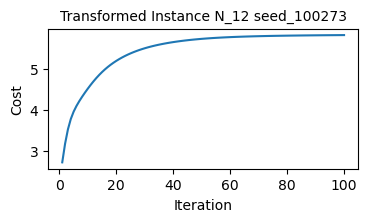

In [84]:
figure(figsize = (4, 4))
ax = subplot(211)
PyPlot.plot(1:niter, cost_history)
PyPlot.title(@sprintf("Transformed Instance N_%i seed_%i", N, seed),fontsize=10)
#PyPlot.title(@sprintf("Energy shifted Instance N_%i seed_%i", N, seed))
#PyPlot.title(@sprintf("Original Instance N_%i seed_%i", N, seed))
xlabel("Iteration")
ylabel("Cost")
legend(frameon = false, handlelength=1., handletextpad=0.5, borderaxespad=0.2)


display(gcf())

In [85]:
xlabels = []
for i in (2^N - 1):-1:0
    bstr = digits(i, base=2, pad=N)
    push!(xlabels, "|$(join([string(b) for b in bstr]))⟩")
end

In [86]:
# First, get the indices of the top five probabilities
sorted_indices = sortperm(probs, rev=true)[1:8]  # Sort indices in descending order and select top 5

# Now, extract the top five labels and their corresponding probabilities
top_5_probs = probs[sorted_indices]
top_5_labels = xlabels[sorted_indices]

# Display the results
println("Top 5 states with highest probabilities:")
for i in 1:8
    println("State: ", top_5_labels[i], " Probability: ", top_5_probs[i])
end

#println(length(probs))
#println(2^N)
#println(probs[3015])
#println(sum(probs))
#println(sorted_indices)

Top 5 states with highest probabilities:
State: |111110010010⟩ Probability: 0.49368942880097444
State: |011001001101⟩ Probability: 0.3975563320592748
State: |001001001101⟩ Probability: 0.0923720609041524
State: |111001001101⟩ Probability: 0.006409827510413557
State: |111111010010⟩ Probability: 0.00216314194717637
State: |111011000001⟩ Probability: 0.0006894132870904576
State: |111011010011⟩ Probability: 0.0006582308908401024
State: |101001001101⟩ Probability: 0.0006315429437767965


In [87]:
### convert the bitstring with highest prob into a usable array
bitstring = top_5_labels[1]
# Remove the leading '|' and trailing '⟩'
clean_bitstring = bitstring[2:end-1]

# Convert the bitstring into an array of integers and replace 0 with -1
bitstring_transformed = [c == '1' ? 1 : -1 for c in clean_bitstring]                                        

xo = 0
# Print the resulting array
println(bitstring_transformed)

[1, 1, 1, 1, 1, -1, -1, 1, -1, -1, 1, -1]


In [88]:
exact_solution_bitstring = energies_and_bitstrings_qaoa(mf_problem_t)

sorted_df = sort(exact_solution_bitstring, :energy)

top10_lowest_energy_row = sorted_df[1:20, :]
lowest_energy = sorted_df[1, :] 

println(top10_lowest_energy_row)

exact_bitstring = lowest_energy[1]
println(exact_bitstring)

# find the energy of a bitstring
#target_bitstring = [1,1,1,-1,1,-1,-1,1,1,-1] 
#target_bitstring = [-1,1,-1,1,-1,-1,1,-1,1,1]  # mean field 

if xo == 1
    target_bitstring = bitstring_back 
else
    target_bitstring = bitstring_transformed # for original instance
end

# Filter the DataFrame for the row containing the target bitstring
matching_row = filter(row -> row.bit_string == target_bitstring, exact_solution_bitstring)

# Check if a match is found
if nrow(matching_row) > 0
    println("Matching bitstring found: ", matching_row)
    row_in_top10 = findfirst(row -> row[:bit_string] == target_bitstring, eachrow(top10_lowest_energy_row))
    row_in_top10 -= 1
    println(row_in_top10)
else
    println("No matching bitstring found.")
end
#println(matching_row)

20×2 DataFrame
 Row │ bit_string                         energy   
     │ Any                                Float64  
─────┼─────────────────────────────────────────────
   1 │ [1, 1, 1, 1, 1, -1, -1, 1, -1, -…  -6.12264
   2 │ [-1, -1, -1, -1, -1, -1, 1, -1, …  -6.06171
   3 │ [1, 1, 1, 1, 1, 1, -1, 1, -1, -1…  -5.87404
   4 │ [-1, -1, -1, 1, -1, -1, 1, -1, 1…  -5.63237
   5 │ [-1, -1, -1, -1, -1, 1, 1, -1, 1…  -5.63094
   6 │ [-1, -1, 1, -1, -1, 1, -1, -1, 1…  -5.62305
   7 │ [1, 1, 1, -1, 1, 1, -1, -1, 1, -…  -5.59776
   8 │ [1, 1, 1, -1, -1, 1, -1, -1, 1, …  -5.59397
   9 │ [-1, 1, 1, 1, 1, -1, -1, 1, -1, …  -5.5677
  10 │ [-1, 1, 1, -1, -1, 1, -1, -1, 1,…  -5.55974
  11 │ [1, 1, 1, 1, 1, 1, -1, -1, -1, -…  -5.45
  12 │ [1, 1, 1, -1, 1, 1, -1, -1, -1, …  -5.3859
  13 │ [-1, -1, -1, 1, -1, 1, 1, -1, 1,…  -5.35305
  14 │ [1, -1, 1, -1, -1, 1, -1, -1, 1,…  -5.30513
  15 │ [1, 1, 1, -1, 1, 1, -1, 1, -1, -…  -5.2985
  16 │ [1, 1, 1, 1, -1, 1, -1, -1, -1, …  -5.26903
  17 │ [1, 1, -1, -